In [1]:
import argparse

import azureml.core
from azureml.core import Experiment,Workspace, Run
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.train.dnn import TensorFlow
from azureml.train.estimator import Estimator
from azureml.widgets import RunDetails
from collections import defaultdict, Counter
import cv2
import glob
from imblearn.over_sampling import RandomOverSampler
import json
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from numpy import genfromtxt, isnan
from operator import concat
import os
import pandas as pd
import pickle
from PIL import Image, ImageFilter
#from pycocotools.coco import COCO
import pydot
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation, Flatten, Dropout, GaussianNoise, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD
from skimage import io as io
from skimage import exposure
from skimage.transform import resize, integral_image
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, daisy, hog, multiblock_lbp, haar_like_feature

from sklearn.dummy import DummyClassifier
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_similarity_score, average_precision_score, f1_score, precision_score, hamming_loss, hinge_loss, recall_score, roc_curve
from sklearn.svm import SVC,LinearSVC
from sklearn.utils import check_random_state

import shutil
import tensorflow as tf
from time import time
import traceback
import timeit
import urllib.request
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import random
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import itertools
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA
import seaborn as sns
import umap.umap_ as umap
#import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from skmultilearn.model_selection import iterative_train_test_split
np.set_printoptions(threshold=np.inf)
import re
from ast import literal_eval

Using TensorFlow backend.


In [16]:
print(azureml.core.VERSION)

'''
subscription_id = os.getenv("SUBSCRIPTION_ID", default="9bce0414-e6b9-4c79-b146-74018a4b09ac")
resource_group = os.getenv("RESOURCE_GROUP", default="Thesis")
workspace_name = os.getenv("WORKSPACE_NAME", default="Multi-label_classification")
workspace_region = os.getenv("WORKSPACE_REGION", default="westeurope")
'''
'''
subscription_id = os.getenv("SUBSCRIPTION_ID", default="3e9a2408-19d1-4ca2-bb63-339d47d3baaa")
resource_group = os.getenv("RESOURCE_GROUP", default="Thesis")
workspace_name = os.getenv("WORKSPACE_NAME", default="Multi-label_back-up")
workspace_region = os.getenv("WORKSPACE_REGION", default="eastus")
'''
subscription_id = os.getenv("SUBSCRIPTION_ID", default="e8d26bef-c7d5-4ea0-a7e4-22fa5c586564")
resource_group = os.getenv("RESOURCE_GROUP", default="Thesis")
workspace_name = os.getenv("WORKSPACE_NAME", default="multi-label_classification_ent")
workspace_region = os.getenv("WORKSPACE_REGION", default="eastus2")

try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config()
    print("Workspace configuration succeeded. Skip the workspace creation steps below")
except Exception as e:
    print(e)
    print("Workspace not accessible. Change your parameters or create a new workspace below")
    
cpu_cluster_name = "cpuclusterDs4"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print("Found existing cpucluster")
except ComputeTargetException:
    print("Creating new cpucluster")
    
    # Specify the configuration for the new cluster
    compute_config = AmlCompute.provisioning_configuration(vm_size="Standard_DS4_v2", #Standard_D2_v2
                                                           min_nodes=0,
                                                           max_nodes=4)

    # Create the cluster with the specified name and configuration
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)
    
    # Wait for the cluster to complete, show the output log
    cpu_cluster.wait_for_completion(show_output=True)

gpu_cluster_name = "gpuclusterNC6"

# Verify that cluster does not exist already
try:
    gpu_cluster = ComputeTarget(workspace=ws, name=gpu_cluster_name)
    print("Found existing gpu cluster")
except ComputeTargetException:
    print("Creating new gpucluster")
    
    # Specify the configuration for the new cluster
    compute_config = AmlCompute.provisioning_configuration(vm_size="Standard_NC6",
                                                           min_nodes=0,
                                                           max_nodes=4)
    # Create the cluster with the specified name and configuration
    gpu_cluster = ComputeTarget.create(ws, gpu_cluster_name, compute_config)

    # Wait for the cluster to complete, show the output log
    gpu_cluster.wait_for_completion(show_output=True)


1.0.17
Wrote the config file config.json to: C:\Users\olivier.claessen\Desktop\A.I. thesis\aml_config\config.json
Workspace configuration succeeded. Skip the workspace creation steps below
Found existing cpucluster
Creating new gpucluster
Creating
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned


In [17]:
from azureml.core import Workspace

# Create the workspace using the specified parameters
ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,
                      create_resource_group = True,
                      exist_ok = True)
ws.get_details()

# write the details of the workspace to a configuration file to the notebook library
ws.write_config()

Wrote the config file config.json to: C:\Users\olivier.claessen\Desktop\A.I. thesis\aml_config\config.json


In [22]:
experiment_name = 'NN_tomek'
exp = Experiment(workspace=ws, name=experiment_name)

In [23]:
# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "gpuclusterNC6")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "Standard_NC6")#"Standard_DS4_v2") #"STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target. just use it. gpuclusterNC6


In [24]:
ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)
#ds.upload(src_dir='./data', target_path='data', overwrite=False, show_progress=True)

AzureBlob multilabstoragesttaiwwx azureml-blobstore-77b5704a-b7d1-4413-b1a8-b504fd99b2d0


In [21]:
script_folder = './coco-multi-label'
os.makedirs(script_folder, exist_ok=True)

In [7]:
with open("data/annotations/instances_train2014.json") as read_file:
    train = json.load(read_file)

with open("data/annotations/instances_val2014.json") as read_file:
    val = json.load(read_file)
'''
with open("data/annotations/instances_train2014.json") as read_file:
    instances = json.load(read_file)
with open("data/annotations/person_keypoints_train2014.json") as read_file:
    keypoints = json.load(read_file)
'''

'\nwith open("data/annotations/instances_train2014.json") as read_file:\n    instances = json.load(read_file)\nwith open("data/annotations/person_keypoints_train2014.json") as read_file:\n    keypoints = json.load(read_file)\n'

In [8]:
categories = train["categories"]
#print(categories)
train_images = train["images"]
val_images = val["images"]
train_annotations = train["annotations"]
val_annotations = val["annotations"]

In [9]:
train_categories = np.zeros(100, dtype=object)
val_categories = np.zeros(100, dtype=object)
#itemsets = [[] for i in range(581922)]
itemsets = defaultdict(list)
itemsets_val = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
unique_itemsets = []
for entry in itemsets:
    if(entry not in unique_itemsets):
        unique_itemsets.append(entry)
print(len(unique_itemsets))
for annotation in val_annotations:
    val_categories[annotation['category_id']] += 1
    itemsets_val[annotation['image_id']].append(annotation['category_id'])
unique_itemsets_val = []
for entry in itemsets_val:
    if(entry not in unique_itemsets_val):
        unique_itemsets_val.append(entry)
print(len(unique_itemsets_val))
train_categories = train_categories[train_categories != 0]
val_categories = val_categories[val_categories != 0]

82081
40137


Number of images in 2014 train: 82783
Number of images in 2014 val: 40504

Number of annotations in 2014 train: 604907
Number of annotations in 2014 val: 291875

Number of annotations/image in 2014 train: 7.307140354903785
Number of annotations/image in 2014 val: 7.206078412008691

Label density in 2014 train: 0.0913392544362973
Label density in 2014 val: 0.09007598015010863
dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])


1person: 185316
2bicycle: 4955
3car: 30785
4motorcycle: 6021
5airplane: 3833
6bus: 4327
7train: 3159
8truck: 7050
9boat: 7590
10traffic light: 9159
11fire hydrant: 1316
13stop sign: 1372
14parking meter: 833
15bench: 6751
16bird: 7290
17cat: 3301
18dog: 3774
19horse: 4666
20sheep: 6654
21cow: 5686
22elephant: 3905
23bear: 903
24zebra: 3685
25giraffe: 3596
27backpack: 6200
28umbrella: 7865
31handbag: 8778
32tie: 4497
33suitcase: 4251
34frisbee: 1862
35skis: 4698
36snowboard: 1960
37sports ball: 4392
38kite: 6560
39baseball bat: 2400
40baseball 

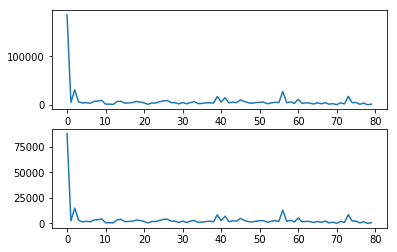


10 least used features 

[('hair drier', 135), ('toaster', 156), ('parking meter', 833), ('bear', 903), ('scissors', 1073), ('microwave', 1189), ('fire hydrant', 1316), ('stop sign', 1372), ('toothbrush', 1377)]



10 most used features 

[('handbag', 8778), ('traffic light', 9159), ('bowl', 10064), ('dining table', 11167), ('cup', 14513), ('bottle', 16983), ('book', 17315), ('chair', 27147), ('car', 30785), ('person', 185316)]




In [10]:
print("Number of images in 2014 train: "+str(len(train_images)))
print("Number of images in 2014 val: "+str(len(val_images)) +"\n")
print("Number of annotations in 2014 train: "+str(len(train_annotations)))
print("Number of annotations in 2014 val: "+str(len(val_annotations)) + "\n")
print("Number of annotations/image in 2014 train: "+str(len(train_annotations)/len(train_images)))
print("Number of annotations/image in 2014 val: " + str(len(val_annotations)/len(val_images)) + "\n")

print("Label density in 2014 train: "+str(len(train_annotations)/len(train_categories)/len(train_images)))
print("Label density in 2014 val: "+str(len(val_annotations)/len(val_categories)/len(val_images)))
print(train.keys())
print("\n")
#print(images[1:10])
#print("\n")
#print(annotations[1:10])
#print("\n")
#print(categories)
for i in range(0, len(train_categories)):
    print(str(categories[i]["id"]) + categories[i]["name"] + ": " + str(train_categories[i]))
    train_categories[i] = (categories[i]["name"], train_categories[i])
for i in range(0, len(val_categories)):
    print(str(categories[i]["id"]) + categories[i]["name"] + ": " + str(val_categories[i]))
    val_categories[i] = (categories[i]["name"], val_categories[i])
plt.figure(1)
plt.subplot(211)
plt.plot([i[1] for i in train_categories])
plt.subplot(212)
plt.plot([i[1] for i in val_categories])
plt.show()
train_categories = sorted(train_categories, key=lambda tup: tup[1], reverse=False)
val_categories = sorted(val_categories, key=lambda tup: tup[1], reverse=False)
print("\n10 least used features \n")
print(train_categories[0:9])
print("\n")
#print(val_categories[0:9])
print("\n10 most used features \n")
print(train_categories[-10:])
print("\n")
#print(val_categories[-10:])

In [ ]:
corrected_ids = [0,1,2,3,4,5,6,7,8,9,10,11,0,12,13,14,15,16,17,18,19,20,21,22,23,24,0,25,26,0,0,27,28,29,30,31,32,33,34,35,36,37,38,39,40,0,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,0,61,0,0,62,0,63,64,65,66,67,68,69,70,71,72,73,0,74,75,76,77,78,79,80]
print(corrected_ids[0])

In [11]:
def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def zca_whitening_matrix(X):
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

def preProcessImage(img):
    img = np.asarray(img)
    #img = rgb2gray(img)
    #img = cv2.GaussianBlur(img,(5,5),0)
    #img = cv2.medianBlur(img,5)
    #img = cv2.bilateralFilter(img,9,75,75)
    #img = cv2.blur(img,(5,5))
    #kernel = np.ones((5,5),np.float32)/25
    #img = cv2.filter2D(img,-1,kernel)
    return img

def noisy(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return out

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    for annotation in annotations:
        try:
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations

def getPicture(image_id, path):
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    image_resized = resize(image, (104, 107), anti_aliasing=True)
    for annotation in annotations:
        try:
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    image_resized = np.asarray(image_resized)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,image_resized,bounded_annotations


def calculateHogFeatures(gray_image, o, pixels, cells):
    features = hog(gray_image, orientations=o, 
                              pixels_per_cell=(pixels, pixels),
                              cells_per_block=(cells, cells), 
                              transform_sqrt=True, 
                              visualize=False, block_norm = "L2-Hys")
    return features
def calculateDaisyFeatures(gray_image):
    '''
    descs = daisy(gray_image, step=180, radius=8, rings=3, histograms=6,
                         orientations=8, visualize=False)
    '''
    descs = daisy(gray_image, step=180, radius=15, rings=3, histograms=8,
                         orientations=8, visualize=False)
    descs_num = descs.shape[0] * descs.shape[1]
    return descs.reshape(descs.size).tolist()

def calculateDoG(gray_image):
    blobs_dog = blob_dog(gray_image, max_sigma=30, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    return blobs_dog

def calculateSIFT(sift, gray_image):
    kp = sift.detect(gray_image,None)
    return kp

def calculateFeatures(imgs):
    #sift = cv2.xfeatures2d.SIFT_create()
    #detector = CENSURE()
    hog_features = []
    dog_features = []
    daisy_features = []
    harris_features = []
    lbp_features = []
    haar_features = []
    i = 0
    for img in imgs:
        hog_features.append(calculateHogFeatures(img,8,12,1))
        daisy_features.append(calculateDaisyFeatures(img))
        int_img = integral_image(img)
        lbp_features.append(multiblock_lbp(int_img, 0, 0, 30, 30))
        #haar_features.append(haar_like_feature(int_img, 0, 0, 24, 24))
        #shape_index_features.append(shape_index(img))
        #dog_features.append(calculateDoG(img))
        #harris_features.append(corner_peaks(corner_harris(img), min_distance=5))
        #sift_features.append(calculateSIFT(sift, img))
        print(i)
        i += 1
    return  hog_features, daisy_features, lbp_features#, haar_features

def svmFit(x_train, y_train):
    print("Fitting the classifier to train")
    #t0 = time()
    '''
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    '''
    clf = OneVsRestClassifier(LinearSVC())
    #clf = OneVsRestClassifier(SVC(kernel='poly'))
    clf = clf.fit(x_train, y_train)
    #print("Completed in %0.3fs" % (time() - t0))
    #print("Best estimator found by grid search:")
    #print(clf.best_estimator_)
    return clf

def svm_rbfFit(x_train, y_train):
    print("Fitting the classifier to train")
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    clf = clf.fit(x_train, y_train)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    return clf

def saveModel(model, filename):
    print("Saving file...")
    joblib.dump(model, open(filename, 'wb'))
    print("File saved")
    
def loadModel(filename):
    print("loading file...")
    joblib.load(filename)
    print("Model loaded")
    
def svmPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_micro:", precision_score(y_test, y_pred, average = 'micro'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_micro:", recall_score(y_test, y_pred, average = 'micro'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_micro:", f1_score(y_test, y_pred, average = 'micro'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    
def randomForestFit(x_train, y_train, estimators):
    print("Fitting the classifier to train")
    #t0 = time()
    rf = RandomForestClassifier(n_estimators=estimators)
    rf.fit(x_train, y_train);
    #print("Completed in %0.3fs" % (time() - t0))
    return rf

def rfPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    errors = abs(y_pred - y_test)
    print("Errors:", errors)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_weighted:", precision_score(y_test, y_pred, average = 'weighted'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_weighted:", recall_score(y_test, y_pred, average = 'weighted'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)

def constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, dropout, num_classes, x_train):
    model = Sequential()

    model.add(Conv2D(layer_size, (kernel_size, kernel_size), input_shape=x_train.shape[1:]))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for l in range(conv_layer-1):
        model.add(Conv2D(layer_size, (kernel_size, kernel_size)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Flatten())

    for j in range(dense_layer):
        model.add(Dense(dense_size))
        model.add(Activation('relu'))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])

    return model
    
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

def splitPreprocessing(splits, data_folder, path):
    labels = []
    features = np.asarray([[],[]])
    for split in splits:
        bboxes = getBoundingBoxesAnnotations(split, os.path.join(data_folder, path))
        splitfeatures = calculateFeatures(bboxes[0])
        features = np.append(features, splitfeatures,1)
        labels.extend(bboxes[1])
    return labels, features.tolist()

def non_max_suppression_slow(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    no_overlap = []
 
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        no_overlap.append(i)
 
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    return boxes[pick].astype("int")

def IoU(box_1,box_2):
    x_a = max(box_1[0],box_2[0])
    y_a = max(box_1[1],box_2[1])
    x_b = min(box_1[2],box_2[2])
    y_b = min(box_1[3],box_2[3])
    
    overlap = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)
    box_1_area = (box_1[2] - box_1[0] + 1) * (box_1[3] - box_1[1] + 1)
    box_2_area = (box_2[2] - box_2[0] + 1) * (box_2[3] - box_2[1] + 1)
    IoU = overlap/float(box_1_area + box_2_area + overlap)
    
    return IoU

def pyramid(image, scale=1.5, minSize=(30, 30)):
    yield image
 
    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
 
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image

def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
            
def slidingWindow(img):
    image = cv2.imread('data/' + path + img +'.jpg')
    (winW, winH) = (48, 48)
    for resized in pyramid(image, scale=1.5):
        for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):
            if window.shape[0] != winH or window.shape[1] != winW:
                continue
            box = preProcessImage(window)
            features = calculateFeatures([box])
            prediction = svmHOG.predict(features[0])
            print(prediction)
            clone = resized.copy()
            #fig,ax = plt.subplots(1)
            cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
            cv2.imshow("Window", clone)
            cv2.waitKey(1)
            time.sleep(1)
            
def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list

def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

data_folder = 'data'

path = "train2014/COCO_train2014_"
valpath = "val2014/val2014/COCO_val2014_"
category = "category_id"

In [ ]:
labels = np.asarray(list(itemsets.values()))
keys = np.asarray(list(itemsets.keys()))
multilabel_binarizer = MultiLabelBinarizer()
binarized = multilabel_binarizer.fit_transform(labels)

rand_sets,rand_images = random_sets(labels,keys,100)
labels_train = np.array(binarized)


In [ ]:
instances_train = np.array([[key] for key in keys])
#labels_train = [to_categorical(labelset) for labelset in labels] #np.array([label for labelset in labels for label in labelset])
#labels_train = np.asarray(labels_train)
#[label for labels in l for label in labels]

In [ ]:
images = []
for [instance] in instances_train:
    bbox = getBoundingBoxesPicture(instance,path)
    images.append(bbox)

In [15]:
bbox_category_ids = []
bboxes = []
for annotation in train_annotations:
    bbox_category_ids.append(annotation['category_id'])
    bboxes.append((annotation['image_id'],annotation['bbox'],annotation['category_id']))
train_split_strat_x, test_split_strat_x, bounded_annotations_train, bounded_annotations_val= train_test_split(bboxes,bbox_category_ids,test_size=0.1,train_size=0.1, stratify=bbox_category_ids)
images_train, bounded_annotations_train = getBoundingBoxPreselected(train_split_strat_x, path)

103575
519759
166751
4968
188589
216686


c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


246089
424340
327198
64730
541290
192720
118550
36728
211033
112661
486328
468615
460665
113634
252544
549237
244055
555673
217143
553284
451550
474930
84162
171270
548323
243660
216556
458139
101575
288889
246913
225579
322297
101348
572879
281262
101713
537417
468013
42570
345455
36123
317537
442988
491381
432897
144760
58633
102766
91394
44679
99856
288683
300579
219268
252136
279060
556370
469605
352819
344073
428851
514161
405181
265586
388148
497522
379777
195316
171270
15554
459000
270179
194034
561180
74386
6753
87891
130592
442298
295537
229284
312861
125120
495750
568391
112377
335140
48204
63681
77602
350631
579659
503575
433928
22102
490267
410601
145188
543376
303986
89093
62689
536949
174303
298177
96716
379130
271473
422206
579419
575701
398615
411703
22487
400845
437224
426556
100667
237385
69488
317131
373500
505418
312786
7665
3602
155588
211351
79286
518499
350070
31671
409438
420649
471312
422255
548792
112124
336354
76178
451420
177922
169779
529376
466097
363917
2

74386
387338
330284
456790
525187
76802
402505
265625
110252
23287
178431
141941
320386
331225
349787
422515
137926
187282
249810
455677
116402
54304
178620
362446
130132
499931
220046
364803
450864
144580
161234
287656
292844
516352
51175
253121
289698
320275
557155
375425
150958
530082
529133
304999
427007
236211
206395
4489
100717
496783
72793
532188
553413
345668
437184
86119
92420
387514
134643
166303
6229
45059
511455
28451
571665
279763
12044
393634
130545
204509
245483
355562
260654
559288
116004
238748
242631
237034
351608
39632
444799
328935
509084
173316
102757
7727
201530
252614
84786
579137
449103
352370
518451
373880
299498
534633
114559
153776
137042
26190
166395
100827
279129
59571
397138
359753
303126
530906
102976
541169
292668
229598
434859
385141
229541
458202
49424
322835
532768
569308
139263
518819
404395
262031
337812
147618
224677
125432
464183
449463
471217
6753
375535
92323
91040
231056
160443
3242
144091
245354
189922
246446
554891
184835
347437
483517
89266


150754
478809
451643
16112
460234
532132
177658
470308
465374
197754
320957
97056
511639
404621
561180
314408
152965
511143
470821
326836
414648
140831
449238
81576
268141
447424
105194
114515
133004
363821
557515
320566
78836
182347
579667
98867
308098
327181
60771
51152
516914
551427
160201
539966
673
461521
313009
476679
477410
439991
257308
186605
440673
360461
79077
349393
186753
410409
420380
129359
506283
83690
102851
274559
314558
189561
385604
483645
396120
26027
210848
459824
106326
174412
374490
148205
557717
212963
42858
275708
544386
494190
442682
486125
231315
187735
317391
103929
491302
214873
13717
126906
409897
488790
9
568854
107787
44129
240904
13920
526701
91821
229539
484384
128250
423850
259489
175699
193867
27389
521555
72016
478485
326
257670
93732
105903
330297
511562
550979
143158
433607
396351
512140
385744
69498
141889
523224
576593
36351
303891
111716
163175
253965
86031
208215
352192
98480
421488
157049
247849
403571
251493
364522
380280
281060
441952
4859

174773
468789
9658
538566
371486
549471
325821
177818
295263
296344
481581
52394
55637
539631
483442
495043
388217
461996
326712
222983
231056
32967
268921
422969
288055
216332
251702
100777
391102
68866
496097
29312
54905
494424
329762
93793
537543
368706
493699
409227
13230
75605
221894
472553
160443
232936
111241
242582
436214
363257
429829
218906
37286
492347
214478
521386
513712
160996
117991
325389
576818
303218
227456
80078
207454
536433
527250
470975
57313
305685
100273
560858
267055
205023
320085
418178
134309
406177
371402
67320
426869
68344
337390
489145
458751
83804
527468
119755
327055
51574
119034
385492
292499
152815
404406
107421
333920
272412
161367
151250
140080
434549
500233
46441
483690
336489
356791
237233
164680
102655
56679
553116
90154
451960
54163
253032
293306
153652
246384
150769
224949
349278
496151
147772
293254
535817
501851
298458
149220
425982
385863
240054
196688
124643
323008
565109
375202
136032
488547
115518
357975
267925
165376
252036
160428
297020


30139
152693
390883
496793
460353
361518
552093
449686
558817
90830
48824
496766
91135
169810
1912
121693
227734
312506
185687
485317
509047
220371
411111
391018
160810
240129
121560
392974
238615
359775
9425
94984
523173
32386
403746
358085
56656
200201
526057
24778
536649
535880
565264
490646
345084
448656
159299
165433
425289
481821
380271
14798
198929
577592
476268
323249
118422
9039
512940
48130
280051
291018
483489
119337
415935
366665
412330
212438
500941
316016
519707
335363
70787
471202
97238
63238
577637
516906
316106
416653
473070
416286
561406
539311
178418
21285
61809
351539
7945
567838
15496
220991
223550
298591
473765
320483
245354
26147
222027
22012
84221
223366
509358
522916
181149
198017
227552
208957
457274
523412
169510
359471
176568
156628
163485
188585
386203
84851
562144
61510
27046
577052
282357
198375
39309
183554
561673
252136
371007
570598
449712
156695
26720
411451
42682
41895
355685
476341
423761
481209
156296
118960
552895
548742
184884
438369
86210
438527

110089
361397
318261
494394
218482
305923
300439
394546
419863
288964
141825
397678
407606
365802
260917
412112
472690
410302
419689
316353
354318
515750
271987
578789
57284
125908
476736
559194
9253
33787
441900
378618
560350
567976
346898
364458
482665
286961
176736
459659
72850
261205
490267
460880
380889
365164
147172
512797
316012
283891
189148
246792
5073
321980
4180
318231
459208
150442
221614
496478
48934
17526
92380
494257
278963
135836
476795
401439
48759
363549
136200
94687
48339
416750
443789
304587
480322
511179
509247
275292
39100
521796
323862
571848
489554
473910
460115
411883
409327
422061
212856
143921
309552
531647
261829
183260
155379
260118
295695
223726
359840
446827
469435
7944
254861
6539
260
490870
188143
28523
262261
461283
139811
423222
83323
550649
315407
519657
550193
85759
7650
193578
403064
147276
86907
159929
483692
187427
142295
7697
209266
342017
523140
457387
202855
516184
469995
63263
163498
427350
510923
94092
178849
96526
421150
5313
548471
3830
37

198705
394627
141510
367549
339589
184351
231194
502300
258505
101646
320333
317134
164694
310654
405620
277334
549729
443272
478845
474930
190573
515655
86861
55199
297607
47164
314741
453853
75311
244675
415067
210542
161266
343204
214899
333599
302051
230291
4065
445928
191641
333775
208557
345833
266311
111525
464652
7603
334892
137926
264241
246761
314801
425701
227040
377772
560789
203492
296067
232417
65307
466484
471731
462023
373033
372876
536648
90244
485160
106616
396636
195916
97507
295686
502724
117156
146249
80495
168349
142102
456453
450687
307462
557627
534513
69461
274853
31187
201252
167713
165955
426988
160254
29706
251608
29501
16814
141566
243327
434894
305014
459835
132533
347587
220486
309003
538537
154279
338670
395311
461118
195927
456755
383129
349777
324036
114153
192576
519578
494811
46524
211029
512983
581118
381694
553149
70344
44724
282982
433683
492627
254821
265253
188922
288880
115003
225562
216742
44471
411108
115342
557508
179672
441574
75474
256896


302065
574456
414772
114846
474012
114034
443984
536938
188987
557762
73427
465530
248052
216265
402818
485016
560202
139865
222527
575590
115829
324697
413665
316142
436660
505510
267863
304078
86934
29345
406488
32906
34285
535891
183286
566514
503957
109050
470172
16072
490931
61734
579679
394071
206304
262688
527963
445257
225331
35558
53091
16123
327610
116851
359253
173814
158077
443479
196351
330516
41577
483557
458807
581310
313419
313465
365419
316141
114203
305685
560020
530832
200221
85048
504184
283246
432727
298914
455408
529562
131580
401735
343422
460442
210344
352398
279603
289510
306581
485381
204606
509988
442324
31813
1645
392664
110030
157371
417549
110089
287900
25425
451588
368825
467537
255003
127134
16693
276871
331326
58627
528761
459328
33172
414284
527868
118934
125263
336445
288259
232720
416810
18059
328571
394793
94984
89914
44613
460712
133486
123764
360370
497010
494486
159105
514318
114028
259228
425721
233748
545944
203975
277341
542931
104114
24714
45

325555
63856
426079
28797
494574
34454
165147
279616
374977
287718
25746
578888
551472
173153
437184
229995
353017
348206
43007
275919
46981
486045
543552
233296
531523
442008
187557
194510
511553
266228
254801
26131
337985
259484
451513
502629
139948
361518
537878
281051
516596
372308
331832
367982
9012
222140
81012
167180
237340
94132
403132
509269
418315
347715
501358
186703
542
473773
244416
420019
16089
325787
533569
27667
418135
172509
87602
481209
433055
384907
206083
429735
84129
136565
454171
365329
25759
442774
554689
479292
428391
123558
467939
179476
532718
569203
351914
334104
312826
215626
534655
39598
54943
22757
435322
54375
337353
24699
90964
324717
172398
91023
102357
441605
438255
42472
477943
189813
394089
540554
148811
101753
513371
60425
475915
419750
565303
243938
77195
249620
426538
53840
319190
118806
308548
463788
385441
268668
176785
326354
282069
261720
107607
158501
291039
216930
151227
472258
55298
504896
138453
466964
369476
564267
312344
292294
257392
25

345702
373645
1785
503482
242731
78827
491510
556406
37244
508030
270106
178526
321059
262538
122527
507136
251049
550512
414067
395504
419053
332202
137134
206501
307869
555038
393553
464927
218807
47507
225604
72016
258934
54464
14683
67802
174964
443639
363160
239984
515206
415277
80686
118581
429485
478142
308520
360313
260264
317573
137674
190805
524518
534312
513978
222309
116740
64460
383553
133284
454003
409050
97861
65329
420643
543026
221895
329066
180827
322979
241767
469248
366643
100865
104304
262446
426170
345591
341212
203818
444107
392674
420823
233646
559055
581031
59776
143511
526312
224112
391892
343823
48199
559427
493209
302108
138131
348907
291540
35725
243021
99539
65360
4180
541619
437630
54943
382659
290935
353813
270184
538422
322691
213381
344157
20839
529490
197629
401603
518451
201252
529524
151787
408303
470073
252092
257392
474004
218760
422270
280119
419575
135664
312476
85501
440334
564186
62336
264353
3236
140787
458308
579414
146599
281840
563798
5659

312926
24782
310499
282357
471109
232875
87249
162753
448985
437778
50725
82844
310085
244839
488583
339547
522722
421903
78355
388136
196721
24972
461688
209531
304466
230863
369782
444571
67115
104234
445425
374001
97861
331370
205607
424368
581881
480403
448381
247157
120969
551630
305267
385704
293576
532719
49378
114174
92216
463830
284454
328275
307462
573854
484528
332792
235987
173279
247977
24714
373747
286120
156958
409771
91960
425114
1355
125120
133194
382142
275130
216029
415458
371950
379520
466694
43029
430925
359984
114854
475488
363146
338558
78609
456344
331334
292661
136565
343498
80231
157811
163718
576700
235233
481586
143383
556707
547693
574731
271235
113970
360031
83029
559358
123389
234642
238902
136832
262124
310289
315860
457442
255941
303036
478227
195265
392030
115639
502407
367814
532200
478257
438026
377007
558475
273886
4080
410226
367814
478257
2444
70211
528157
193925
164343
497972
447118
484690
119979
441169
496746
434270
282208
456399
63166
105399
45

417474
352173
518473
438095
425418
289514
116326
426598
359048
206082
269858
540183
261381
212070
233116
436544
131058
383390
69614
345265
75846
546343
368468
482928
340633
303923
130024
360313
288906
342342
481057
581566
254787
254822
486899
532817
403683
581351
387595
155323
30163
166926
393303
52819
159521
445477
477664
346637
521972
267402
200138
361420
126732
551676
263467
350435
403547
341286
6229
189780
397986
543515
171649
423890
451166
75258
443272
155998
407685
460441
319712
463966
255941
474396
533504
80431
357272
579576
229940
6489
55728
565002
314893
39258
523701
111235
62351
143733
305687
529300
12673
549166
283615
459959
408266
196931
217136
324709
150646
15451
410401
510806
184684
31922
332931
285132
244000
188920
347042
467686
259434
361359
122937
32985
312760
277243
550193
87105
36006
452638
135082
560422
579543
552265
70927
367375
311974
506463
44080
222513
421903
572814
327063
355534
192513
130088
277472
564687
231596
236354
88470
304092
530216
411142
317153
244646


352980
455363
48658
265573
303213
204273
250424
418736
118535
481748
528342
135397
496977
359620
139817
310300
471799
394554
452892
120655
356565
160254
518390
555625
139983
413070
14337
387255
429491
96073
469024
347111
102550
372788
508568
342279
391966
524227
146091
225363
291767
129712
548936
227307
79269
297898
457437
578734
161917
512764
474472
164543
413585
257102
456719
372551
92974
58102
421884
483795
319134
216742
219059
380420
245116
223754
150300
396247
85372
77018
491274
356664
101904
219339
516432
566115
150082
187897
24086
202388
398287
167300
310665
57930
337752
178538
433055
454858
244282
573807
407027
389770
488941
523034
484355
475575
440243
188478
263311
226451
276467
383658
432420
20279
498786
478537
259811
121322
536707
276582
15576
403221
337691
83914
465294
327998
167683
508192
220898
95023
467686
468357
361659
121235
44810
108617
122511
125555
119267
323341
336839
116518
441544
16827
510320
499679
12822
299764
303436
551647
569017
418030
128027
125348
70687
336

372292
212741
540586
205547
11805
274203
459110
417171
34824
171378
542475
215341
554855
313705
481553
515719
277700
254204
264821
220942
448656
211863
458876
501926
351141
401136
457503
394697
18402
102771
400818
555170
116431
86393
506832
334631
166201
260634
278174
40246
562075
373747
11805
329263
451389
395863
350170
262851
336002
39080
300273
206501
373923
314558
364885
443400
516793
45292
461181
147331
65136
64010
181828
551922
510781
492179
150258
103383
198560
47952
64270
396030
464490
566642
550355
297570
87100
18952
424229
135041
548559
234967
65880
458336
312269
511751
105532
363605
505629
301195
270172
193943
114519
155794
246007
397104
112707
138117
206203
427344
205299
568424
245846
13279
460187
416918
7853
399376
407262
28870
166481
319045
157588
353098
261673
269580
291911
416909
45701
483854
31250
177917
150258
482148
303608
543732
379201
191325
482209
182976
83386
516444
174410
142466
63888
370406
519768
285963
536834
215844
126161
542452
461484
223616
425540
555088
1

168718
245683
270715
40075
83178
302551
472553
523140
151615
261871
312212
89340
183321
14230
52151
341359
287302
164001
13417
66299
125266
255898
523831
30299
356384
3366
211312
579341
147896
427909
507749
432328
112577
48661
443377
365003
219784
159897
455770
119962
249226
166764
55128
394283
181475
178431
535460
156939
223875
523484
195225
188310
15011
37244
249983
562495
480053
197686
242467
134871
440903
126126
102930
166959
485367
426568
389491
373580
450741
124360
260901
524255
337147
367907
37863
508488
464956
471405
346351
537335
445327
483453
129871
104270
353344
100627
526729
78977
292289
370718
78009
347331
290136
167862
82631
72895
153008
265330
211254
26292
520519
384302
180087
284155
242210
564153
511784
299794
236176
34279
506927
294133
437156
513961
495956
123306
238223
4421
195296
138741
177085
416258
99066
15110
278656
20291
379987
445306
90983
301195
166678
211968
30109
115777
442008
574599
393664
287509
260035
162252
308653
16060
187090
91451
57551
263265
476934
69

148931
577484
273716
165792
490347
511641
76802
509584
217929
14375
418087
460862
356213
478652
23702
235233
235237
313131
77467
255954
73626
464909
30855
104935
441544
470618
97391
183218
535899
272026
30488
370383
358566
394764
154680
89725
149881
560389
267661
213003
207463
34563
495233
79441
147466
103335
348381
9321
22374
118904
403064
109836
16273
168741
161814
435897
61510
478337
164013
578137
122216
386906
197322
560748
62778
332733
469010
409574
240490
512295
26625
281339
439619
57595
396418
130876
275494
373830
371201
425175
432891
154414
472250
357967
310772
403464
474668
444392
118407
173157
264589
222260
503385
494403
128848
221420
244416
539099
476902
125928
502326
228042
391823
339382
375961
141566
88068
250848
484847
437525
366086
330223
501710
539719
229347
290656
209513
405516
577725
257489
108360
311982
545507
547846
188952
102976
525510
175527
571610
63820
191175
149566
541764
385916
246927
212429
311715
185591
198064
22484
494528
547475
8432
130869
250735
428810
10

303891
319398
10856
494833
165990
137552
261800
394286
427384
536317
434262
396984
319351
563098
467723
200149
45361
314092
367367
25283
482740
500575
428355
433472
466710
355894
567935
24788
373198
391141
551802
210728
238535
381865
39089
297019
37620
126687
24842
445301
425308
388991
342086
560573
437981
544220
101319
320353
147883
494391
192400
153321
261871
334872
479729
302989
67082
81784
307050
89238
426728
541169
168994
23219
98748
350552
359713
387058
65884
19002
264388
182064
254129
77750
941
431853
534000
134128
298906
212679
415206
409811
257232
194346
280839
229075
212741
81748
544719
418868
310419
256720
561753
444166
520337
379579
503421
115226
281052
303735
350070
442062
180639
57940
541855
93246
253260
181885
357010
115887
111048
431761
44946
463349
243610
262752
76081
60982
4694
414111
212118
105865
329179
155105
502107
467265
188239
516623
61734
150184
137787
240080
428485
59388
198027
221937
88034
142761
470641
564513
275443
544053
69257
437996
531391
534866
518124
3

389137
441714
174185
426254
492639
21786
542638
273106
311811
219488
435695
93842
282901
115639
354532
63121
417070
42481
478257
10005
418609
481506
12386
347884
507196
309519
337953
360585
160952
223500
24310
95257
394879
461593
211593
153677
504054
30677
411814
477758
396975
63119
431133
400968
474769
9885
129347
564705
46251
148024
366489
407770
5587
348269
416648
474784
425117
296894
96105
453586
442590
578521
114943
541343
297570
474256
418609
54020
71371
4971
95518
334850
240904
54130
329090
123975
282572
195180
185666
39754
146706
185760
452479
573627
351827
486250
204700
463108
445395
164357
523700
513966
158878
250400
335866
331982
325089
301381
410590
345844
443465
459569
386603
133981
111831
97010
477468
534406
506136
125374
413291
131979
167695
302569
109908
314724
561947
432877
230931
257109
449776
90912
238022
344793
428000
36805
490615
564437
280087
334400
280913
412908
246494
184556
504299
325781
502508
74150
316856
470002
532704
303608
54244
42463
309502
321234
332311


139285
268569
407336
431917
211350
548772
464856
264567
233351
275997
6151
379399
394713
179031
304601
501909
495666
414260
211486
19489
281615
474004
14683
533041
955
9987
450457
124266
445080
471279
420465
389292
273516
60325
44788
363243
320752
213282
259022
126608
59229
157160
249968
220568
221691
232936
290047
61203
274665
283753
115604
197257
13198
381988
103797
122834
16902
461252
363346
455654
62880
331186
394627
151587
445249
198057
380351
358411
504336
67988
536649
564099
365950
87219
506073
31822
337304
302489
553894
65943
311067
161935
431192
191417
248133
429643
360300
98882
451206
432327
186550
299026
250035
216304
161597
418894
390002
318724
148239
404486
171180
8504
19399
186493
354218
192394
558011
251758
224140
77018
490648
185358
135332
413676
264645
452167
154345
119297
104365
414838
400093
339643
323268
406938
488244
558584
318261
419904
566993
51342
295613
67571
184610
12861
483144
22949
472266
375004
483316
239331
324124
355534
179650
186526
449108
513966
245566


196090
537944
387887
447976
537286
501814
72519
485099
528851
32804
53823
235464
556838
558615
534976
372130
404101
496039
102771
528452
163239
487766
229035
433657
291504
563771
232661
375665
381795
304561
367538
499135
6901
347051
133261
309840
57830
486899
581065
328638
149657
385307
526877
554085
164435
142746
366927
23812
11690
507028
562650
420065
44687
16037
27252
398202
231334
339978
361519
157636
25525
98064
281888
29482
433763
223007
364719
259348
119283
503541
161093
31913
575303
154352
322260
273035
330952
192077
534917
408204
154384
346930
289352
68518
22652
448842
356788
334616
410144
357113
365999
141554
368983
560421
16496
321491
287400
79453
380591
385804
311076
349154
388064
457257
339781
4823
158818
261541
231368
316663
505629
434299
113123
222688
571768
579663
15744
392269
48474
258129
472191
379911
103083
525691
518351
253264
327682
423818
166120
511221
16359
376776
201476
369866
573892
555800
286690
112226
190022
5832
102851
286550
410173
139345
49283
482959
16179

484201
50518
15451
292451
495169
138956
473095
123366
231801
398051
421155
267435
440349
209491
344629
374376
118459
17413
255480
213677
72354
405695
483517
385552
2998
336942
550518
392881
577405
339987
566668
116783
525567
302634
337991
143386
117784
171834
423720
50161
107691
4920
208945
486125
34563
415710
348451
488584
528147
361291
415275
137288
362314
437224
175439
31434
505552
339690
388255
143006
453711
545566
zero-size array to reduction operation minimum which has no identity
463571
354035
177658
116431
214018
268986
543276
72612
219127
208333
581310
136886
219926
303022
254204
390291
458650
134309
455444
104689
48145
475415
246491
471915
21257
414885
439560
182947
307757
559647
215092
537074
66746
194600
529954
561761
551275
143168
151100
455893
108701
225989
193193
208698
71502
508861
175180
144022
480790
302147
304466
228965
426930
58766
327572
376109
183427
304093
47242
423834
179462
361437
151287
279816
76912
129246
375304
63890
190718
174228
221420
41097
206492
553736


572526
360279
275630
258182
204217
369357
206039
392039
51045
111831
453945
396303
392039
11554
197307
41549
480960
3579
114701
382368
268737
1906
509528
48428
212451
206583
16796
379987
9648
360271
33517
227497
374418
259265
108451
549127
329239
435347
228098
177088
117349
365948
442001
304292
313432
372554
562679
198249
575310
382100
558211
43077
79968
562596
214464
359865
290010
476426
272670
322253
87891
362067
391496
319543
48863
549714
220464
412830
502281
564459
510979
534694
103230
562904
561622
102835
37062
571157
304958
32242
571825
420397
288379
101586
146324
561124
471680
470618
90566
283019
74651
435161
132626
9062
184431
429119
378305
116570
389232
32918
336672
91960
135327
457087
321346
513863
127932
245415
462908
293524
283107
546097
184109
74925
312943
21204
219910
194896
62276
487632
103726
455311
189645
356755
126489
551877
579846
247597
105768
509601
216685
89914
487693
47073
495433
100157
321713
426839
92752
467038
83153
523468
487145
559762
543284
156180
554875
28

576776
235168
92685
301114
446006
340108
234569
428006
408078
59281
491743
292887
178017
406056
149763
495149
326350
129914
371511
473879
406047
51530
169026
205931
88110
459190
204556
539358
5373
526464
337262
167383
552383
144522
144049
68082
291973
395627
433196
548619
146638
292554
256451
249073
440904
577125
369504
147593
446266
18809
135392
177367
35052
511670
356286
525589
288739
82729
379844
41272
8881
88720
547636
518451
447479
481479
146449
297692
496059
488505
110794
77650
179580
205826
364372
151587
333081
349658
66883
476501
18294
205556
157026
310649
548893
258772
311066
465416
397599
552561
250103
78986
153134
351656
78859
542541
500693
181098
459118
340537
441605
158443
560571
104343
457725
164142
72551
488089
105998
36816
45459
317306
536553
166120
315256
483690
312117
221785
402425
354794
160658
398382
376434
389016
448280
570512
559586
536419
1781
357895
124477
290106
81296
356286
448317
459212
293466
183495
532461
486328
563793
476040
327572
449250
504039
28011
2571

52299
144353
106521
526247
101248
310649
275956
227127
496348
311408
56480
492151
54957
296384
472172
155942
209558
152976
137999
515829
372199
375282
340971
52844
521922
266496
84803
255425
218546
244835
403170
543201
496943
44127
40418
38584
265274
234743
44017
385674
393985
268306
489066
164357
242061
300568
490035
170101
464237
344280
534189
551733
210849
516455
425137
549709
142779
322536
106504
109076
480576
104638
282981
201039
212672
329623
376131
88257
137052
371072
308168
510985
535042
433334
270596
358391
143017
464494
123336
379498
418812
554502
127581
535460
136145
349390
90782
458082
169794
180827
461501
328606
542181
413951
355991
25528
189020
321642
3830
369598
401229
121363
536265
553413
14870
428925
211557
161348
141200
448509
283269
143277
177253
287029
212934
38933
196406
567663
530047
199827
531662
494678
474268
123445
313201
508821
536823
48742
255399
73022
351451
31434
358983
174358
379357
340893
157986
99313
7455
212420
55682
445220
353839
389351
387368
67099
27

556512
302538
430481
413999
445327
248227
344126
561789
11826
520703
143171
122073
474775
460937
332875
164435
360736
472108
347462
377395
323964
224772
491107
127786
363468
575949
564933
123412
139775
291503
127871
170857
457871
196529
370391
225191
32575
72233
561394
220850
551869
248952
457161
254301
479886
260439
273555
268993
201261
98318
224079
123177
219379
111831
139183
338637
539832
206225
73549
262862
132888
322090
14203
524320
435556
537127
278265
49257
477005
335440
267067
250903
41404
153270
48663
521005
493845
89571
27987
536607
186868
552467
55984
346614
186738
206280
215480
226541
232351
426556
168097
298177
434894
243384
341941
110634
161156
66236
257945
131812
254637
123824
455408
439175
490646
458738
16273
172751
259228
569591
552041
449347
536458
160810
42804
386419
123298
532505
145718
166463
279485
3685
178789
468125
56664
443254
79076
568658
531309
128013
193299
126915
551922
66858
242762
415277
460996
7174
425320
408730
453625
283170
213976
306128
170295
175439


254884
22240
233916
305569
341027
558108
254968
554855
175951
43580
207094
227826
351161
376691
537422
562819
41772
479696
53330
474404
458611
493227
546952
321938
107767
494128
549002
498022
474396
256465
400380
109357
73690
248833
435716
554953
273548
174861
562335
180445
3830
470647
465080
139109
383106
394764
411987
81620
132521
224759
375802
579926
496891
328981
35248
448267
471188
211913
298483
529188
43354
516184
256190
191061
505152
577343
456433
384302
51390
274815
58864
514553
412760
318506
458832
9253
7307
336668
134640
251165
563208
283485
469024
300928
581310
419483
486178
316993
252779
66737
216119
126470
434773
456863
155543
315092
140943
579123
83642
428091
137090
31135
447464
377110
122973
422894
363718
368424
372121
205116
580033
335633
302707
33669
560087
172420
139109
113261
560172
454181
264320
336333
96535
334858
228274
307124
264598
110869
516587
524453
521726
554852
569062
427981
22871
68947
60136
74415
448509
422343
141785
229976
159897
370945
93382
415275
1731

576187
27330
114027
568880
480807
361811
572194
100912
566798
246384
561624
45741
504769
110324
51322
328185
90148
215493
137694
135685
311197
98213
307869
560173
78065
390000
248250
488601
496478
316281
144230
21504
254198
139173
462944
316581
19448
203891
223127
274254
519105
315
248009
454679
358361
385701
498138
464888
403464
397388
540321
15089
547846
192266
42619
37782
547417
264699
170326
226734
181682
137892
420402
500076
428629
118974
466694
508429
62029
256177
412174
457235
377464
51465
568455
12681
20063
332913
353622
403358
407671
97431
235091
360870
404828
437073
509718
387928
174605
234994
232127
164327
510820
553407
230340
388740
12233
74201
348702
21138
273439
385305
394921
487139
109588
216681
337638
101450
295759
133517
136900
572526
373400
29895
81799
209012
172059
196974
410173
26570
556065
557762
402844
107691
440752
554436
103276
469147
247068
204889
47640
31642
170130
512060
208782
313201
341354
542426
400726
321878
91137
37244
482191
40251
577122
538120
235233
4

533989
412910
407689
434837
269234
549115
358237
404428
234316
425836
439463
299682
530683
47213
581446
67988
218917
308139
76971
43543
296758
474616
53304
498134
538517
559585
423778
315339
284817
503554
572978
11497
455287
230000
111772
254025
483254
359519
136539
564015
541619
538857
486345
362340
433334
274337
456416
213527
443397
422279
321964
9708
408779
1271
26488
1943
568001
405991
296978
306299
208075
62131
446628
525884
63668
468992
513795
446898
328810
225468
219225
152764
181626
208875
46385
57213
203704
2639
335747
561577
27050
552520
18535
57707
521697
408526
547960
421102
338670
472157
123967
12408
502748
279385
139075
241421
553623
418065
242539
294564
503957
297684
214623
141860
381472
544968
521101
61266
35741
72095
164499
399750
230160
334588
480005
4331
575228
119441
12158
414772
109666
206415
93535
519985
250417
267688
46978
503421
88419
26725
176174
412661
257029
58267
577213
344920
433023
379517
160629
502379
215738
331588
214526
436070
6414
557037
335479
149327


220736
384263
455758
125180
303891
279935
258205
235904
466573
536368
139500
335552
258714
247547
86549
346111
438896
285064
391739
376953
497567
528851
514207
404852
453332
264212
309714
338164
407820
123310
499865
182201
378711
520848
472922
10784
124663
546959
435929
46729
178553
205392
124169
191321
334529
416408
72866
22102
511522
29706
563511
559366
493307
91023
166813
331266
340647
311941
373309
494007
52628
558615
275557
378832
560723
333575
498022
190475
150838
404254
528937
105888
343284
237919
136896
516193
434299
511625
23378
222036
213274
509149
289644
467774
234986
263212
314048
554689
242212
290047
263098
8746
176785
400094
547742
248236
385157
472707
265139
396467
51396
557527
143664
296474
134562
502581
389935
140481
191639
489333
243333
296289
253498
447041
564715
149030
201724
147505
532376
460470
99004
283891
56364
385705
108266
525360
205432
494534
504861
104994
223992
537512
162227
313260
518695
440372
198227
497327
182765
74299
311822
556920
370728
261514
28868
2

286499
277729
336395
24842
445670
81567
250156
249445
430617
367814
232889
462813
558771
436539
47848
33111
519273
165542
64694
271195
328855
255660
123831
290332
65855
289569
244540
66292
459185
221787
503567
50018
101328
348822
426170
469055
254042
72030
425161
396212
262861
29523
120466
112114
174934
293598
49851
556453
576518
560037
541422
320537
543645
244082
155823
525678
195316
42858
44170
439118
286594
500675
465369
387597
68254
129912
321048
54398
102004
257044
572179
398130
395673
446303
492347
184320
374239
429207
519188
187473
223754
73724
394992
520860
184589
113839
444830
375802
465559
440695
25665
558798
475551
93025
423855
559695
154790
392843
93971
319543
184980
382979
216954
269986
168405
332013
371796
164920
95308
400726
443490
102655
276895
134396
115970
448826
216114
448177
543217
273200
5324
44815
200351
318382
514283
197169
301431
457274
8494
221441
575842
272402
409825
435323
202158
288753
491936
287303
581668
318506
357812
113009
137617
479172
9462
78494
406422

495633
568311
351161
38681
219946
463944
26166
513966
20888
328935
131976
196082
520479
23480
203249
159923
202990
483899
336675
240054
194448
503234
84594
242854
64622
380096
408040
123247
110
51829
88514
77005
202522
189278
352524
548029
300537
562766
164102
467308
254604
431340
62203
271167
240046
136184
479214
247271
572611
565047
202554
410708
274275
450330
41305
354410
471283
404852
224776
491279
248170
480852
407522
437660
421840
376919
13938
62075
358334
466261
363468
105532
185591
389280
405920
450975
317234
563545
24674
240038
274631
221189
147973
527468
208513
101602
198375
580631
330426
287804
180578
241975
196797
522000
529352
259022
364814
334714
228330
12766
64105
570463
335492
367605
131976
302353
178022
402412
207833
573980
533602
397129
267956
553554
37905
16273
345172
308652
388034
218734
413927
565940
512572
55130
460113
392177
100347
534776
127786
131678
396490
508680
404759
260748
322730
495789
64797
578137
104591
216114
324381
6190
138747
289005
503703
467564
473

391272
14969
399971
543608
283584
179650
525264
92269
118227
376864
55121
60604
363750
138659
135989
485868
455135
442723
412615
173367
535229
509358
222753
220793
290354
3077
163106
119909
14230
64501
444800
565446
296581
103512
546632
379034
78511
418557
349905
527970
3236
259884
251219
75144
215889
319863
147593
338478
209915
294223
6936
469567
253212
505507
494462
466530
308310
373254
89208
488243
45792
311578
345244
364959
157804
530002
490489
124408
276749
543194
575323
224505
133013
217676
112327
128278
153880
92684
482728
49716
545260
326399
390581
174354
329148
342851
148240
409982
127115
239984
306561
230945
23996
440262
296777
7890
445462
341027
23735
221156
516321
311562
496420
224781
252314
62464
577148
136032
437908
329942
72454
62648
175847
399841
141652
564926
494032
404592
566547
206932
73427
165050
208372
415789
482756
324953
278303
470618
324049
520860
29153
291476
382289
50405
476893
552093
200447
225468
568432
337151
19375
221057
567082
399258
164534
369735
451032


36546
353138
579137
367125
492293
432019
550745
317274
215564
204979
270659
530543
123177
166959
397511
369443
40407
225307
47949
252883
304173
153466
473891
495433
6421
506037
103108
286700
567037
219467
16063
452382
557721
288506
457029
204519
454680
405330
149192
30725
371260
156835
536169
377473
307137
392381
484201
449510
84949
214726
274203
75842
495666
118736
511410
329276
107212
495051
478872
210079
530950
246446
342520
149996
273456
504606
83468
11576
241076
531033
340103
492376
565595
200068
175536
316528
561950
340976
15582
167180
346266
513602
50772
418325
384161
2608
4421
246246
364137
106010
575641
222037
292722
145915
254850
56193
137341
351141
41997
221038
233064
97660
89166
142977
331326
565975
447151
293800
290846
42418
294667
328792
351841
536233
212311
420582
120782
398744
126906
104026
290866
60602
210684
574623
35382
336077
119248
148437
101564
253773
533957
17226
18691
531979
81784
58735
492692
446628
539313
411015
315488
373758
347319
339536
246718
271464
343009

395591
14873
298327
378312
224414
404905
77095
482470
326610
17474
271633
285743
426776
337707
149643
15486
335332
181990
272578
412146
369936
348637
407482
5907
502717
462283
332316
320957
542174
400838
263779
32471
344592
244383
19463
138258
541619
75727
539180
477047
272653
87792
328978
176571
434072
58627
269249
256270
59036
28961
520950
250196
189330
30288
204509
560997
201972
532866
251255
253281
340440
286042
120782
47293
144937
343765
408249
218846
524881
231524
401688
412222
434837
427154
184800
270740
223014
451032
164168
69461
137406
172105
247404
167006
270716
499371
553865
180569
93590
220772
190884
3917
324893
547769
562510
126950
18513
264697
334103
347331
47294
291107
573357
550569
154496
193943
128254
40286
390110
327717
408681
180087
13650
406061
329001
14630
444744
239499
363549
557888
37183
557586
519124
159100
54953
294734
326947
580185
380717
2402
95185
376009
346341
130366
2860
456109
494711
150500
260932
349423
274337
135475
576233
97633
395198
251425
38686
2767

462993
491900
513961
418812
518473
394776
469708
105888
259514
119884
30000
167498
382641
446870
340259
502407
98408
490112
102822
117867
187642
520451
195978
52516
482841
540814
390840
21254
284002
438600
22355
420582
293489
181061
538588
270234
243262
186753
42972
349103
304694
452465
545727
272957
212633
367259
517959
114629
506321
516633
471731
34340
69401
53101
97165
279226
454162
403464
403404
472581
36417
484150
534859
41577
329634
150164
313164
90818
101750
79244
70403
470720
543881
246119
359139
361659
121453
300745
576803
337808
394560
435218
511751
294587
443084
244844
294837
478845
147701
466797
162227
490555
414495
281756
574722
183445
359704
399878
226966
111583
468970
233093
74065
489856
63681
546800
2377
292146
357612
85939
481357
330112
462505
305635
173448
65584
32442
462404
173070
218674
386062
556203
387597
233959
426400
572897
128557
553773
383737
370843
26995
300470
419904
467762
62543
290305
39195
526682
49346
455995
186227
59438
555088
447292
30340
47387
238615


556482
346360
235683
424470
178998
120335
347313
334463
430522
37160
538735
162089
294937
102004
230644
471382
4546
210542
563793
157621
286359
357210
73353
346481
390933
284543
502670
62608
34793
525823
360535
576012
28415
556332
2833
325787
278347
578506
81481
26800
88192
16254
235147
332960
313088
553202
77298
325021
237667
101522
398901
37169
401854
131522
230931
425418
538609
142276
392949
472549
135499
510979
15356
528970
418804
282776
51152
456439
67560
225473
459463
148240
503703
569255
156120
323476
84157
467113
140387
164522
182976
275035
581277
237214
201488
184397
249120
160968
509859
116503
96463
489666
199021
406518
427779
479272
572207
205159
119093
260955
335304
294978
484013
317764
210751
230507
25625
333775
457962
346160
224349
384775
551595
25193
489400
254599
497393
197812
543289
198880
515673
29299
118920
18501
211913
424632
491904
412691
551922
22951
112226
519996
99046
481355
428117
502361
225579
205234
122583
493822
409275
564349
467753
537461
188009
449455
4557

75359
230516
485267
499460
545953
348826
501864
557388
32984
203692
113328
509564
373465
173856
548742
364206
441507
16755
448930
576527
372824
428785
224230
136653
574271
547135
570581
157105
147710
447231
5340
136310
46592
35245
289223
152096
246376
133609
263278
232781
328673
320707
564287
543769
504774
413799
109078
96790
45492
315663
8176
30429
379173
326508
532635
4706
127377
560476
574000
510998
401980
119860
347884
172925
329865
236910
416202
467334
380928
379034
392033
518844
485267
569878
19714
502632
109041
72505
426791
56283
81749
19074
355425
562740
430621
295840
255471
501624
339001
216820
401201
152020
512872
363022
478958
136736
219619
13662
468465
565740
209288
389615
86907
511869
113211
158818
243327
253212
316466
484504
557047
340647
310450
577749
355122
451283
71255
71011
51704
534347
121612
109622
228714
12529
337882
286013
98944
36732
456522
122274
147051
130598
9185
200064
168643
367461
407037
275608
361888
142198
117918
211676
459524
514127
373881
578627
104898


327935
402073
487288
569037
252448
431024
20475
406244
469661
334939
380279
186493
485560
312346
268656
157105
532132
417818
261843
210271
270198
442312
132521
295780
493793
563243
472234
66398
456975
293524
152677
311197
406004
576902
142746
566201
305573
571656
144000
382274
563513
42591
313541
233748
268533
496879
346795
369295
74081
366146
177088
349319
493983
282316
334104
208024
192808
29801
189660
297954
178635
190521
542541
5700
131918
141554
174427
513918
481772
228000
48753
405709
19929
468125
352985
460353
124893
210956
25245
279632
200404
221701
110353
523561
294850
138582
119953
479095
128560
199381
563947
344902
62770
534220
64093
515106
439356
160264
398633
212712
342353
36939
334474
283188
308522
112673
103383
504336
440204
356064
532269
496902
448409
370369
442154
205131
528243
166711
75668
195064
181711
216556
129888
439939
81885
424218
219859
32665
723
203206
307174
136331
6216
120541
431207
43001
347168
485771
412491
281358
398004
104756
72731
73427
465017
16113
222

165945
143348
286499
169646
217938
158786
557272
214131
581744
125188
8519
297570
418737
85114
363750
100124
518645
388412
72216
288828
481457
332015
424439
158684
157486
227137
569459
578164
564681
72430
370278
24086
31587
146611
529409
553498
157105
29286
547475
256606
467790
138114
396105
142393
358616
526793
24239
412267
84489
43629
145614
400966
40181
245417
244835
267266
459991
314292
487679
426143
501138
419767
335940
309598
386272
114229
354115
208919
325389
167042
141160
498156
176985
533799
362740
65345
114598
316971
278347
480568
276854
465347
20849
45842
294957
326891
452638
53236
83973
70295
202800
370511
388533
180765
214087
465416
281224
508663
166296
409811
173978
238196
444644
199410
171564
291009
318139
455311
394529
466694
187866
169197
68397
333818
237222
459001
357429
107197
389615
355621
25105
312712
271250
315476
438755
157986
483714
121782
320045
74902
370329
524366
296093
94045
338642
160549
459653
145161
305414
481098
522244
196899
453711
128837
318811
500789


120118
198436
329841
29879
7853
93018
453779
480489
402407
95850
249616
529347
519548
315339
304157
25628
155754
121779
466664
128299
375282
310606
194528
460094
217495
381333
575590
144194
279108
286234
339684
31915
395053
343154
469188
515212
425289
80043
163266
181975
258040
455808
544819
281756
237210
337422
9231
525303
321181
418964
272155
40187
348871
241236
119560
384231
68637
283825
359085
79603
79083
342130
534048
68149
576187
306711
471008
510979
406282
426642
81576
418035
182384
460937
25322
254520
442771
134454
487486
444649
137926
561468
175118
267022
116049
384742
166560
25858
155806
172420
451767
321938
289329
431178
172105
198436
248417
412691
338746
123766
227733
121525
496115
420427
311065
554949
560943
555206
367065
280674
354312
197201
367092
168854
332925
171665
380893
439057
315294
87450
465813
142352
324228
227010
226580
243829
80441
165607
237848
445960
286910
426826
80091
292432
515224
448843
102004
481930
5016
98882
383014
267697
384261
285486
88671
283682
379

73814
117918
517851
4508
560571
418736
377496
22230
236184
274267
159820
543882
437902
180578
161304
489218
434211
26900
508140
376828
562092
159331
330728
524063
238749
196931
54892
424907
524048
301012
350815
275170
28523
459000
310013
26165
142847
434357
376397
448571
80389
262508
122950
381908
423586
291865
490986
81966
544449
534166
21079
260791
430285
186962
230644
576622
501710
225271
156914
69768
417376
330311
170786
174876
270431
441794
424718
215374
537765
377594
285817
128732
129437
288664
42804
443547
151893
302660
419767
82372
344146
324682
134946
420626
515710
298614
279117
372311
251255
252744
90238
17817
178966
238231
160064
517545
248229
354993
22256
248565
1381
72987
230404
362281
428093
219784
275413
291478
186599
18414
211529
169499
511988
531179
147192
147270
57361
88176
342483
197036
63121
214725
136832
357584
78859
367058
58911
463189
529795
401041
238086
127786
492684
313209
311007
497211
186547
103502
490267
30711
359061
537968
548889
256896
430532
140347
57833

319917
416840
184300
242501
218055
468585
71122
62552
300279
139948
283475
283863
318564
121322
449705
569774
260110
142393
263810
553800
120778
63943
44140
296758
245105
191457
183734
119141
390933
337452
531828
286614
224407
559755
14611
514683
372172
218603
421315
77039
410245
409731
99893
173448
104325
174375
492642
462879
204657
545394
126814
207013
296635
141065
481940
320722
562305
172369
475546
446331
63206
569742
176925
89092
343307
156824
569255
407050
203142
509485
509210
217379
69768
435809
389020
116155
550028
526597
230061
195180
98034
364549
435584
108140
158342
532175
322659
108722
188660
442103
423776
138547
49603
394572
357770
203905
89124
225567
132015
399841
59281
26260
400710
308758
243384
403334
537543
58021
14446
444350
432297
308195
289357
299041
428152
191251
18241
271058
422705
525678
51985
564957
345973
68987
133650
247416
377284
64105
237818
553501
299115
192234
345185
296360
210643
577835
393600
20849
349527
96500
98949
198620
100078
260977
446670
352738
17

49092
209558
338705
901
178485
78738
236282
553077
52818
473616
45537
389262
88315
433286
139586
356565
561789
151927
472367
372685
350421
166750
478092
317489
169845
42619
228799
18290
86221
347437
496348
228783
2114
322112
371166
435109
363190
545705
416202
537617
497522
1837
441433
176359
537220
175427
53595
22240
61338
550842
498786
52844
521555
128729
341941
354993
48189
122438
137140
68689
309285
202326
168643
297417
285743
314201
554891
254197
517780
350344
503091
332202
421853
90488
67116
202532
381619
221833
572789
496039
187611
423938
470189
369860
256316
26577
381694
62029
33861
464854
490938
15302
101248
264495
5180
173316
372308
484960
157792
398936
487870
164680
293792
416622
172543
352317
565360
375802
399746
333775
540211
216556
465347
459706
258093
220793
481355
94359
567901
208371
273174
480908
304601
567121
280873
231878
39632
90154
278549
197689
214729
386834
332124
313356
267734
88146
337277
577072
348871
320432
88282
247706
574232
410887
273304
167644
580538
40524

98922
257670
559306
572441
297387
254060
359004
130037
202906
147823
9231
500946
102163
540923
579440
389487
497522
390883
118379
71043
352829
382005
431761
312454
228211
361248
396838
530403
302216
372775
4968
45999
36748
202990
297152
472617
359535
229825
203986
524551
58482
369889
43371
456042
251453
413989
365452
532245
236312
228647
455902
203429
403888
297954
17683
147051
519438
557783
360870
320077
140284
413623
521697
106517
23723
212420
381186
208868
236224
350313
207360
193931
397893
521671
445214
252525
164696
180799
429446
101630
368093
290962
55465
397648
321163
317461
558071
447345
449467
266809
36048
325856
116155
444764
122867
534694
482470
374878
485526
150769
228783
576225
550391
522258
176316
492684
231109
362555
403473
304949
488014
290864
415146
303392
502300
574648
71339
333749
448509
99580
542174
376907
483760
507882
477298
436843
99424
198751
577830
350621
105402
198426
29324
523487
2281
241025
140204
406328
55818
298350
250834
183971
197094
166764
203229
342807

260360
420747
225164
29724
334098
468373
196170
465813
512634
502828
502949
238025
435096
479442
231668
284770
577190
400870
373500
15289
274509
494195
49884
251103
263111
11877
22281
439384
251564
577869
181149
77005
9148
479068
12302
232875
259717
540554
234395
469010
82242
282789
269915
13489
176702
253125
215134
129117
485397
516808
201599
561015
265253
96008
44827
228478
43269
183398
346049
458625
54692
356788
406909
178847
491346
80428
345786
475033
400828
456155
361475
61144
543642
128729
319615
478262
319458
113415
81009
108140
446585
329380
6586
393375
547837
135676
281051
423354
151801
52208
514025
548362
407634
22193
311366
14402
34381
330086
245265
502620
438620
283913
38274
144832
84002
313220
17799
152531
303946
403004
167494
185025
282442
105768
545263
342174
31794
116147
388281
51630
181847
90464
276854
449835
57745
89521
36903
419296
510028
57828
510359
431627
8519
378149
524648
143528
158105
365345
298596
569332
15582
565183
101115
312015
253032
287962
202762
317962
2

554066
302065
98318
57828
90148
463969
268213
413984
100698
432424
425114
581909
147103
167713
542984
276735
502862
444800
441462
72715
339684
391456
212321
20398
468243
18559
122896
38747
23984
88458
261129
565938
320308
515917
99417
145140
429517
34437
329847
295394
341350
581821
356174
470036
208833
563297
238048
505705
2585
388070
372357
265964
443084
105909
394596
505658
429096
128463
396420
433441
564162
47631
271034
485367
325389
271747
23957
78782
489145
74722
76406
578651
254301
182444
375809
78075
93378
470393
61452
178789
56359
103386
209353
450584
476080
126814
80472
56599
297844
405827
324909
174560
510004
487464
506659
485595
118726
183836
266153
370280
371874
417259
438858
225479
214587
289367
298721
321702
111574
386752
478741
477298
473918
518647
225923
3538
256098
533666
438196
536010
563658
44774
512156
12488
400093
321234
57213
367614
516034
472089
518510
137926
247
554138
118581
427434
108722
396362
472357
200312
27241
335451
381112
256877
90393
263710
96737
389815

130081
422427
243829
355116
386984
118950
96713
190094
276740
539819
308180
328582
129438
71503
524672
565424
64809
267497
407795
510258
110157
574025
430771
439333
17585
90830
54803
23949
467491
48617
483078
476748
574077
502517
429521
196112
418056
292053
508398
574971
213997
262935
68340
420396
251368
547351
166296
328487
211844
392526
28766
173812
341087
425626
413895
342742
237111
498204
448606
75842
248194
410173
53684
536663
441258
483462
539705
344566
204728
491936
102116
311709
98867
490400
282070
162084
347263
64612
151364
422653
430325
191997
112860
220655
151466
342583
319712
408204
298017
461429
544005
119916
64800
474777
23538
561082
516346
505579
47347
239670
326224
14290
66862
97568
162996
406424
246411
356213
167028
469139
309260
64612
53091
161515
313419
494780
332097
117849
278371
233804
319227
30731
537066
145128
147131
572307
572443
469587
522669
199177
537246
134747
215457
161280
433296
136145
88282
171328
4478
251103
101070
207749
407037
422528
497393
20561
53212

127945
261485
520321
397186
369204
323127
287386
154597
403423
489949
362371
410398
28642
232219
129568
220942
221803
168173
137220
294811
36589
155292
553388
194621
233623
231538
390792
442312
535145
227959
371137
46764
502805
453972
93644
372482
360485
525691
272957
274526
302103
475939
382423
343765
289058
74065
289031
432997
101713
136943
399946
9723
159953
314392
146881
329755
366021
364939
513703
97672
452412
363719
87286
333775
61260
288872
426085
342704
527181
171484
429319
20818
127
224727
125769
415475
483690
533045
246071
178436
247951
385505
373360
143510
183971
180002
287639
296614
492037
328883
35818
334184
238316
81567
476046
88540
316415
102718
429536
476060
192585
520213
185177
211526
323536
511854
509005
181941
539797
364006
564904
538420
43388
212814
236519
471113
119534
501006
569223
75637
154898
431315
511806
377525
544117
37719
377423
294509
287341
442008
100386
336003
228974
14238
461201
535042
571160
474396
496362
516034
157977
363821
489107
266687
18816
109224


147701
462813
311691
39201
263845
381128
260050
265010
246735
473156
250193
448423
322297
334939
528555
406362
433667
83174
129071
348954
116123
41459
91360
241886
26995
328995
210848
559619
492466
69798
555808
230129
22928
302164
229827
190353
30787
581036
515075
481920
7685
167042
126014
347511
568135
568668
179839
529963
164552
364067
61621
18507
250200
323129
42481
226357
161051
351610
237781
522066
70800
84843
536626
344566
536938
11613
523701
418894
176621
191334
253971
443883
313518
512295
409275
277729
179886
179965
396030
271701
113844
191177
256474
170476
319688
523689
260110
460882
319126
560135
45999
437620
412390
4489
307113
503703
612
110886
197307
100817
218846
447376
446834
339734
518685
91123
389964
346266
420465
444537
429606
182164
233476
558274
244986
406075
289329
444809
72906
31465
67548
286936
36303
524130
237798
99632
266441
574456
189943
280995
128581
470474
482525
89227
22650
539507
302415
415663
462813
501851
200653
202567
15219
122157
247521
70122
540569
834

137230
42416
421384
252193
293165
293240
101826
81383
525807
138618
453152
301554
427362
13944
5587
220031
340405
366955
250516
559194
264712
363423
60289
574784
532711
394186
302661
47372
246713
194108
291574
485984
58580
196721
399600
83149
144851
385626
552198
302241
561931
138595
267548
421315
173258
94453
236336
442687
389964
157696
67749
270379
444418
197678
563297
389048
468852
20561
19489
263320
545381
510721
115604
236176
4587
501786
42173
82737
135251
11758
138453
91911
18801
516263
259434
387977
190486
222047
564969
442687
536169
521004
87058
508030
23089
190013
106275
560784
42870
426421
337547
410441
28868
537960
311808
483573
394229
563179
15472
300745
322324
296424
555020
41041
256549
347763
50049
288880
491684
401509
565365
358200
120147
289515
515062
463458
256794
526896
276913
50106
261256
110792
399147
402255
425242
544386
261118
130973
1053
244975
434992
73192
280941
447471
316578
231682
533599
280119
368060
124711
57284
299066
159542
377015
279129
390311
32286
5049

554104
559908
34824
471987
295657
396179
114648
324877
73925
237381
15346
446677
38902
418394
88720
208137
236824
254845
23015
389037
267203
481222
36574
555265
360307
543616
27175
210195
500405
120743
101749
136900
136300
465143
178978
119860
3320
159889
502407
133166
203517
27175
474396
358176
391842
548755
53178
186998
512968
480412
64622
131299
214724
381395
130337
304466
142269
74336
229084
551472
421315
493597
350724
21260
223511
436929
181828
190387
318937
288215
60678
105363
379678
444262
278439
83879
416528
226162
254678
419883
292543
526896
271941
359262
285296
553531
573967
76268
187443
246384
537222
562495
409408
292543
191439
212610
571554
284012
520063
511160
113700
348364
541709
570822
2135
494904
18938
438550
395022
486547
244715
193246
542027
88241
130339
381994
561106
499966
386762
239038
98447
9789
463306
125259
537090
119443
162965
24808
222086
197950
450317
210728
318032
299051
578841
206861
281355
93875
141477
445829
17566
74902
421102
466390
545160
36748
313164
2

In [ ]:
image_ids_all, images_all, bounded_annotations_all  = list(zip(*images))
image_ids_all_list = list(itertools.chain.from_iterable(image_ids_all))
images_all_list = list(itertools.chain.from_iterable(images_all))
bounded_annotations_all_list = list(itertools.chain.from_iterable(bounded_annotations_all))

In [30]:
#images_all_list = np.array(images_all_list)
images_all_np = np.array(images_train)
'''
for image in images_all_list[1:]:
    np.concatenate((images_all_np,np.array(image)))
'''

'\nfor image in images_all_list[1:]:\n    np.concatenate((images_all_np,np.array(image)))\n'

In [32]:
print(images_all_np.shape)

(60485, 50, 50, 3)


In [ ]:
categories_subset = [2,3,4,5,6,7,8,9]

bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
imgs = bbox[0]
y_train = bbox[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))

In [35]:
dataset_size = images_train.shape[0]
imgs_flat = images_train.reshape(dataset_size,-1)
'''
nsamples, nx, ny, dim = images_all_np.shape
imgs_flat = images_all_np.reshape((nsamples,nx*ny))
'''

'\nnsamples, nx, ny, dim = images_all_np.shape\nimgs_flat = images_all_np.reshape((nsamples,nx*ny))\n'

In [36]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=80,
    random_state=42,
).fit_transform(imgs_flat)
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=bounded_annotations_all, s=0.1, cmap='Spectral')
#kmeans_labels = cluster.KMeans(n_clusters=5).fit_predict(imgs_flat)
#plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=y_train, s=0.1, cmap='Spectral')
#lowd_train = PCA(n_components=50).fit_transform(imgs_flat)
#hdbscan_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=500).fit_predict(lowd_train)

NameError: name 'bounded_annotations_all' is not defined

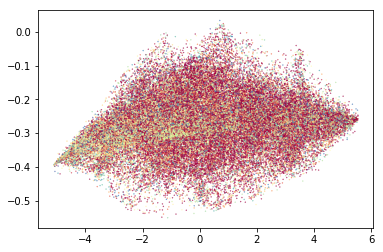

In [37]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=bounded_annotations_train, s=0.1, cmap='Spectral')

In [ ]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(imgs_flat)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=y_train, s=0.1, cmap='Spectral');

In [ ]:
kmeans_labels = cluster.KMeans(n_clusters=80).fit_predict(imgs_flat)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral');

In [ ]:
clustering_rand_score = adjusted_rand_score(y_train, kmeans_labels),
clustering_MI = adjusted_mutual_info_score(y_train, kmeans_labels)


In [ ]:
lowd_train = PCA(n_components=50).fit_transform(imgs_flat)
kmeans_labels_pca = cluster.KMeans(n_clusters=80).fit_predict(lowd_train)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels_pca, s=0.1, cmap='Spectral');
#hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(lowd_mnist)

In [ ]:
def findValueDictionary(dict,key,value, returnkey):
    for entry in dict:
        if entry[key] == value:
            return entry[returnkey]

image_id_string = str(image_id).zfill(12)
image = np.array(Image.open('data/train2014/COCO_train2014_'+ image_id_string +'.jpg'), dtype=np.uint8)

colors = np.random.random((len(categories)+10, 3))
i=0
bbox_list = []
item_list = []
fig,ax = plt.subplots(1)
ax.imshow(image)
for item in items:
    label = findValueDictionary(categories, 'id', item['category_id'], 'name')
    rect = patches.Rectangle((item['bbox'][0], (item['bbox'][1])), item['bbox'][2], item['bbox'][3],linewidth=1,edgecolor=colors[item['category_id']-1],facecolor='none', label= label)
    ax.add_patch(rect)
    bbox_list.append(rect)
    item_list.append(item['category_id'])
#print(items)
plt.figure(figsize=(3,4))
plt.legend(handles=bbox_list)
plt.show()

In [ ]:

'''
#testsplits = list(chunks(dummy_annotations, 50))
#labels, features = splitPreprocessing(testsplits, data_folder, path)

'''

categories_subset = [2,52]
bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
bbox_val = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, val_annotations),  os.path.join(data_folder, valpath))
imgs = bbox[0]
imgs_val = bbox_val[0]
y_train = bbox[1]
y_test = bbox_val[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))
    bbox_val = getBoundingBoxesAnnotations(findAnnotations(category_id, category, val_annotations),  os.path.join(data_folder, valpath))
    imgs_val = np.concatenate((imgs_val,bbox_val[0]))
    y_test = np.concatenate((y_test,bbox_val[1]))




In [ ]:
iterative_x_train, iterative_y_train, iterative_x_test, iterative_y_test = iterative_train_test_split(instances_train, labels_train, test_size = 0.999)
iterative_x_val, iterative_y_val, iterative_x_test, iterative_y_test = iterative_train_test_split(iterative_x_test, iterative_y_test, test_size = 0.999)

In [ ]:
iterative_split_train = []
for instance in iterative_x_train:
    iterative_split_train.append(itemsets[instance[0]])
iterative_split_val = []
for instance in iterative_x_test:
    iterative_split_val.append(itemsets[instance[0]])

In [ ]:
iterative_train_categories = np.zeros(100, dtype=object)
iterative_val_categories = np.zeros(100, dtype=object)
for subset in iterative_split_train:
    print(subset)
    for item in subset:
        iterative_train_categories[item] += 1

for subset in iterative_split_val:
    for item in subset:
        iterative_val_categories[item] += 1

iterative_train_categories = iterative_train_categories[iterative_train_categories != 0]
iterative_val_categories = iterative_val_categories[iterative_val_categories != 0]
for i in range(0, len(iterative_train_categories)):
    print(str(categories[i]["id"]) + categories[i]["name"] + ": " + str(iterative_train_categories[i]))
    iterative_train_categories[i] = (categories[i]["name"], iterative_train_categories[i])

for i in range(0, len(iterative_val_categories)):
    print(str(categories[i]["id"]) + categories[i]["name"] + ": " + str(iterative_val_categories[i]))
    iterative_val_categories[i] = (categories[i]["name"], iterative_val_categories[i])

plt.figure(1)
plt.subplot(211)
plt.plot([i[1] for i in iterative_train_categories])
plt.subplot(212)
plt.plot([i[1] for i in iterative_val_categories])

In [ ]:
mskf = MultilabelStratifiedKFold(n_splits=100, random_state=0)

for train_index, test_index in mskf.split(instances_train, labels_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_split, test_split = instances_train[train_index], instances_train[test_index]
    y_train_split, y_test_split = labels_train[train_index], labels_train[test_index]

In [ ]:
print(len(train_split))

In [ ]:
random_images_bboxes = []
random_images_bboxes_val = []
for image in rand_images[0]:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        random_images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for image in rand_images[1]:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        random_images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)

In [ ]:
image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)
image_id_val, images_val, bounded_annotations_val  = zip(*random_images_bboxes_val)
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))


In [ ]:
ax = plt.subplots(1, figsize=(8, 4))
ax.axis('off')
ax.imshow(images_train[1][3])

In [ ]:
images_train_stack = np.vstack(images_train)
images_val_stack = np.vstack(images_val)


In [ ]:
test_image = getPicture(iterative_x_train[0][0],path)
#print(test_image[1])
print(images_train_stack[0])

In [ ]:
images_bboxes = []
images_bboxes_val = []
for [image] in iterative_x_train:
    try:
        bbox = getPicture(image,path)
        images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for [image] in iterative_x_val:
    try:
        bbox = getPicture(image,path)
        images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)

image_id_train, images_train, bounded_annotations_train  = zip(*images_bboxes)
image_id_val, images_val, bounded_annotations_val  = zip(*images_bboxes_val)
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
#images_train_stack = np.vstack(images_train)
#images_val_stack = np.vstack(images_val)
full_picture_features = calculateFeatures(images_train)
full_picture_features_val = calculateFeatures(images_val)
np.set_printoptions(threshold=np.inf)
picture_features_svm = [np.concatenate((x,y)) for x,y in zip(full_picture_features[0], full_picture_features[1])]
picture_features_svm_val = [np.concatenate((x,y)) for x,y in zip(full_picture_features_val[0], full_picture_features_val[1])]

In [ ]:
iterative_y_train_bool = iterative_y_train == 1
iterative_y_val_bool = iterative_y_val == 1
print(iterative_y_train[2:20])

In [ ]:
svmHOG = svmFit(picture_features, bounded_annotations_train)
svmHOGResults = svmPredict(picture_features_val, bounded_annotations_val, svmHOG)


In [ ]:
#slidingWindow("000000002664")

In [ ]:
fit_rf = RandomForestClassifier(random_state=42)
param_dist = {'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(fit_rf, cv = 5,
                     param_grid=param_dist, 
                     n_jobs = 3)

cv_rf.fit(picture_features, bounded_annotations_train)
print('Best Parameters using grid search: \n', 
      cv_rf.best_params_)

In [ ]:
rfHOG = randomForestFit(picture_features, bounded_annotations_train, 500)
rfHOG_results = rfPredict(picture_features_val, bounded_annotations_val, rfHOG)

In [ ]:
print(rfHOG.feature_importances_)
print(rfHOG.oob_decision_function_)

In [ ]:
# width 578.2023976316078
# heigth 483.5494085111049

path = "data/train2014/COCO_train2014_"
def getPictures(itemsets, path, instance):
    images = []
    image_ids = []
    image_tags = []
    avg_width, avg_height = (0,0)
    try:
        for itemset in itemsets:
            print(itemset)
            print(itemsets[itemset])
            if(instance in itemsets[itemset]):
                image_id_string = str(itemset).zfill(12)
                image_ids.append(str(itemset))
                image = Image.open(path + image_id_string +'.jpg')
                processed_img = preProcessImage(image)
                image.close()
                resized_image = resize(processed_img, (350, 292),anti_aliasing=True)
                images.append(resized_image)
                image_tags.append(itemsets[itemset])
    except Exception as ex:
            print(ex)   
    return image_ids,images,image_tags

pictureData = getPictures(itemsets, path, 18)
#print(pictureData)

In [ ]:
def example_errors():
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)
categories_subset = [2,6,19]
bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
bbox_val = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, val_annotations),  os.path.join(data_folder, valpath))
imgs = bbox[0]
imgs_val = bbox_val[0]
y_train = bbox[1]
y_test = bbox_val[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))
    bbox_val = getBoundingBoxesAnnotations(findAnnotations(category_id, category, val_annotations),  os.path.join(data_folder, valpath))
    imgs_val = np.concatenate((imgs_val,bbox_val[0]))
    y_test = np.concatenate((y_test,bbox_val[1]))

#images = np.asarray(pictureData[1])

'''
#x_train, x_test, y_train, y_test = train_test_split(
#    imgs, y_train, test_size=0.25, random_state=42)
'''
x_train = imgs/255
x_test = imgs_val/255

'''
for (i,value) in enumerate(y_train):
    if value == 2:
        y_train[i] = 0
        continue
    if value == 6:
        y_train[i] = 1
        continue
    if value == 19:
        y_train[i] = 2
        continue
    if value == 20:
        y_train[i] = 3
        continue
    if value == 33:
        y_train[i] = 4
        continue
    if value == 46:
        y_train[i] = 5
        continue
    if value == 49:
        y_train[i] = 6
        continue
    if value == 55:
        y_train[i] = 7
        continue
for (i,value) in enumerate(y_test):
    if value == 2:
        y_test[i] = 0
        continue
    if value == 6:
        y_test[i] = 1
        continue
    if value == 19:
        y_test[i] = 2
        continue
    if value == 20:
        y_test[i] = 3
        continue
    if value == 33:
        y_test[i] = 4
        continue
    if value == 46:
        y_test[i] = 5
        continue
    if value == 49:
        y_test[i] = 6
        continue
    if value == 55:
        y_test[i] = 7
        continue
'''
datagen = ImageDataGenerator(
    zca_whitening=True, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train)
datagen_test = ImageDataGenerator(zca_whitening=True)
datagen_test.fit(x_test)         
ylabels_test = to_categorical(y_test)
ylabels_train = to_categorical(y_train)

#joblib.dump(value=ylabels_train, filename='outputs/ylabels_train2,6,19,20,33,46,49,55c.npy')
#joblib.dump(value=ylabels_test, filename='outputs/ylabels_test2,6,19,20,33,46,49,55c.npy')

In [ ]:
print(x_train[0:10])

In [ ]:
x_train = joblib.load('outputs/trainset2,6,19,20,33,46,49,55.npy')
x_test = joblib.load('outputs/testset2,6,19,20,33,46,49,55.npy')
#ylabels_train = joblib.load('outputs/y_trainlabels2,6,19,20,33,46.npy')
#ylabels_test = joblib.load('outputs/y_testlabels2,6,19,20,33,46.npy')

In [ ]:

datagen = ImageDataGenerator(
    featurewise_center=True, 
    zca_whitening=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train)
datagen_test = ImageDataGenerator(featurewise_center=True, 
    zca_whitening=True,)
datagen_test.fit(x_test)    

In [ ]:
sess = tf.Session()
early_stopping_monitor = EarlyStopping(patience = 3)



dense_layers = [1,2,3]
layer_sizes = [64]
dense_sizes = [64]
conv_layers = [1]
kernel_sizes = [3]
for dense_layer in dense_layers:
    for dense_size in dense_sizes:
        for kernel_size in kernel_sizes:
            for layer_size in layer_sizes:
                for conv_layer in conv_layers:
                    model = constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, True, 3, x_train)
                    NAME = "{}-conv-{}-nodes-{}-dense-{}-dense_size-{}-kernel-{}".format(conv_layer, layer_size, dense_layer, dense_size, kernel_size, int(time()))
                    print(NAME)
                    tensorboard = TensorBoard(log_dir="logs2,6,19,20,33,46,49,55c/{}".format(NAME))
                    #model.fit(x_train, ylabels_train.astype(np.float32), batch_size=70, epochs=100, validation_data = (x_test, ylabels_test), callbacks = [tensorboard],shuffle=True)
                    model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=32,shuffle=True), 
                                        epochs=15, callbacks = [early_stopping_monitor], validation_data = (x_test, ylabels_test))
                    
'''
y_pred = model.predict_classes(x_test)
true_preds = [(x,y) for (x,y,p) in zip(X_test, y_test, y_pred) if y == p]
false_preds = [(x,y,p) for (x,y,p) in zip(X_test, y_test, y_pred) if y != p]
print("Number of true predictions: ", len(true_preds))
print("Number of false predictions:", len(false_preds))

'''
'''
percent_noise = 0.1
noise = (1.0/255) * percent_noise
model = Sequential()
model.add(GaussianNoise(noise, input_shape=x_train.shape[1:]))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(8))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])
        
print("2x3x3x128,2x3x3x64,0.25,D64,0.25 model.fit")
model.fit(x_train, ylabels_train.astype(np.float32), batch_size=70, epochs=100, validation_data = (x_test, ylabels_test), callbacks = [],shuffle=True)
model.save_weights('model.h5')
print(model.summary())
'''

In [ ]:
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X, Y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    	print("%f (%f) with: %r" % (mean, stdev, param))

In [131]:
import argparse

import azureml.core
from azureml.core import Run
from collections import defaultdict
import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
from random import shuffle
from skimage import io as io
from skimage import exposure
from skimage.transform import resize, integral_image
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, corner_harris, corner_subpix, corner_peaks, daisy, hog, multiblock_lbp, haar_like_feature

from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_similarity_score, average_precision_score, f1_score, precision_score, hamming_loss, hinge_loss, recall_score
from sklearn.svm import SVC, LinearSVC
import itertools
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
#from skmultilearn.model_selection import iterative_train_test_split
import time

def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def zca_whitening_matrix(X):
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

def preProcessImage(img):
    img = np.asarray(img)
    img = rgb2gray(img)
    #img = cv2.GaussianBlur(img,(5,5),0)
    #img = cv2.medianBlur(img,5)
    #img = cv2.bilateralFilter(img,9,75,75)
    #img = cv2.blur(img,(5,5))
    #kernel = np.ones((5,5),np.float32)/25
    #img = cv2.filter2D(img,-1,kernel)
    return img

def noisy(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return out

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    for annotation in annotations:
        try:
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations


def calculateHogFeatures(gray_image, o, pixels, cells):
    features = hog(gray_image, orientations=o, 
                              pixels_per_cell=(pixels, pixels),
                              cells_per_block=(cells, cells), 
                              transform_sqrt=True, 
                              visualize=False, block_norm = "L2-Hys")
    return features
def calculateDaisyFeatures(gray_image):
    '''
    descs = daisy(gray_image, step=180, radius=8, rings=3, histograms=6,
                         orientations=8, visualize=False)
    '''
    descs = daisy(gray_image, step=180, radius=15, rings=3, histograms=8,
                         orientations=8, visualize=False)
    descs_num = descs.shape[0] * descs.shape[1]
    return descs.reshape(descs.size).tolist()

def calculateDoG(gray_image):
    blobs_dog = blob_dog(gray_image, max_sigma=30, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    return blobs_dog

def calculateSIFT(sift, gray_image):
    kp = sift.detect(gray_image,None)
    return kp

def calculateFeatures(imgs):
    #sift = cv2.xfeatures2d.SIFT_create()
    #detector = CENSURE()
    hog_features = []
    dog_features = []
    daisy_features = []
    harris_features = []
    lbp_features = []
    haar_features = []
    i = 0
    for img in imgs:
        hog_features.append(calculateHogFeatures(img,8,12,1))
        daisy_features.append(calculateDaisyFeatures(img))
        int_img = integral_image(img)
        lbp_features.append(multiblock_lbp(int_img, 0, 0, 30, 30))
        #haar_features.append(haar_like_feature(int_img, 0, 0, 24, 24))
        #shape_index_features.append(shape_index(img))
        #dog_features.append(calculateDoG(img))
        #harris_features.append(corner_peaks(corner_harris(img), min_distance=5))
        #sift_features.append(calculateSIFT(sift, img))
        print(i)
        i += 1
    return  hog_features, daisy_features, lbp_features#, haar_features

def svmFit(x_train, y_train):
    print("Fitting the classifier to train")
    #t0 = time()
    '''
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    '''
    clf = LinearSVC()
    clf = clf.fit(x_train, y_train)
    #print("Completed in %0.3fs" % (time() - t0))
    #print("Best estimator found by grid search:")
    #print(clf.best_estimator_)
    return clf

def saveModel(model, filename):
    print("Saving file...")
    joblib.dump(model, open(filename, 'wb'))
    print("File saved")
    
def loadModel(filename):
    print("loading file...")
    joblib.load(filename)
    print("Model loaded")
    
def svmPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_micro:", precision_score(y_test, y_pred, average = 'micro'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_micro:", recall_score(y_test, y_pred, average = 'micro'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'micro'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    
def randomForestFit(x_train, y_train, estimators):
    print("Fitting the classifier to train")
    #t0 = time()
    rf = RandomForestClassifier(n_estimators=estimators)
    rf.fit(x_train, y_train);
    #print("Completed in %0.3fs" % (time() - t0))
    return rf

def rfPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    errors = abs(y_pred - y_test)
    print("Errors:", errors)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_weighted:", precision_score(y_test, y_pred, average = 'weighted'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_weighted:", recall_score(y_test, y_pred, average = 'weighted'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

def splitPreprocessing(splits, data_folder, path):
    labels = []
    features = np.asarray([[],[]])
    for split in splits:
        bboxes = getBoundingBoxesAnnotations(split, os.path.join(data_folder, path))
        splitfeatures = calculateFeatures(bboxes[0])
        features = np.append(features, splitfeatures,1)
        labels.extend(bboxes[1])
    return labels, features.tolist()

def non_max_suppression_slow(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    no_overlap = []
 
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        no_overlap.append(i)
 
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    return boxes[pick].astype("int")

def IoU(box_1,box_2):
    x_a = max(box_1[0],box_2[0])
    y_a = max(box_1[1],box_2[1])
    x_b = min(box_1[2],box_2[2])
    y_b = min(box_1[3],box_2[3])
    
    overlap = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)
    box_1_area = (box_1[2] - box_1[0] + 1) * (box_1[3] - box_1[1] + 1)
    box_2_area = (box_2[2] - box_2[0] + 1) * (box_2[3] - box_2[1] + 1)
    IoU = overlap/float(box_1_area + box_2_area + overlap)
    return IoU

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list


def print_memory_usage(memory_variable):
    total, available, percent, used, free = psutil.virtual_memory()
    total, available, used, free = total / memory_variable, available / memory_variable, used / memory_variable, free / memory_variable
    proc = PROCESS.memory_info()[1] / memory_variable
    print('process = %s total = %s available = %s used = %s free = %s percent = %s'
          % (proc, total, available, used, free, percent))


path = "train2014/COCO_train2014_"
valpath = "val2014/val2014/COCO_val2014_"
category = "category_id"


train_annotations = train["annotations"]
#val_annotations = val["annotations"]

train_categories = np.zeros(100, dtype=object)
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
train_categories = train_categories[train_categories != 0]

labels = np.asarray(list(itemsets.values()))

keys = np.asarray(list(itemsets.keys()))
rand_sets,rand_images = random_sets(labels,keys,200)


random_images_bboxes = []
random_images_bboxes_val = []
for image in rand_images[0]:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        random_images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for image in rand_images[1]:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        random_images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
'''
multilabel_binarizer = MultiLabelBinarizer()
binarized = multilabel_binarizer.fit_transform(labels)
labels_train = np.array(binarized)
instances_train = np.array([[key] for key in keys])

iterative_x_train, iterative_y_train, iterative_x_test, iterative_y_test = iterative_train_test_split(instances_train, labels_train, test_size = 0.997)
iterative_x_val, iterative_y_val, iterative_x_test, iterative_y_test = iterative_train_test_split(iterative_x_test, iterative_y_test, test_size = 0.997

images_bboxes = []
images_bboxes_val = []
for [image] in iterative_x_train:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for [image] in iterative_x_val:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
'''

image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)
image_id_val, images_val, bounded_annotations_val  = zip(*random_images_bboxes_val)
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
print(images_train[0:10])
print(images_val[0:10])
'''
images_train_stack = np.vstack(images_train)
images_val_stack = np.vstack(images_val)
full_picture_features = calculateFeatures(images_train_stack)
full_picture_features_val = calculateFeatures(images_val_stack)
joblib.dump(value=full_picture_features, filename='outputs/stackedfeatures_all_HOG_DAISY_mlbp.npy')
joblib.dump(value=full_picture_features_val, filename='outputs/stackedfeatures_val_all_HOG_DAISY_mlbp.npy')
print("linear SVM random 100/50")


del images_train
del images_val
del images_train_stack
del images_val_stack
del image_id_train
del image_id_val

#joblib.dump(value=full_picture_features, filename='outputs/stackedfeatures_all_HOG_DAISY_mlbp0.1.npy')
#joblib.dump(value=full_picture_features_val, filename='outputs/stackedfeatures_val_all_HOG_DAISY_mlbp0.1.npy')
picture_features_svm = [np.concatenate((x,y)) for x,y in zip(full_picture_features[0], full_picture_features[1])]
picture_features_svm_val = [np.concatenate((x,y)) for x,y in zip(full_picture_features_val[0], full_picture_features_val[1])]

#picture_features_rf = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features[0], full_picture_features[1],full_picture_features[2])]
#picture_features_rf_val = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features_val[0], full_picture_features_val[1], full_picture_features_val[2])]

del full_picture_features
del full_picture_features_val
#svmrbf = svm_rbfFit(picture_features_svm, bounded_annotations_train)
#svmrbfResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svmrbf)
#joblib.dump(value=svmrbf, filename='outputs/svm_rbf_all_0.02random.npy')
svm = svmFit(picture_features_svm, bounded_annotations_train)
svmResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svm)
joblib.dump(value=svmResults, filename='outputs/confusion_matrix_svm_all_100/50random.npy')
joblib.dump(value=svm, filename='outputs/svm_lin_all_100/50random.npy')

'''
'''
categories_subset = [2,6]
bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
bbox_val = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, val_annotations),  os.path.join(data_folder, valpath))
imgs = bbox[0]
imgs_val = bbox_val[0]
y_train = bbox[1]
y_test = bbox_val[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))
    bbox_val = getBoundingBoxesAnnotations(findAnnotations(category_id, category, val_annotations),  os.path.join(data_folder, valpath))
    imgs_val = np.concatenate((imgs_val,bbox_val[0]))
    y_test = np.concatenate((y_test,bbox_val[1]))
    
joblib.dump(value=imgs, filename='outputs/bounded_imgs2,6,19,20,33,46,49,55.npy')
joblib.dump(value=imgs_val, filename='outputs/bounded_imgs_val2,6,19,20,33,46,49,55.npy')
features = calculateFeatures(imgs)
features_val = calculateFeatures(imgs_val)
joblib.dump(value=features, filename='outputs/features2,6,19,20,33,46,49,55.npy')
joblib.dump(value=features_val, filename='outputs/features_val2,6,19,20,33,46,49,55.npy')
features_concat = [np.concatenate((x,y,z,a)) for x,y,z,a in zip(features[0], features[1], features[2], features[3])]
features_val_concat = [np.concatenate((x,y,z,a)) for x,y,z,a in zip(features_val[0], features_val[1], features_val[2],features_val[3])]
print("SVM")
svm = svmFit(features_concat, y_train)
svm_results = svmPredict(features_val_concat, y_test, svm)
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=svm, filename='outputs/SVM.pkl')
print("RF")
rf = randomForestFit(features_concat, y_train, 1000)
rf_results = rfPredict(features_val_concat, y_test, rfHOG)
joblib.dump(value=rf, filename='outputs/rf.pkl')
'''

c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


KeyboardInterrupt: 

In [172]:
%%writefile $script_folder/train.py

import argparse

import azureml.core
from azureml.core import Run
from collections import defaultdict
import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
from random import shuffle, seed
from skimage import io as io
from skimage import exposure
from skimage.transform import resize, integral_image
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, corner_harris, corner_subpix, corner_peaks, daisy, hog, multiblock_lbp, haar_like_feature
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_similarity_score, average_precision_score, f1_score, precision_score, hamming_loss, hinge_loss, recall_score
from sklearn.svm import SVC, LinearSVC
import itertools
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.dummy import DummyClassifier
import time

def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def zca_whitening_matrix(X):
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

def preProcessImage(img):
    img = np.asarray(img)
    img = rgb2gray(img)
    #img = cv2.GaussianBlur(img,(5,5),0)
    #img = cv2.medianBlur(img,5)
    #img = cv2.bilateralFilter(img,9,75,75)
    #img = cv2.blur(img,(5,5))
    #kernel = np.ones((5,5),np.float32)/25
    #img = cv2.filter2D(img,-1,kernel)
    return img

def noisy(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return out

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    for annotation in annotations:
        try:
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations


def calculateHogFeatures(gray_image, o, pixels, cells):
    features = hog(gray_image, orientations=o, 
                              pixels_per_cell=(pixels, pixels),
                              cells_per_block=(cells, cells), 
                              transform_sqrt=True, 
                              visualize=False, block_norm = "L2-Hys")
    return features
def calculateDaisyFeatures(gray_image):
    '''
    descs = daisy(gray_image, step=180, radius=8, rings=3, histograms=6,
                         orientations=8, visualize=False)
    '''
    descs = daisy(gray_image, step=180, radius=15, rings=3, histograms=8,
                         orientations=8, visualize=False)
    descs_num = descs.shape[0] * descs.shape[1]
    return descs.reshape(descs.size).tolist()

def calculateDoG(gray_image):
    blobs_dog = blob_dog(gray_image, max_sigma=30, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    return blobs_dog

def calculateSIFT(sift, gray_image):
    kp = sift.detect(gray_image,None)
    return kp

def calculateFeatures(imgs):
    #sift = cv2.xfeatures2d.SIFT_create()
    #detector = CENSURE()
    hog_features = []
    dog_features = []
    daisy_features = []
    harris_features = []
    lbp_features = []
    haar_features = []
    for img in imgs:
        hog_features.append(calculateHogFeatures(img,8,12,1))
        daisy_features.append(calculateDaisyFeatures(img))
        int_img = integral_image(img)
        lbp_features.append(multiblock_lbp(int_img, 0, 0, 30, 30))
        #haar_features.append(haar_like_feature(int_img, 0, 0, 24, 24))
        #shape_index_features.append(shape_index(img))
        #dog_features.append(calculateDoG(img))
        #harris_features.append(corner_peaks(corner_harris(img), min_distance=5))
        #sift_features.append(calculateSIFT(sift, img))
    return  hog_features, daisy_features, lbp_features#, haar_features

def svmFit(x_train, y_train):
    print("Fitting the classifier to train")
    '''
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    '''
    clf = LinearSVC()
    clf = clf.fit(x_train, y_train)
    #print("Best estimator found by grid search:")
    #print(clf.best_estimator_)
    return clf

def svm_rbfFit(x_train, y_train):
    print("Fitting the classifier to train")
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5)
    clf = clf.fit(x_train, y_train)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    return clf

def saveModel(model, filename):
    print("Saving file...")
    joblib.dump(model, open(filename, 'wb'))
    print("File saved")
    
def loadModel(filename):
    print("loading file...")
    joblib.load(filename)
    print("Model loaded")
    
def svmPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_micro:", precision_score(y_test, y_pred, average = 'micro'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_micro:", recall_score(y_test, y_pred, average = 'micro'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    return conf_mat
    
def randomForestFit(x_train, y_train, estimators):
    print("Fitting the classifier to train")
    #t0 = time()
    rf = RandomForestClassifier(n_estimators=estimators)
    rf.fit(x_train, y_train);
    #print("Completed in %0.3fs" % (time() - t0))
    return rf

def rfPredict(x_test, y_test, model):
    print("Predicting the test set")
    #t0 = time()
    y_pred = model.predict(x_test)
    #print("Completed in %0.3fs" % (time() - t0))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision_weighted:", precision_score(y_test, y_pred, average = 'weighted'))
    print("Precision_macro:", precision_score(y_test, y_pred, average = 'macro'))
    print("Recall_weighted:", recall_score(y_test, y_pred, average = 'weighted'))
    print("Recall_macro:", recall_score(y_test, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(y_test, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(y_test, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_mat = confusion_matrix(y_test, y_pred)
    print(conf_mat)
    return conf_mat
    
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

def splitPreprocessing(splits, data_folder, path):
    labels = []
    features = np.asarray([[],[]])
    for split in splits:
        bboxes = getBoundingBoxesAnnotations(split, os.path.join(data_folder, path))
        splitfeatures = calculateFeatures(bboxes[0])
        features = np.append(features, splitfeatures,1)
        labels.extend(bboxes[1])
    return labels, features.tolist()

def non_max_suppression_slow(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    no_overlap = []
 
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        no_overlap.append(i)
 
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    return boxes[pick].astype("int")

def IoU(box_1,box_2):
    x_a = max(box_1[0],box_2[0])
    y_a = max(box_1[1],box_2[1])
    x_b = min(box_1[2],box_2[2])
    y_b = min(box_1[3],box_2[3])
    
    overlap = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)
    box_1_area = (box_1[2] - box_1[0] + 1) * (box_1[3] - box_1[1] + 1)
    box_2_area = (box_2[2] - box_2[0] + 1) * (box_2[3] - box_2[1] + 1)
    IoU = overlap/float(box_1_area + box_2_area + overlap)
    return IoU

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    seed(42)
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list

def getBoundingBoxPreselected(annotations, path):
    bounded_images = []
    bounded_annotations = []
    for annotation in annotations:
        try:
            image_id = annotation[0]
            image_id_string = str(image_id).zfill(12)
            image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image)
            image_resized = resize(getBoundingBox(int(annotation[1][0]),int(annotation[1][1]),int(annotation[1][2]),int(annotation[1][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation[2]) 
        except Exception as ex:
                print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images, bounded_annotations



parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
args = parser.parse_args()
data_folder = os.path.join(args.data_folder, 'data')
outputs_folder = os.path.join(args.data_folder, 'outputs')
print('Data folder:', data_folder)
print('output folder:', outputs_folder)
run = Run.get_context()

'''
path = "train2014/COCO_train2014_"
valpath = "val2014/COCO_val2014_"
category = "category_id"

with open(os.path.join(data_folder, "annotations/instances_train2014.json")) as read_file:
    train = json.load(read_file)

#with open(os.path.join(data_folder, "annotations/instances_val2014.json")) as read_file:
#    val = json.load(read_file)
print("dummy random 0.98")
train_annotations = train["annotations"]
#val_annotations = val["annotations"]
'''
'''
bbox_category_ids = []
bboxes = []
for annotation in train_annotations:
    bbox_category_ids.append(annotation['category_id'])
    bboxes.append((annotation['image_id'],annotation['bbox'],annotation['category_id']))
train_split_strat_x, test_split_strat_x, bounded_annotations_train, bounded_annotations_val= train_test_split(bboxes,bbox_category_ids,test_size=0.1,train_size=0.1, stratify=bbox_category_ids)
images_train, bounded_annotations_train = getBoundingBoxPreselected(train_split_strat_x, path)
images_val, bounded_annotations_val = getBoundingBoxPreselected(test_split_strat_x, path)

full_picture_features = calculateFeatures(images_train)
del images_train
full_picture_features_val = calculateFeatures(images_val)
del images_val
'''
'''
train_categories = np.zeros(100, dtype=object)
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
train_categories = train_categories[train_categories != 0]
del train_categories
labels = np.asarray(list(itemsets.values()))

keys = np.asarray(list(itemsets.keys()))
del itemsets

rand_sets,rand_images = random_sets(labels,keys,200)
del labels
del keys

random_images_bboxes = []
random_images_bboxes_val = []
for imageset in rand_images[0:20]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
for imageset in rand_images[20:40]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes_val.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
del rand_images
image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)
del image_id_train
del random_images_bboxes
image_id_val, images_val, bounded_annotations_val  = zip(*random_images_bboxes_val)
del image_id_val
del random_images_bboxes_val
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
images_train_stack = np.vstack(images_train)
del images_train
images_val_stack = np.vstack(images_val)
del images_val

strategies = ['stratified','most_frequent','prior','uniform']
for strat in strategies:
    clf = DummyClassifier(strategy=strat, random_state=42)
    clf.fit(images_train_stack, bounded_annotations_train)
    DummyClassifier(constant=None, random_state=42, strategy=strat)
    print(clf.score(images_val_stack, bounded_annotations_val))
    y_pred = clf.predict(images_val_stack)
    print("Accuracy:", accuracy_score(bounded_annotations_val, y_pred))
    print("Precision_weighted:", precision_score(bounded_annotations_val, y_pred, average = 'weighted'))
    print("Precision_macro:", precision_score(bounded_annotations_val, y_pred, average = 'macro'))
    print("Recall_weighted:", recall_score(bounded_annotations_val, y_pred, average = 'weighted'))
    print("Recall_macro:", recall_score(bounded_annotations_val, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(bounded_annotations_val, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(bounded_annotations_val, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(bounded_annotations_val, y_pred))
'''   
'''
full_picture_features = calculateFeatures(images_train_stack)
del images_train_stack
full_picture_features_val = calculateFeatures(images_val_stack)
del images_val_stack
'''
'''
multilabel_binarizer = MultiLabelBinarizer()
binarized = multilabel_binarizer.fit_transform(labels)
labels_train = np.array(binarized)
instances_train = np.array([[key] for key in keys])

iterative_x_train, iterative_y_train, iterative_x_test, iterative_y_test = iterative_train_test_split(instances_train, labels_train, test_size = 0.97)
iterative_x_val, iterative_y_val, iterative_x_test, iterative_y_test = iterative_train_test_split(iterative_x_test, iterative_y_test, test_size = 0.97)

del multilabel_binarizer
del instances_train
del binarized
del labels_train

images_bboxes = []
images_bboxes_val = []
for [image] in iterative_x_train:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for [image] in iterative_x_val:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
del iterative_x_train
del iterative_y_train
del iterative_x_test
del iterative_y_test
del iterative_x_val
del iterative_y_val

image_id_train, images_train, bounded_annotations_train  = zip(*images_bboxes)
del images_bboxes
del image_id_train
image_id_val, images_val, bounded_annotations_val  = zip(*images_bboxes_val)
del images_bboxes_val
del image_id_val
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
images_train_stack = np.vstack(images_train)
del images_train
images_val_stack = np.vstack(images_val)
del images_val
full_picture_features = calculateFeatures(images_train_stack)
del images_train_stack
full_picture_features_val = calculateFeatures(images_val_stack)
del images_val_stack

'''
images_train = joblib.load(os.path.join(outputs_folder, 'images_train_stack_all_0,95rand.npy'))
images_val = joblib.load(os.path.join(outputs_folder, 'images_val_0,95rand.npy'))
bounded_annotations_train = joblib.load(os.path.join(outputs_folder, 'bounded_annotations_train_0,95rand.npy'))
bounded_annotations_val = joblib.load(os.path.join(outputs_folder, 'bounded_annotations_val_0,95rand.npy'))
images_train_gray = []
images_val_gray = []
for img in images_train:
    images_train_gray.append(rgb2gray(img))
del images_train
for img in images_val:
    images_val_gray.append(rgb2gray(img))
del images_val
full_picture_features = calculateFeatures(images_train_gray)

full_picture_features_val = calculateFeatures(images_val_gray)


np.set_printoptions(threshold=np.inf)
#joblib.dump(value=full_picture_features, filename='outputs/stackedfeatures_all_HOG_DAISY_mlbp0.1.npy')
#joblib.dump(value=full_picture_features_val, filename='outputs/stackedfeatures_val_all_HOG_DAISY_mlbp0.1.npy')
picture_features_svm = [np.concatenate((x,y)) for x,y in zip(full_picture_features[0], full_picture_features[1])]
picture_features_svm_val = [np.concatenate((x,y)) for x,y in zip(full_picture_features_val[0], full_picture_features_val[1])]

svm = svmFit(picture_features_svm, bounded_annotations_train)
svmResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svm)
joblib.dump(value=svm, filename='outputs/svm_rand_0,95.npy')
joblib.dump(value=svmResults, filename='outputs/svm_rand_confusion_matrix_0,95.npy')

del picture_features_svm
del picture_features_svm_val

picture_features_rf = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features[0], full_picture_features[1],full_picture_features[2])]
picture_features_rf_val = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features_val[0], full_picture_features_val[1], full_picture_features_val[2])]

del full_picture_features
del full_picture_features_val
#svmrbf = svm_rbfFit(picture_features_svm, bounded_annotations_train)
#svmrbfResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svmrbf)
#joblib.dump(value=svmrbf, filename='outputs/svm_rbf_all_0.02random.npy')



try:
    rf = randomForestFit(picture_features_rf, bounded_annotations_train, 300)
except Exception as ex:
    print(ex)
try:
    rf_conf = rfPredict(picture_features_rf_val, bounded_annotations_val, rf)
except Exception as ex:
    print(ex)
joblib.dump(value=rf, filename='outputs/rf_rand_0,95_300trees.npy')
joblib.dump(value=rf_conf, filename='outputs/conf_mat_rf_rand_0,95_300trees.npy')

'''
categories_subset = [2,6]
bbox = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, train_annotations),  os.path.join(data_folder, path))
bbox_val = getBoundingBoxesAnnotations(findAnnotations(categories_subset[0], category, val_annotations),  os.path.join(data_folder, valpath))
imgs = bbox[0]
imgs_val = bbox_val[0]
y_train = bbox[1]
y_test = bbox_val[1]
categories_subset.pop(0)
for category_id in categories_subset:
    bbox = getBoundingBoxesAnnotations(findAnnotations(category_id, category, train_annotations),  os.path.join(data_folder, path))
    imgs = np.concatenate((imgs,bbox[0]))
    y_train = np.concatenate((y_train,bbox[1]))
    bbox_val = getBoundingBoxesAnnotations(findAnnotations(category_id, category, val_annotations),  os.path.join(data_folder, valpath))
    imgs_val = np.concatenate((imgs_val,bbox_val[0]))
    y_test = np.concatenate((y_test,bbox_val[1]))
    
joblib.dump(value=imgs, filename='outputs/bounded_imgs2,6,19,20,33,46,49,55.npy')
joblib.dump(value=imgs_val, filename='outputs/bounded_imgs_val2,6,19,20,33,46,49,55.npy')
features = calculateFeatures(imgs)
features_val = calculateFeatures(imgs_val)
joblib.dump(value=features, filename='outputs/features2,6,19,20,33,46,49,55.npy')
joblib.dump(value=features_val, filename='outputs/features_val2,6,19,20,33,46,49,55.npy')
features_concat = [np.concatenate((x,y,z,a)) for x,y,z,a in zip(features[0], features[1], features[2], features[3])]
features_val_concat = [np.concatenate((x,y,z,a)) for x,y,z,a in zip(features_val[0], features_val[1], features_val[2],features_val[3])]
print("SVM")
svm = svmFit(features_concat, y_train)
svm_results = svmPredict(features_val_concat, y_test, svm)
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=svm, filename='outputs/SVM.pkl')
print("RF")
rf = randomForestFit(features_concat, y_train, 1000)
rf_results = rfPredict(features_val_concat, y_test, rfHOG)
joblib.dump(value=rf, filename='outputs/rf.pkl')
'''


Overwriting ./coco-multi-label/train.py


In [41]:
%%writefile $script_folder/neural_network.py

import argparse

import azureml.core
from azureml.core import Run
from collections import defaultdict
import itertools
import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
import keras
import keras.backend as K
from random import shuffle, seed
from skimage.transform import resize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_similarity_score, average_precision_score, f1_score, precision_score, hamming_loss, hinge_loss, recall_score, roc_curve
from sklearn.externals import joblib
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import TomekLinks
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation, Flatten, Dropout, GaussianNoise, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD
import time



def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def preProcessImage(img):
    img = np.asarray(img)
    return img

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    for annotation in annotations:
        try:
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations


def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def precision(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))

    # How many selected items are relevant?
    precision = c1 / c2

    return precision

def recall(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many relevant items are selected?
    recall = c1 / c3

    return recall

def constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, dropout, num_classes, x_train):
    percent_noise = 0.1
    noise = (1.0/255) * percent_noise
    model = Sequential()
    model.add(GaussianNoise(noise, input_shape=x_train.shape[1:]))
    model.add(Conv2D(layer_size, (kernel_size, kernel_size)))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for l in range(conv_layer-1):
        model.add(Conv2D(layer_size, (kernel_size, kernel_size)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Flatten())

    for j in range(dense_layer):
        model.add(Dense(dense_size))
        model.add(Activation('relu'))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])

    return model

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    seed(42)
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list


def equalClassSizes(annotations, number_instances, path):
    bounded_images = []
    bounded_annotations = []
    image_ids = []
    instance_counts = [0] * 91
    seed(42)
    shuffle(annotations)
    for annotation in annotations:
        if instance_counts[annotation['category_id']] < number_instances:
            try:
                image_id = annotation['image_id']
                image_id_string = str(image_id).zfill(12)
                image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
                image = preProcessImage(image) 
                image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                       , (104, 107),
                               anti_aliasing=True)
                bounded_images.append(image_resized)
                bounded_annotations.append(annotation['category_id'])   
                image_ids.append(image_id)
                instance_counts[annotation['category_id']] +=1
            except Exception as ex:
                    print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    image_ids = np.asarray(image_ids)
    return image_ids,bounded_images,bounded_annotations

def getBoundingBoxPreselected(annotations, path):
    bounded_images = []
    bounded_annotations = []
    for annotation in annotations:
        try:
            image_id = annotation[0]
            image_id_string = str(image_id).zfill(12)
            image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image)
            image_resized = resize(getBoundingBox(int(annotation[1][0]),int(annotation[1][1]),int(annotation[1][2]),int(annotation[1][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation[2]) 
        except Exception as ex:
                print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images, bounded_annotations

parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
args = parser.parse_args()
data_folder = os.path.join(args.data_folder, 'data')
outputs_folder = os.path.join(args.data_folder, 'outputs')
print('Data folder:', data_folder)
print('output folder:', outputs_folder)
run = Run.get_context()

path = "train2014/COCO_train2014_"
valpath = "val2014/val2014/COCO_val2014_"
category = "category_id"

with open(os.path.join(data_folder, "annotations/instances_train2014.json")) as read_file:
    train = json.load(read_file)
train_annotations = train["annotations"]
del train

'''
with open(os.path.join(data_folder, "annotations/instances_val2014.json")) as read_file:
    val = json.load(read_file)
val_annotations = val["annotations"]
del val
images_bboxes_equal = equalClassSizes(train_annotations,100, path)
images_train = images_bboxes_equal[1]
bounded_annotations_train = images_bboxes_equal[2]
#del images_bboxes_equal
images_bboxes_equal_val = equalClassSizes(val_annotations,100, valpath)
images_val = images_bboxes_equal_val[1]
bounded_annotations_val = images_bboxes_equal_val[2]
'''


bbox_category_ids = []
bboxes = []
for annotation in train_annotations:
    bbox_category_ids.append(annotation['category_id'])
    bboxes.append((annotation['image_id'],annotation['bbox'],annotation['category_id']))
train_split_strat_x, test_split_strat_x, bounded_annotations_train, bounded_annotations_val= train_test_split(bboxes,bbox_category_ids,test_size=0.01,train_size=0.01, stratify=bbox_category_ids)
images_train, bounded_annotations_train = getBoundingBoxPreselected(train_split_strat_x, path)
images_val, bounded_annotations_val = getBoundingBoxPreselected(test_split_strat_x, path)

'''
joblib.dump(value=images_train, filename='outputs/images_train_strat_0,925rand.npy')
joblib.dump(value=images_val, filename='outputs/images_val_strat_0,925rand.npy')
joblib.dump(value=bounded_annotations_train, filename='outputs/bounded_annotations_train_strat_0,925rand.npy')
joblib.dump(value=bounded_annotations_val, filename='outputs/bounded_annotations_val_strat_0,925rand.npy')
'''
'''
train_categories = np.zeros(100, dtype=object)
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
train_categories = train_categories[train_categories != 0]
del train_categories
labels = np.asarray(list(itemsets.values()))

keys = np.asarray(list(itemsets.keys()))
del itemsets
'''
'''
rand_sets,rand_images = random_sets(labels,keys,200)
del labels
del keys

random_images_bboxes = []
random_images_bboxes_val = []
for imageset in rand_images[0:30]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
for image in rand_images[30:60]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes_val.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
print("bboxes finished")
del rand_images
image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)
del image_id_train
del random_images_bboxes
image_id_val, images_val, bounded_annotations_val  = zip(*random_images_bboxes_val)
del image_id_val
del random_images_bboxes_val
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
images_train_stack = np.vstack(images_train)
del images_train
images_val_stack = np.vstack(images_val)
del images_val
'''

'''
multilabel_binarizer = MultiLabelBinarizer()
binarized = multilabel_binarizer.fit_transform(labels)
labels_train = np.array(binarized)
instances_train = np.array([[key] for key in keys])
del labels
del keys
iterative_x_train, iterative_y_train, iterative_x_test, iterative_y_test = iterative_train_test_split(instances_train, labels_train, test_size = 0.8)
iterative_x_val, iterative_y_val, iterative_x_test, iterative_y_test = iterative_train_test_split(iterative_x_test, iterative_y_test, test_size = 0.8)

del multilabel_binarizer
del instances_train
del binarized
del labels_train

images_bboxes = []
images_bboxes_val = []
for [image] in iterative_x_train:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for [image] in iterative_x_val:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
del iterative_x_train
del iterative_y_train
del iterative_x_test
del iterative_y_test
del iterative_x_val
del iterative_y_val

image_id_train, images_train, bounded_annotations_train  = zip(*images_bboxes)
del images_bboxes
del image_id_train
image_id_val, images_val, bounded_annotations_val  = zip(*images_bboxes_val)
del images_bboxes_val
del image_id_val
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
images_train_stack = np.vstack(images_train)
del images_train
images_val_stack = np.vstack(images_val)
del images_val
'''
'''
x_train = joblib.load(os.path.join(data_folder, 'trainset2,6,19,20,33,46,49,55c.npy'))
x_test = joblib.load(os.path.join(data_folder, 'testset2,6,19,20,33,46,49,55c.npy'))
ylabels_train = joblib.load(os.path.join(data_folder, 'ylabels_train2,6,19,20,33,46,49,55.npy'))
ylabels_test = joblib.load(os.path.join(data_folder, 'ylabels_test2,6,19,20,33,46,49,55.npy'))
'''
#joblib.dump(value=images_train_stack, filename='outputs/images_train_stack_all_0,99rand.npy')
#joblib.dump(value=images_val_stack, filename='outputs/images_val_stack_all_0,99rand.npy')
#joblib.dump(value=bounded_annotations_train, filename='outputs/bounded_annotations_train_all_0,99rand.npy')
#joblib.dump(value=bounded_annotations_train, filename='outputs/bounded_annotations_train_all_0,99rand.npy')

'''
datagen = ImageDataGenerator(
    featurewise_center=True, 
    zca_whitening=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train)
print("datagen train")
datagen_test = ImageDataGenerator(featurewise_center=True, 
    zca_whitening=True,)
datagen_test.fit(x_test)
print("datagen test")
'''
'''
images_bboxes_equal = equalClassSizes(train_annotations,100, path)
images_bboxes_equal_val = equalClassSizes(val_annotations,100, valpath)

images_train_stack = images_bboxes_equal[1]
bounded_annotations_train = list(images_bboxes_equal[2])
images_val_stack = images_bboxes_equal_val[1]
bounded_annotations_val = list(images_bboxes_equal_val[2])
'''
'''
x_train = images_train_stack/255
x_test = images_val_stack/255
'''

'''
images_train = joblib.load(os.path.join(outputs_folder, 'images_train_stack_all_0,95rand.npy'))
images_val = joblib.load(os.path.join(outputs_folder, 'images_val_0,95rand.npy'))
bounded_annotations_train = joblib.load(os.path.join(outputs_folder, 'bounded_annotations_train_0,95rand.npy'))
bounded_annotations_val = joblib.load(os.path.join(outputs_folder, 'bounded_annotations_val_0,95rand.npy'))
'''
print(images_train.shape)
print(images_train.shape[0])
dataset_size = images_train.shape[0]
TwoDim_dataset = images_train.reshape(dataset_size,-1)
tl = TomekLinks()
X_res_tm, y_res_tm = tl.fit_resample(TwoDim_dataset, bounded_annotations_train)
x_res_3d = X_res_tm.reshape(X_res_tm.shape[0], 104, 107, 3)

images_train = x_res_3d
bounded_annotations_train = y_res_tm

x_train = images_train/255
x_test = images_val/255
print("divided by 255")
corrected_ids = [-1,0,1,2,3,4,5,6,7,8,9,10,-1,11,12,13,14,15,16,17,18,19,20,21,22,23,-1,24,25,-1,-1,26,27,28,29,30,31,32,33,34,35,36,37,38,39,-1,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,-1,60,-1,-1,61,-1,62,63,64,65,66,67,68,69,70,71,72,-1,73,74,75,76,77,78,79]
for index, item in enumerate(bounded_annotations_train):
    bounded_annotations_train[index] = corrected_ids[bounded_annotations_train[index]]
for index, item in enumerate(bounded_annotations_val):
    bounded_annotations_val[index] = corrected_ids[bounded_annotations_val[index]]
#joblib.dump(value=bounded_annotations_train, filename='outputs/bounded_annotations_train_0,9rand.npy')
#joblib.dump(value=bounded_annotations_val, filename='outputs/bounded_annotations_val_0,9rand.npy')
ylabels_train = to_categorical(bounded_annotations_train)
ylabels_test = to_categorical(bounded_annotations_val)
print("to_categorical")
print("1% tomek NN")
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    early_stopping_monitor = EarlyStopping(patience = 5)
    np.set_printoptions(threshold=np.inf)
    dense_layers = [3]
    layer_sizes = [128]
    dense_sizes = [128]
    conv_layers = [3]
    kernel_sizes = [3]
    for dense_layer in dense_layers:
        for dense_size in dense_sizes:
            for kernel_size in kernel_sizes:
                for layer_size in layer_sizes:
                    for conv_layer in conv_layers:
                        model = constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, True, len(ylabels_train[0]), x_train)
                        NAME = "{}-conv-{}-nodes-{}-dense-{}-dense_size-{}-kernel".format(conv_layer, layer_size, dense_layer, dense_size, kernel_size)
                        print(NAME)
                        tensorboard = TensorBoard(log_dir="outputs/{}".format(NAME))
                        model.fit(x_train, ylabels_train.astype(np.float32), batch_size=70, epochs=100, validation_data = (x_test, ylabels_test), callbacks = [tensorboard],shuffle=True)
                        y_pred = model.predict(x_test)
                        #print(y_pred)
                        #print(y_pred_rounded)
                        #confusion = tf.confusion_matrix(labels=ylabels_test, predictions=y_pred_rounded)
                        #print(confusion)
                        predictions = tf.argmax(y_pred,1)
                        true_class = tf.argmax(ylabels_test, 1)
                        true_class_list = true_class.eval()
                        predictions_list = predictions.eval()
                        print(classification_report(true_class_list, predictions_list, digits=3))
                        con_mat = tf.confusion_matrix(true_class, predictions)
                        print('Confusion Matrix: \n\n', tf.Tensor.eval(con_mat,feed_dict=None, session=None))
                        #cm = confusion_matrix(ylabels_test, list(predictions))
                        #print(cm)
                        '''
                        model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=32,shuffle=True), 
                        epochs=10, callbacks = [tensorboard], validation_data = datagen_test.flow(x_test, ylabels_test, shuffle=True))
                        confusion = tf.confusion_matrix(labels=y_, predictions=y, num_classes=num_classes)
                        '''
                        #model = run.register_model(model_name='sklearn_mnist', model_path='outputs/sklearn_mnist_model.pkl')
                        #model.save('outputs/' + NAME +'0.925_tomek_100epochs.h5')
'''
percent_noise = 0.1
noise = (1.0/255) * percent_noise
model = Sequential()
model.add(GaussianNoise(noise, input_shape=x_train.shape[1:]))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(8))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])
        
print("2x3x3x128,2x3x3x64,0.25,D64,0.25 model.fit")
model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=32,shuffle=True), 
                    epochs=100, callbacks = [], validation_data = datagen_test.flow(x_test, ylabels_test, shuffle=True))
'''

Overwriting ./coco-multi-label/neural_network.py


In [42]:
import shutil
shutil.copy('utils.py', script_folder)

'./coco-multi-label\\utils.py'

In [43]:
from azureml.train.estimator import Estimator


script_params = {
    '--data-folder': ds.as_mount(),
}

'''
est = Estimator(source_directory=script_folder,
                script_params=script_params,
                compute_target=compute_target,
                entry_script='train.py',
                conda_packages=['scikit-learn', 'scikit-image', 'pillow', 'opencv', 'numpy'],
                pip_packages=['scikit-multilearn'])

run = exp.submit(config=est)
run
'''

keras_est = TensorFlow(source_directory=script_folder,
                       script_params=script_params,
                       compute_target=compute_target,
                       entry_script='neural_network.py',
                       pip_packages=['keras', 'scikit-learn', 'scikit-image', 'pillow', 'numpy', 'scikit-multilearn'],
                        use_gpu=True)

run = exp.submit(config=keras_est)
run

'''
from azureml.widgets import RunDetails
RunDetails(run).show()

run.wait_for_completion(show_output=True) # specify True for a verbose log

print(run.get_metrics())

print(run.get_file_names())
'''
# register model 
#model = run.register_model(model_name='svm_hog', model_path='outputs/svm_hog.pkl')
#print(model.name, model.id, model.version, sep = '\t')

'\nfrom azureml.widgets import RunDetails\nRunDetails(run).show()\n\nrun.wait_for_completion(show_output=True) # specify True for a verbose log\n\nprint(run.get_metrics())\n\nprint(run.get_file_names())\n'

In [ ]:
for r in exp.get_runs():  
    print(r.id, r.get_status())
    if r.get_status() not in ['Complete', 'Failed']:
        r.cancel()

# if you know the run id, you can "rehydrate" the run
from azureml.core import get_run
#r = get_run(experiment=exp, run_id="multi-class_classification_1552234551_7c1e71ae", rehydrate=True)
# check the returned run type and status
print(type(r), r.get_status())

# you can cancel a run if it hasn't completed or failed
#if r.get_status() not in ['Complete', 'Failed']:
    #r.cancel()

In [43]:
print(images_train)

[[[[0.01992471 0.02656627 0.03154745]
   [0.03118353 0.03423137 0.03889412]
   [0.0406     0.029      0.02843137]
   ...
   [0.26213725 0.24337255 0.22381176]
   [0.25690588 0.24337255 0.22799686]
   [0.18596392 0.17766196 0.16769961]]

  [[0.02542118 0.0338949  0.0402502 ]
   [0.03978588 0.04367451 0.04962353]
   [0.0518     0.037      0.03627451]
   ...
   [0.33445098 0.3105098  0.28555294]
   [0.32777647 0.3105098  0.29089255]
   [0.23726431 0.22667216 0.21396157]]

  [[0.03091765 0.04122353 0.04895294]
   [0.04838824 0.05311765 0.06035294]
   [0.063      0.045      0.04411765]
   ...
   [0.40676471 0.37764706 0.34729412]
   [0.39864706 0.37764706 0.35378824]
   [0.28856471 0.27568235 0.26022353]]

  ...

  [[0.01288235 0.02576471 0.01545882]
   [0.02301176 0.03730588 0.02452941]
   [0.036      0.04217647 0.03264706]
   ...
   [0.18670588 0.06052941 0.00864706]
   [0.14449412 0.07514118 0.02001176]
   [0.09275294 0.05925882 0.01803529]]

  [[0.01059216 0.02118431 0.01271059]
   [0.0

In [216]:
path = "data/train2014/COCO_train2014_"
train_annotations = train["annotations"]
#val_annotations = val["annotations"]
bbox_category_ids = []
bboxes = []
for annotation in train_annotations:
    bbox_category_ids.append(annotation['category_id'])
    bboxes.append((annotation['image_id'],annotation['bbox'],annotation['category_id']))
train_split_strat_x, test_split_strat_x, bounded_annotations_train, bounded_annotations_val= train_test_split(bboxes,bbox_category_ids,test_size=0.05,train_size=0.05, stratify=bbox_category_ids)
images_train, bounded_annotations_train = getBoundingBoxPreselected(train_split_strat_x, path)
images_val, bounded_annotations_val = getBoundingBoxPreselected(test_split_strat_x, path)

115218
332463
53778
152320
41008
530950
101127
351262
455090


c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


351539
336479
164200
506910
540428
161871
469024
462065
403132
762
543661
309461
64008
136070
431207
30779
578128
520063
18802
39016
529490
220321
30001
424692
435090
576286
546211
539180
458286
436698
79498
364868
67657
103089
466217
5689
8686
311324
576622
149060
98943
416576
346026
254637
179408
495695
189975
523921
47667
327788
271488
386784
73999
78225
152406
169003
465723
241818
229995
63121
14774
401608
363202
478448
311109
437868
550028
577125
293679
572173
36292
56109
295838
34793
67560
138659
191616
193824
496933
461336
246009
388403
279844
292146
220077
289644
111277
469768
501022
297581
338971
298031
6846
184106
524249
418087
399499
532710
141382
438878
282558
515550
198631
560180
56126
97211
490112
221615
150911
498786
166926
399181
521200
479412
351126
381217
408204
369443
122818
421529
175480
323470
230864
325833
98601
84744
108124
10711
326891
521070
255930
282514
216119
136323
319676
479560
293169
155749
133505
492492
185656
495095
53595
387329
381509
542431
234994
255

334104
568873
242592
552114
563475
307259
533045
347167
512147
130147
511281
169360
234475
349103
332724
135288
378522
400603
402184
155344
542112
286302
394065
387401
269477
394880
10318
523641
505738
341060
433334
37035
83482
460092
167645
310013
289758
120706
540554
130972
308524
257928
507876
306811
456800
326237
468258
329343
158823
576012
117821
444799
56753
63143
424692
452380
312346
220991
486567
205967
426548
96538
294404
299085
525012
496673
271136
33057
156073
364796
211283
176195
368626
158087
255660
41437
357017
373415
211918
41832
515638
59024
495840
83770
509620
72016
300415
117774
178171
105063
78380
33861
498938
48428
409982
59080
441605
395684
501006
86620
470711
427154
53539
479452
404948
278675
4244
83878
328314
355481
552368
378146
506231
163125
539596
210079
253863
409897
115345
103419
238086
315462
83914
103331
292146
230334
463702
424124
501625
526168
284144
520213
306830
194941
482596
305366
532461
25759
10058
254194
117417
297131
542589
139590
474720
267870
37

161356
263111
27348
8285
98123
328314
416372
504165
514563
421432
416723
65144
502366
141519
534917
20966
505421
263456
151619
392657
532471
137661
439270
439185
318637
486404
187574
194459
517362
348269
207077
177238
428152
146819
273276
254179
138659
351972
207094
500032
34616
161809
344597
467746
193042
100542
557869
358534
298004
430261
30677
442926
170754
387518
504258
141586
19250
540162
131300
473337
491182
460666
404450
381619
565435
326190
213117
551446
27950
523561
67802
22525
314703
197005
385674
22696
451101
139389
188889
428304
288099
404899
483769
314904
426085
78412
426390
498639
308653
289326
14083
304455
278315
500764
72595
223295
343243
407808
294587
444692
275450
496059
197629
373747
169726
579862
46002
22008
260634
364222
341245
2931
232379
106371
108722
495641
66236
26995
431555
543911
35052
509509
194752
356182
227723
324682
338833
334850
6151
40248
48971
422563
461644
455322
303436
26938
86292
157158
276854
487948
519218
199930
312003
185486
236102
219379
257513


253970
212532
390646
87783
204919
229622
575761
173297
369078
327876
290185
233351
220156
14027
131343
290767
298353
519228
287575
89052
202532
563592
291009
116155
79660
469495
384030
569505
32629
119423
224042
152020
314766
44878
518273
249226
540059
498980
317659
48797
98479
355050
231907
175951
519548
290398
258882
465265
505552
24730
211138
83986
312247
272034
350837
264309
73574
512292
285821
285958
145178
305724
516264
103554
81585
541764
413942
76187
374454
64170
171180
251702
216694
73192
373731
298545
240618
232919
407590
538999
282293
22871
388865
178171
157811
234285
329476
157087
419276
364770
351608
142426
51199
47548
470474
581218
137583
42109
77899
525128
289738
457437
304765
288905
472344
447574
420465
155106
174554
353507
526701
427180
244132
486738
131703
479666
349047
473665
87649
194653
155652
332932
63347
125116
330253
393922
471279
113700
143269
183395
22222
422593
141336
315508
49988
81065
334852
148871
277096
246539
86183
531958
207749
406056
94687
32906
486581

536145
100642
273559
409767
469315
402541
12838
537220
465853
213433
501189
219335
81177
88540
40870
560311
208196
634
332773
363469
573476
290354
161006
226966
94453
124364
259346
320077
250238
547348
556709
239515
425342
221004
476575
470068
452930
474073
556060
185281
114392
454222
288032
152429
170483
71964
581744
401440
27792
307534
984
188987
324006
229616
95880
179505
118543
280926
447738
111933
67259
467905
385672
269483
571407
121366
368409
545163
445093
566938
310523
446628
15354
209126
41008
265330
567037
272351
89155
177182
433900
554031
404964
456224
472103
342495
172158
466719
150444
232181
557081
38923
381000
64733
537555
545721
472041
285570
201488
438477
288852
481036
495670
241496
153128
210187
523007
370843
160428
346360
50056
536374
134819
383841
152789
578714
421476
16672
548416
281158
442343
452236
103437
524069
308687
340976
426343
16677
232001
554668
37035
208782
79269
429448
383205
551418
316178
556617
268213
302019
339453
510522
337111
27190
68594
351062
28504

255425
235687
157037
335133
67749
555473
313644
502441
399078
469851
355697
159309
197662
542514
238535
169360
404750
493199
240902
337780
436975
501110
562138
265080
185656
114326
325570
277263
444749
239884
195411
53928
184806
144337
386853
333144
53304
458198
264581
225579
549135
158567
77055
39698
55344
241860
496064
367835
249727
283682
129921
265327
2281
224272
472553
228155
8066
389777
408303
271994
302680
548958
537222
158794
453299
310759
402936
386768
423355
507520
359996
515470
296573
47792
415150
204422
261945
300537
229707
450904
60999
281262
158897
577830
124827
408917
239001
60526
515550
121219
175552
277799
21175
531032
452087
509225
302569
299495
564421
102037
250417
215033
401826
474709
255889
451550
218870
276829
210079
522258
342662
476151
9929
6539
409740
284664
563764
299836
579329
22256
191159
9615
372357
72424
326108
529310
93793
521663
554301
381193
409275
168758
536312
248818
298458
451033
381093
317874
278936
58407
567423
190921
453311
366702
385342
152461
54

73302
508722
252407
200625
538018
548253
20391
43873
315101
444418
383933
460115
393251
561126
119129
443410
272803
136202
222475
182556
376241
368717
250295
532062
289492
160443
185151
169322
399686
151351
316699
231466
61992
238729
469499
426052
259420
351401
223315
285548
438346
147290
399780
380949
50995
461189
377716
462517
96765
78553
441199
197583
127681
551164
579255
469248
49979
236515
348621
25192
357877
143089
319735
365236
83155
514546
494980
578521
374553
173284
111277
506576
195508
461222
118785
393268
522173
24086
563391
263603
274724
434940
511789
259359
260500
42972
136145
343225
42042
527155
330164
2614
60305
514435
403999
226263
246345
434354
233526
417153
393442
55443
18529
56006
136599
386890
428152
423414
322934
386408
57313
337147
395271
421314
50913
528756
368066
67462
65962
399232
463715
152857
325369
54411
412544
102471
48451
341399
251772
202657
13124
171766
502370
252217
112459
466530
234234
441105
453680
5469
544760
199029
487145
349153
267152
305557
406909

381458
52418
353839
363607
398053
132533
93708
506710
479577
468615
196290
57676
488191
309002
190939
108100
553896
559497
303986
385050
189993
485931
327713
456608
132420
245118
413073
113952
560576
238584
267661
128512
278371
92869
5608
578337
555143
101750
580082
536023
506673
184135
370793
159768
482665
39309
425542
406047
372404
169179
365351
151016
402167
554643
269343
145211
245806
120052
52497
524249
351796
566385
201352
576810
439560
175020
560525
90433
311566
144580
369369
503460
491611
148375
168001
411617
579729
456106
264741
479697
136241
24239
154869
574579
312686
300333
396499
381244
36728
91712
89147
166481
294002
404684
443018
224414
163591
387517
430345
47667
225164
355582
494409
209919
567935
338637
560571
311783
552755
490646
18294
128254
205931
520471
563514
321389
324521
101575
136300
409275
196917
49312
147082
135554
280829
157491
145186
181612
315092
165610
431112
90218
475146
148165
481391
293448
252883
67155
311324
537780
146467
208082
364835
521649
128248
896

403358
349787
183890
509358
391786
215896
429065
382997
451283
454541
76970
553849
268388
270111
65407
294811
530293
311882
271235
247071
527112
203252
246029
399258
480864
574717
375809
435471
566419
257908
226383
556666
102175
331680
515428
255368
266676
181682
557783
343215
506832
152502
386936
518555
566899
437282
157105
495169
446956
73096
452269
183562
224971
26800
25858
564680
563692
439463
506414
356153
470937
478092
395504
97818
453762
339545
310015
436780
485649
299675
31948
382631
116677
48267
471708
472439
280368
76349
214526
325132
305259
456640
415822
240467
287904
286619
205621
337663
267704
325570
384326
7174
541730
223719
253945
566828
113261
7746
244425
223984
343650
277503
77650
159409
543058
512582
581900
202762
556154
570457
294866
506087
7504
549166
569742
116049
183247
321991
191806
55818
70380
30779
167027
323862
159026
189148
320759
371166
145631
86248
399618
547797
377262
409574
81200
337975
472452
461222
19906
355801
542576
469921
67496
104788
461170
21811
40

299836
276644
25230
213389
261902
511346
252136
579751
481807
821
227117
10239
580505
153736
495124
142050
288578
355674
424982
314371
424124
73549
104384
554238
529629
118459
38317
450026
506172
448220
197950
281846
504325
7232
71984
467347
275348
517005
346653
536265
130180
442735
210010
519844
508722
247247
500778
471788
253600
358586
87007
95633
93025
245551
320472
127866
134085
83690
50134
52943
98641
305282
575743
327181
144796
59244
274586
246375
34279
423355
108840
128154
249813
10890
571318
490646
277576
147823
334180
437900
576676
365950
418054
554587
196021
581218
242036
51396
451620
86825
540840
56007
524180
151403
61877
235871
542452
234468
485188
88720
464303
62652
292549
140067
51285
82813
24699
149539
564759
448174
379962
440894
533957
199460
469770
559986
159280
176298
457926
156977
103504
440460
523304
92188
221880
230340
211336
226046
335914
93724
6572
17057
41305
182275
21138
192183
261702
379777
272412
42591
304548
307156
332296
563364
104953
217407
516046
249968
3

402603
359909
451969
220082
524730
304047
313437
365351
77095
157108
167692
541553
474979
321879
424018
226424
569591
75213
476189
546847
226528
154140
274547
205955
502838
484171
283257
187560
290623
540892
448547
263328
273081
16273
4172
551609
541580
293240
449088
381619
156367
54354
525075
162963
424632
179203
7621
159199
442451
359567
63866
127196
44782
305746
263883
123514
370378
321879
248694
302349
215135
508467
523349
456453
479914
35094
443136
205724
33094
500324
556838
158053
252136
33861
497930
230597
132521
167551
90122
120969
549442
331724
262207
293825
109450
209875
63556
302713
532595
500761
579663
403579
52609
543027
460780
275038
460222
180987
151482
152588
304999
111280
221746
34779
204407
48670
331541
466277
132249
29405
119543
484790
526664
173252
193529
170540
249348
390286
208372
348290
432424
531391
30888
306431
20769
567396
564655
119618
109591
491981
267700
247919
112053
23676
452619
404270
481796
580286
109836
443479
547869
104309
385837
179408
45181
559647
1

289971
234416
542809
372726
555073
335212
240054
306627
257308
381186
125213
515212
245675
279345
28392
437660
510399
552461
223500
11667
459787
211351
363750
515550
410731
397186
485595
472329
114718
446565
231863
532175
61053
459993
352835
292554
68662
425243
472620
116131
454631
86393
468125
317036
330238
239528
126129
28304
58565
223598
581256
525693
468742
299346
5917
414046
341341
575837
336077
427864
16578
281217
432153
346026
313993
347462
576527
142262
548375
71126
535164
132529
162488
249620
447678
57617
209195
572926
399887
17183
71917
45491
74861
328969
211536
30148
268192
133257
93580
495454
211185
529667
381556
58708
55947
97722
369491
552406
6336
32997
411862
458082
39754
120145
78323
496192
274232
179245
391456
528994
317905
465829
156682
455875
164485
329502
391823
260439
127
354827
27810
122511
288943
459953
569024
179904
6780
59993
37433
356880
360277
81206
107425
9789
133114
206704
236424
356174
413277
285484
299712
490461
468318
121929
574497
181223
524559
198476
3

90428
517049
409050
129359
18507
554541
230644
161367
449510
65610
76740
74232
445607
570430
26221
500646
407221
419664
107353
82301
330481
322197
55629
201352
331695
144394
47125
346653
291140
324699
92731
240741
274039
491581
267372
55984
363917
558271
364104
131879
567036
337675
332333
59281
331523
368424
33743
108075
202326
325080
494795
470720
435096
69308
451893
450003
387731
532768
400860
532866
485631
214319
579576
101157
191850
562124
576963
36729
404131
315101
474979
543517
184843
520361
531834
533955
205955
357762
37716
44827
257243
394992
200138
235871
182765
449712
507243
3276
390414
275199
466390
76627
316542
546093
504909
88621
487757
74534
573297
51643
403301
187659
84851
379678
147952
116663
423083
529300
56928
445893
488952
270198
390581
484847
515020
510540
383637
410590
378720
115372
384967
381795
556883
75843
186615
26427
52426
276842
248308
24842
144337
310499
407606
5620
238245
179203
125652
355481
559900
182258
532188
54594
310315
208348
184999
213215
262001
680

462398
289490
551571
535358
59972
131913
529309
461687
573063
198119
28402
222506
304078
208365
256190
570512
136015
569046
442008
509397
262207
364770
15644
67634
123041
115156
476934
295257
555640
296648
286550
65063
468401
556617
86393
10890
460362
197155
237111
161958
323457
258304
25695
510813
332925
4968
406710
203492
375053
121363
351534
62204
296289
88868
477398
190764
393534
59236
264645
480939
299307
220364
372618
20251
110634
116064
308752
196035
321550
76414
195062
437949
530369
458123
540206
328391
556282
458682
404005
525152
367003
23718
475277
95726
402167
510012
555808
84221
536949
40723
347042
516596
328732
110423
43308
448826
209794
10136
267516
68069
345989
374308
59319
327105
507424
434190
203336
242625
522100
279415
199151
560753
179278
70133
373585
345047
151594
580600
36157
484100
567036
206501
161006
143665
491826
480712
211281
516432
494194
111591
554778
94487
210271
433992
160325
279934
520696
210845
437949
238729
239792
510676
273665
432727
19185
103108
55412

275758
463505
221814
410963
84096
271696
122147
36569
339687
483677
559525
310216
543817
125311
567836
307757
253970
12711
126204
87137
271235
205093
277914
178184
148217
492114
293328
262932
562895
38432
425912
163319
505510
201083
503674
569174
387977
209537
28010
16403
308950
303257
458123
156835
175038
355481
514318
34624
250639
322749
280850
557888
353899
225566
532239
505595
267216
361547
40906
441992
389498
184679
142779
108049
320253
105330
399095
230436
530408
519738
40205
447688
226555
438075
442298
444166
168141
93078
226702
185760
495875
10991
486304
344932
251368
492298
315200
206198
22652
62129
218985
540162
267064
441228
53426
286862
299974
417261
319209
478224
439106
10037
118199
513850
276854
355210
317134
343255
565381
287399
366247
52123
312763
511392
304603
402705
360604
294933
514934
344149
243173
269871
429587
514781
327643
73302
509870
561988
442218
145161
365284
15193
51012
382784
247126
290204
300620
432964
250677
272228
504123
184201
308777
182624
148480
34528

161242
232344
307757
162309
139994
356256
49902
360747
190521
107331
432019
422255
113211
264987
181829
152632
10881
442687
117507
378711
111646
99988
579752
86064
393095
470172
504896
284956
498406
192464
561931
480065
495169
489890
41074
255399
211683
252544
297206
444206
78859
118131
159026
476198
224735
458664
457926
40304
58627
207828
425944
298122
110514
279041
180768
554373
449847
64010
119299
65518
544449
261022
83730
134924
159026
409825
112882
547411
138501
234949
157636
510220
444262
107313
330671
144488
297684
122724
21528
190521
507671
334413
260299
257176
41272
209537
500896
336021
264353
257066
379987
22530
84238
361659
121211
444010
404826
560571
276931
463944
326836
190136
10130
320159
175013
146501
392408
577358
258226
181054
341143
515058
91917
334630
56715
349686
276854
371143
15089
309552
171185
490723
14483
496902
268081
239204
420397
137320
228669
374282
136963
196170
395198
375939
170235
148639
24991
397899
263362
464490
150636
54244
512304
311087
125512
570255


478525
163992
130096
382342
512923
476984
378035
78482
296281
254025
167264
271960
532866
521775
561673
308192
424489
232809
532505
8025
260040
236318
497010
377672
248031
428851
177349
394658
276417
8063
71441
48971
172135
150746
349423
518626
483971
501323
78920
68636
318529
485180
505552
57719
534892
6004
307884
233871
148099
125769
25322
504172
236882
418315
134165
342130
211771
46310
19838
291911
35964
342085
158514
166742
97330
578334
474803
569946
281634
547265
340082
192982
118674
82894
111673
158876
13230
74340
119665
57071
33417
102357
262116
277218
500323
480391
93953
574760
75621
492151
430621
515754
459824
549199
530729
458134
33476
287324
357967
60874
115316
123074
428420
523055
235893
468538
461530
493227
230851
117781
273200
1915
300333
94544
294811
93992
549347
323114
530171
391175
551575
88047
72177
282579
418173
84192
158694
576801
2089
235652
40910
180827
441258
103098
330220
241955
165267
1507
16359
305366
4579
426869
448139
313280
43513
147051
336812
559768
429111

43960
27859
191477
65407
216820
435764
472552
300326
546097
251702
545891
331724
507882
45138
123282
561382
287308
555045
496530
119665
59403
296419
383929
19871
436085
148208
121363
348680
305254
287232
398712
571366
468585
444010
446956
282042
5508
54245
156695
197888
437522
534473
581637
486170
129888
428485
517026
72233
424553
316113
493446
132196
318445
540978
294942
131621
295952
65924
146954
63949
255808
265330
418609
434409
52394
130735
105708
60526
242257
541570
41482
403520
438196
223942
70339
16773
312961
202755
323213
542202
557200
471669
492236
351553
76970
355481
353507
548971
537152
163692
44788
525675
337728
537968
500136
152764
87363
214191
544449
478532
438805
99030
192114
90392
494534
95812
335492
395740
365123
326108
81966
499932
418087
130880
247487
438349
495568
408204
354145
112661
101215
26166
26713
5313
268711
293453
289075
119621
207739
504769
366022
322662
22240
440381
451154
387301
176759
92031
87762
514902
460187
257109
423711
52562
75258
171378
107969
2034

16955
356290
409956
438167
289147
129166
38417
14230
501534
388117
290724
223870
202532
417141
554125
68700
109700
473491
218647
355737
475578
188660
197613
254138
23451
522269
436975
471470
32997
92553
437620
34246
12233
181885
190381
530386
210010
382287
288262
529352
291897
96568
166556
79077
387809
554036
196351
226148
23718
88185
170432
94701
8602
496151
95850
289236
183427
5620
45259
434877
492943
289248
440291
267059
543480
449004
173288
26800
130362
53674
464812
119618
235081
524297
165147
531322
72495
243280
329817
323478
271495
283213
421658
214373
264396
180197
255016
307825
20289
137833
556954
71159
232198
522579
242296
508299
322203
571677
261696
38317
227978
30038
55947
292053
63121
377713
549898
397129
474256
506955
552276
166813
259655
176671
570458
441659
555781
96820
40593
218603
501325
546002
326210
288986
9744
228356
66369
127555
6747
175584
124311
102885
371911
142510
153126
180639
171378
24393
56323
91188
369610
136651
161234
317112
320936
381858
429384
248694
574

381758
110611
101014
309536
388933
354221
49402
264647
384874
383364
336077
426908
378030
46429
410898
419534
389292
352623
358581
394529
488422
494285
414111
475626
539299
545082
158794
236744
352063
65262
563746
273142
10784
247555
380924
21599
189274
237271
423330
366146
40498
426388
209386
463140
270135
110108
489856
79172
416653
450777
449599
137220
148181
290962
310472
319126
135122
118219
502179
22275
423454
535160
305885
16359
201530
285457
452930
359537
183071
580057
194455
232167
226587
232254
341399
70602
481036
263574
14269
271987
478266
297104
383873
130226
346178
22374
298306
203236
83085
115169
244549
211281
345944
320685
426548
136289
160938
475527
224471
186720
360604
55585
288215
304997
185200
277088
104124
58511
520696
451980
34086
144734
352813
237002
571773
238345
481452
513461
9620
43912
468163
225508
454745
29895
42481
130786
396105
151732
78553
286129
165757
238003
117781
147973
182455
156986
400395
363750
57719
394595
288905
432914
496045
280829
246725
473952
1

94293
283809
377878
526350
126707
7558
558917
8160
85403
133540
250565
486644
513053
55389
331222
41085
426975
376153
572405
337802
453548
531681
402448
425342
392947
545538
535143
472617
331453
291497
351210
559079
464652
459515
318164
405111
126907
401225
355621
474383
228953
326891
100435
247301
23298
281774
470710
250084
455649
136092
204181
447109
228624
558759
81944
240820
581539
327132
141336
201726
107119
156213
442298
88282
426445
265145
424124
343183
203216
431012
125686
215341
163331
418927
566968
567199
502089
552517
338807
269160
65063
543814
240344
189156
191551
149737
32270
387685
549928
361130
245086
110855
478811
372554
274267
59244
354342
566969
303800
405324
235996
435076
81964
229583
181851
206857
203975
210139
367869
323203
273276
464444
576431
312050
379777
298835
39686
37925
243986
107797
386253
558291
362804
118771
269364
61832
125120
238189
501028
209176
300578
310450
226442
271476
365329
329527
534655
330649
336129
514392
454813
554066
247397
329141
552617
402

443268
385567
527344
146454
509110
546499
466985
364222
97283
270123
59816
108575
553388
151353
457184
396179
401967
32985
49309
326836
571160
527112
478741
348751
332692
261485
335308
540664
92420
117839
378611
248337
123914
474157
52248
538701
492476
562544
88470
156035
124178
437073
441032
19093
9836
232344
11332
220835
216324
385744
144734
366405
314671
487288
466536
223078
244282
257071
566385
490267
459899
319738
144130
569492
521865
271136
287509
445723
2377
17392
392035
146881
541901
237954
24972
363120
130972
394501
537289
470378
51168
286645
359805
328673
276721
88653
490870
336385
571311
507460
380797
531963
518819
85847
187642
272480
174814
350040
22863
574194
93332
136900
531453
104325
283960
511848
84253
74466
509682
557888
376972
397105
161367
378711
383662
155177
510977
554561
524314
118837
397687
262529
463564
265161
325936
148239
154912
292289
128850
24699
298981
474062
215984
64270
14366
389184
118249
163176
89407
417638
44960
367335
246959
566237
298614
418988
54536

308384
432307
564237
249288
427040
87652
313073
539056
168754
455166
566993
107144
461236
180593
338427
468263
133278
56432
325366
388740
524924
341917
60402
393080
34469
37719
382341
139150
140990
152632
276735
453424
309949
505655
16253
518509
432233
578369
533364
440885
554524
86183
426663
59596
538291
21079
174351
186550
216740
330677
48680
29964
271495
282466
494341
514605
192524
453704
469206
421380
128608
364067
200335
306267
15588
164205
456666
32286
138189
100396
289621
109008
160302
64622
144388
109513
156073
413923
565780
268385
456658
242663
161367
401400
480474
392703
98694
83368
147226
238051
302903
286870
296153
448507
576780
528467
88487
197324
533542
158786
2536
129407
479301
432526
132038
204217
488440
16253
401603
363386
362314
285486
229583
372660
31188
469024
148032
321209
268901
294829
516957
106100
114162
24723
497847
312902
569725
50791
436932
392780
251789
285990
270790
166594
316657
443084
4201
47347
357994
401885
455405
277150
94087
290761
498492
476046
57994

11619
240695
30488
490261
68430
325389
530750
174677
445113
64283
393677
520679
58979
33749
16465
71044
167903
204775
94702
86907
80123
520213
443909
540342
208629
301479
327561
96213
13020
132954
212866
296599
291625
416810
55682
572012
181562
526187
514732
195748
510549
88477
425380
279608
546097
420938
72792
377598
251036
313600
181217
30588
391887
150331
62216
9904
254396
182575
203612
279849
288737
279169
441199
251804
525035
178207
285249
341060
254179
29114
209292
377008
206137
490908
375838
401291
157639
260664
130024
222688
88458
95018
502508
424821
576286
10166
473678
430617
522416
393656
260439
39617
60812
226541
123753
356445
522054
100912
301273
96728
548416
577520
287234
311366
569017
296847
207703
437808
435811
552136
17839
208196
491346
217165
386029
551631
223146
162741
324688
91841
418397
347989
77039
zero-size array to reduction operation minimum which has no identity
56699
452819
156221
511716
580033
83625
324829
415429
545082
501565
145911
566938
469587
337394
1838

12228
129037
537248
534917
18045
146208
426300
516474
29647
458205
231126
8816
406756
327153
47757
550761
578805
88325
426826
572998
385837
138290
339489
283475
115392
329386
352861
404322
116911
175672
186998
50003
528080
249682
223992
214419
443545
7159
403720
496294
147710
332124
325261
41284
360412
64896
106756
442345
21190
452272
536167
317431
554855
319747
10903
247871
241767
484287
320085
449781
326724
143655
219411
214526
136185
536059
450193
271235
451698
458022
257211
98943
229241
27162
103510
78517
91837
104325
123995
505553
493829
296706
14036
573724
348274
256451
457587
386788
27163
10281
206583
214526
177821
13969
28995
490347
456302
252779
529273
530038
289170
279920
216820
420937
279182
414260
538537
552318
24454
485180
426869
51720
421315
541367
77912
484960
70755
576089
495956
209574
420363
418087
75212
63662
325015
215428
172776
302078
313553
425540
461501
212429
37396
449866
258158
144574
403716
416610
53091
154907
578055
229566
367425
197636
140473
144130
436802
28

339536
379172
554169
319676
379004
208927
78263
492754
288691
374598
328651
565264
283263
113248
282466
15514
520635
42819
546708
558826
41008
56312
297880
128076
527216
575711
216279
259677
303986
369499
438333
557368
208350
178871
84422
396909
120676
211190
166179
321493
62477
48261
493822
366770
387932
144727
280302
80906
385445
429384
162645
404565
321794
34828
576809
458397
231978
267516
425864
468844
104485
469014
29075
141053
116725
305385
186476
431606
123473
567082
93785
24782
48340
37198
442732
72902
258337
23594
463625
538398
153736
106241
297600
39040
450833
296617
368564
229856
112574
230340
442332
10318
483690
211217
278710
368066
162792
533041
367106
299675
327551
139173
533019
248789
125773
124935
355477
151250
269986
476268
210437
248229
161745
490129
16060
293851
242505
563659
307968
460628
430581
228514
302885
79498
440623
419372
317537
367763
192867
423330
483690
514619
380928
182406
293272
396743
261151
5368
512143
405848
369952
7139
520480
357971
72889
72156
54962

544649
63426
35241
576581
168417
327281
95850
475578
565595
331759
216364
498406
263147
435855
36447
17488
477936
359775
565767
79077
565500
93078
350028
333356
495929
172051
44816
452022
462957
536932
454887
194643
464537
106504
518242
19399
143958
154354
376572
444274
473320
94132
535143
34837
171045
216075
293851
294397
41343
295394
298109
277706
381458
71608
533957
104541
263098
505020
384034
510859
255500
275557
120644
295294
463844
360473
36950
354309
186552
318122
149
578734
318279
271344
75565
171885
321013
571656
95349
418462
514127
253725
109219
32646
94000
394682
494894
256334
110797
419980
229583
398579
52153
106517
363621
490646
423796
111777
15486
448843
163965
259565
99077
200724
19387
267870
65098
352908
249261
91639
210214
444274
371114
19828
464303
266618
223612
317557
9133
439003
149833
136992
287167
56928
193709
281351
172392
458170
374308
362713
343470
494574
254362
324823
360246
33764
137491
18866
546952
346817
260906
59611
16665
438682
491249
362853
119561
216930

266618
502134
567375
2686
47151
341628
195797
354382
263604
497528
283323
27890
345702
221252
235062
142532
517998
236571
292923
412000
184751
336385
435152
85501
85483
72898
326239
278297
363829
313449
420608
175126
555586
178971
48263
318681
93427
462879
432873
485259
483453
61510
512100
496569
380528
389292
417763
173157
372219
60639
81784
295103
427366
176736
28858
423739
222964
56676
306232
86234
244835
92975
445671
230898
50791
496499
530285
567036
521823
83149
483039
68223
32984
320964
86552
387849
307061
464150
358421
39131
312247
490556
128337
220972
195296
294787
289428
544709
563858
37779
367518
568432
94155
157708
196931
482320
227402
163738
43001
151170
502678
78900
464271
335336
150354
424068
447135
143168
307894
476040
70800
254218
245982
235996
44827
502504
173430
459234
187007
419375
70000
394242
120241
376047
535049
333984
72984
111943
59641
384907
526608
244908
179460
358486
401829
492244
182897
300070
202128
245938
51583
3236
403683
109386
45026
447688
214526
200024

354277
270574
542450
366517
250588
481479
400818
556955
360277
55735
164680
185687
381556
194879
575227
164908
35211
280437
162084
54989
77039
554031
538640
312958
175217
24689
117327
492627
346270
256474
554031
287998
56784
447484
512506
160226
280024
518774
531033
110581
166223
551931
6709
171834
63856
312247
147187
75871
554561
136145
253945
206749
228732
338478
91841
67802
181260
114340
284144
131879
48658
298464
120718
488955
122605
336749
125230
111646
373905
571799
348370
4130
129599
5608
579291
289698
48118
328663
88720
511053
570879
89407
173745
49312
296424
361158
501902
189645
213780
49321
505507
283999
381619
560389
320115
256539
167264
115359
314378
164485
406662
127620
41233
83878
216674
214326
223836
91541
331544
48749
522758
359805
521031
320085
525513
400107
575733
369782
188037
394640
134078
439299
227109
42355
551522
395667
460882
393386
448267
521232
532457
91935
348221
562248
308027
215889
84529
248839
435311
535278
326077
73801
501902
509949
249226
537673
385464
2

133540
415283
490247
101248
125499
324381
5522
96016
297921
274039
500576
239586
67560
515623
165086
487571
569827
532014
503734
202010
439678
392099
550333
428761
354205
507471
124804
509876
423966
32626
391686
328120
30371
465874
131366
168282
433217
83332
237467
491833
425131
55951
20707
375331
375802
515581
501820
426839
116270
311065
107535
205486
360374
533128
177090
402335
122405
223315
360300
358438
38652
39203
98213
357089
251777
551314
115639
408833
488845
26783
348381
502366
556472
214067
334867
51982
268715
238831
242539
18559
427545
143756
267174
510859
93267
365008
267885
179242
194653
96535
66831
565975
543392
249835
477243
259514
132568
223434
295159
552054
28314
418030
367835
402541
510500
386796
173316
530899
160906
399191
53426
42855
281214
199930
53989
23569
229472
257874
281700
368363
322707
186944
187015
299780
523081
275327
458625
563058
404285
37113
228519
377416
569050
22142
561424
226705
346540
218774
529475
160573
463458
125120
24393
297645
283999
160653
5557

197663
528213
105444
570951
190052
163128
376843
121255
533800
208288
334184
45989
312541
133284
538270
33930
173515
97878
505705
522438
232969
35272
510977
511869
159634
217136
305390
191957
211322
502485
249151
369860
459319
547752
28797
543585
228783
319458
523332
119560
133650
111371
271360
391374
259103
388031
140247
185760
467245
29712
300374
537066
539575
363750
209460
445007
68385
73669
400913
66209
538709
144646
311208
196294
349129
375926
70133
430798
397997
238563
436195
500690
60699
404905
5620
471409
169937
343857
304603
457586
206583
452441
339545
50618
237617
256075
112226
403683
581605
129379
249543
547475
352601
246382
11794
297921
473553
19534
473438
286961
81474
400241
397605
65085
456109
366934
222227
220942
294348
181711
93649
565869
502847
138265
286120
185514
125848
73436
397315
224753
500060
252943
405055
498508
308139
44471
102473
550617
320275
90570
549435
71427
200625
392458
446088
380192
176729
263703
420396
427166
155047
493926
12109
81971
180505
171353
121

164910
467979
74080
229544
426500
84015
127839
102862
523433
317153
94079
187537
495077
375535
319766
553736
296946
508398
404612
542221
250645
431650
26304
379434
131465
515234
97492
544623
288941
59910
399208
161738
420864
377594
176716
53825
121682
195861
276479
134914
84803
469853
518645
513708
175855
514887
56432
401917
61266
341981
323588
385145
418984
360868
38663
396703
136832
75843
380440
469639
505552
95867
444156
403459
356015
143965
229874
491269
55695
231500
28451
251777
244933
580797
503886
24411
241764
6935
135327
313812
176463
62547
80140
462134
488422
223500
208055
254042
441777
20450
487194
320840
504968
528892
264676
11694
276200
542587
43191
549563
390814
545447
99728
237611
109277
312435
359005
160615
132196
255271
511200
205093
18396
451836
465530
378786
365817
426300
412762
212575
176324
537422
514161
243610
369204
512854
246312
560495
31922
217725
402880
179965
445216
319688
167169
114162
459185
310878
513461
103512
522150
259232
12283
444483
469147
3236
241767


441045
139237
303608
381208
452331
481728
278230
35844
490541
63347
243384
52819
496478
302102
580051
553370
439445
245089
89232
36029
426088
36953
378305
76607
30073
526781
559235
262286
254701
144230
474383
365309
465235
311596
580741
495489
313946
93382
567663
401225
385145
563597
217832
119016
510087
344264
41152
334857
566911
59912
568076
411061
174026
59169
375531
382342
491111
447573
10342
561913
32149
244416
4888
556089
307069
247893
146103
252448
428381
248091
234211
147122
69866
493300
87378
170204
409616
297517
193148
391525
230727
94127
510399
157539
104343
177917
519506
455881
82003
360604
360300
581495
159135
53406
105781
527720
579862
542638
520800
86861
328120
19074
392520
299672
355991
493953
368397
279189
530124
580277
17712
278793
221378
100581
452229
331616
74138
68482
59278
499985
155306
208145
102166
178645
514191
111911
568495
48267
295233
546161
254134
70236
254884
494622
164552
311620
106704
357649
374651
112011
419364
161356
67191
299672
35945
266469
130069
22

67446
260512
18000
444794
177277
83818
203859
543622
286186
59388
73837
344187
288440
516774
481652
24393
364535
360002
468357
526445
379034
257669
30109
3862
538857
116049
52628
287386
135589
531032
160264
416878
342932
506283
540068
103778
371758
122511
341596
179580
239101
150942
148437
95533
319139
423162
34779
550308
128838
188151
23096
57739
131927
315
30395
532414
27394
20651
416604
256664
176925
326064
265566
530069
564952
347736
339248
149916
392315
80360
434141
365437
415283
6247
10545
444956
120778
326892
35817
560347
428109
506172
277334
510387
268141
60822
7796
103699
569310
143764
195840
357572
224772
324018
235687
412922
304023
525678
395216
448930
286129
160708
261800
388348
10900
385552
522270
456505
421534
492137
284888
135438
310649
448876
322625
425864
450162
492156
120644
267950
474024
562826
440695
165674
441058
341809
109417
239728
294667
485397
85623
576622
51829
315168
183539
511406
444043
533041
225313
322268
163599
398301
6465
539317
570824
485933
521482
1199

339796
425061
36547
580461
491287
95202
280069
192920
6004
337752
221814
473090
7946
42682
200476
186827
466243
5522
277503
501700
444560
518859
457184
236155
250079
11271
368
391887
459026
67297
189850
295394
575331
230007
23429
290656
472654
142291
562176
154083
321194
485180
469770
560343
549199
366839
287841
403981
17078
193867
325781
211593
57870
38290
577766
223461
318355
574717
155795
334216
417143
98554
365015
376972
210450
115544
442774
111933
309531
508429
282900
576896
436046
220860
324427
437481
16773
353098
536365
561180
539216
478958
137847
547391
97032
489995
572173
69745
125603
502606
510349
259414
461267
293393
58008
498436
127921
4172
72437
376828
346021
52037
269171
543182
400722
9968
361190
208868
580919
410401
420304
60360
291009
491287
420582
229616
343498
265532
176229
448280
130610
386784
418173
128434
314822
131374
397736
469567
528342
360309
559053
105633
24393
57753
82273
91712
256549
152915
170366
447041
499789
508252
444418
38722
99321
108293
539099
90782
1

474963
556986
243160
488547
109752
542088
313798
512625
212698
211312
114674
559186
56005
524375
461183
103775
530019
64684
117993
494985
106567
399490
122782
548732
292538
129843
469197
469024
210395
343639
122164
74630
59123
99363
286696
152954
453496
289561
261720
491833
480683
76676
457703
209128
189318
390213
335913
455523
457225
193529
580957
111568
141496
414202
46512
384161
574456
112182
437282
442590
568050
210134
358083
381948
359141
2083
56116
122639
272578
224949
87862
376384
433041
407040
459659
247404
33172
308963
154354
350535
219861
215457
202888
351242
446794
435951
471731
44878
97369
539596
33471
252679
219663
184669
348180
435688
555516
86226
491191
577225
363370
259535
330894
246323
368547
456443
444033
452979
185965
159828
175359
444664
367428
87465
324682
560997
287578
50105
425497
162700
578521
280642
434084
152980
179122
243986
549527
568507
433830
118356
158883
463546
539897
82039
361021
197862
555273
26454
549559
391170
254194
10245
149921
331629
478198
121211

88609
187792
123008
133650
325298
115851
242537
578714
511482
570196
432448
11233
50040
234296
79957
276768
469009
483766
553865
566419
166477
139639
240467
107745
552679
226162
561382
532175
292356
96105
107691
506832
308
358223
178872
123041
228329
422869
259719
24296
214174
272538
389660
568854
57586
238390
420831
373613
373177
206749
93842
790
363079
176945
233688
578055
69625
371511
40643
44592
8602
554665
233143
173579
456310
16060
505629
56641
41711
453137
27667
89787
210848
381093
218302
123453
406250
44178
363764
186606
489700
223892
533011
220795
538640
433435
32816
407080
498072
66825
8469
496953
59571
205724
222587
550023
79696
536534
339876
553548
36017
83669
242113
394874
501307
267192
458202
185025
189094
81222
269588
296777
291497
334103
388740
45573
147674
288848
269508
529352
259484
569878
405451
89725
506832
93992
504023
236677
516685
27307
540384
48797
496089
393576
261448
302678
96268
576684
407135
6066
485342
533154
502508
82228
311250
140180
470147
105728
306267


270912
370682
47235
159850
319118
397894
10545
233871
284297
79269
113985
559358
242900
108589
486315
91942
238881
107586
511402
40987
477587
497327
79654
390061
301432
232417
374102
264197
271363
313579
25374
289075
27451
47621
342307
285911
139296
203450
298141
382655
482223
185358
427100
342184
266334
292928
452380
170623
524730
578317
103428
561673
44827
113488
99788
43966
418397
273304
23368
249435
455252
536562
549114
533494
373765
414849
200339
536286
318175
34828
320045
305538
269921
267008
183692
390692
255971
415378
516988
145994
377019
449847
15451
516945
235996
371548
70827
425691
350327
379987
543860
125321
549017
95903
459110
347068
378747
36157
303991
7616
249905
146049
451032
548583
42921
412566
21079
68125
71984
480200
112865
460780
173527
457781
428391
280622
62821
336708
185700
68636
49346
544086
239671
546597
381093
235624
76264
81365
409740
65955
58640
113857
303370
394271
28988
533197
75846
50791
152529
152529
239139
312841
166467
269858
474472
84448
300537
122605

331616
190087
185291
405842
54936
285376
67573
450748
36925
119525
271696
310671
171536
137341
406121
537198
177349
458827
231395
179968
211868
486066
290965
431024
566491
570111
389965
539729
1947
371940
207749
540205
24132
346450
348180
388852
463655
211033
201062
558142
292844
277129
288204
361373
432019
369382
549849
420864
343418
389031
156593
445592
309937
189565
211644
139500
283448
97504
242618
467308
36606
55681
155379
108859
442467
559586
27252
185902
530396
239204
117679
433607
506172
538517
286092
419396
220790
71646
183611
347976
361512
288379
443084
86393
74126
420713
52628
362395
79423
73192
438422
44922
239101
307671
108642
485871
126356
460459
394879
32984
185760
413160
219250
464303
409653
24091
214481
332203
165291
54749
176826
265532
420465
316446
563070
226162
100396
42740
335244
357790
126489
39131
78089
404163
402281
407092
150372
341060
398367
321448
386927
508454
306988
3353
521375
189706
315734
576518
340611
365728
410933
536752
200201
21423
5368
392170
561931

498000
112845
568396
208857
494548
114653
253416
121232
522530
168926
145843
115169
490146
11754
419678
207734
325487
57676
580505
550395
456919
546499
71271
556370
511482
340331
483677
455252
55169
150286
199698
521914
15219
134562
545163
460187
275775
531752
454131
445726
60328
303036
106792
265010
318723
408755
541570
390658
554031
34687
449250
431192
132888
568187
47475
360271
6518
357003
499396
427123
166467
281273
201192
243629
114408
236340
41404
445495
253032
290498
406233
279753
136903
386377
128076
480161
390518
106902
166201
481665
108217
151364
518509
202772
287833
383733
353881
326190
375806
411979
226825
273268
130972
139686
146972
548835
539023
494733
444764
31329
312154
142771
545874
168215
149030
495633
313798
24368
241345
385837
168161
575711
164543
410239
519157
368893
426880
229827
303407
406011
137748
91998
82031
224989
40593
221661
210395
560978
364770
189903
59309
509740
288548
176736
71109
544556
482493
79423
99803
188845
546408
546959
318937
246718
22683
471113

558656
63588
454541
225044
56550
516176
53604
448137
86524
383841
447103
501698
359707
424439
256589
163559
87756
439595
268855
318740
89397
551931
334920
306354
176736
349337
152041
69809
37074
396223
33861
226528
476681
338549
189148
32829
170451
151729
78065
339798
52250
136832
552124
253143
205904
296882
481407
558917
88780
382006
117034
29559
136832
506500
296831
33213
292242
193986
494335
63075
137984
237850
185334
350040
39597
334561
382441
178871
129031
308520
375882
579053
339159
494236
271416
42819
107109
168879
511869
572586
203108
178034
129722
149583
166450
11801
456658
255969
378684
554125
327039
130972
512757
338541
387685
398850
297570
27987
518769
358965
47164
253863
254666
180853
393795
242074
250808
28480
514346
209467
380909
523594
576526
370963
39321
252193
293379
244283
280674
561495
436929
131666
44327
287337
102550
174185
71550
555206
517545
15653
9095
21599
298893
261585
310851
311522
32458
512263
36048
234637
301558
303436
412101
233143
540486
243205
462037
15

454408
399332
444941
388281
495344
42103
134032
501618
347019
189345
215134
475576
64251
143386
122854
98390
213897
500135
521663
40930
256608
53803
337883
480644
34478
293254
353582
524248
577072
354268
217636
310606
332411
306267
104559
360485
113455
107384
354813
236336
361394
565861
6414
224733
399275
325891
356941
73549
318185
108701
413092
2964
41135
250578
318240
246761
305685
204759
187576
178951
132778
46056
544732
3124
178763
340771
224677
539174
523893
530216
189648
188229
123692
40685
68987
117781
192539
102090
471470
386722
500585
421893
325390
93644
324952
209718
27907
122073
73159
135344
440885
215584
107969
105564
112574
437138
323499
284925
321980
569037
560910
194413
547837
459185
508281
128691
268454
368087
88068
287239
145606
213530
496018
99191
397161
373500
41357
18614
516945
381932
114807
561352
460115
518764
157239
320200
248478
304841
555640
451690
253196
301671
141003
539434
96973
499719
96254
1732
90358
562388
28853
20417
176397
169803
579156
411238
510564
34

101355
106003
6339
359996
29639
541117
26292
223121
432233
434991
53939
22367
379111
147733
465353
19695
427395
240054
147568
35725
43206
47189
535737
475635
185862
518321
156073
56845
208678
162193
513200
399600
364535
148366
136673
367285
27237
385141
319492
465018
200024
377594
101479
307930
258832
446533
157356
541293
415077
128327
47467
56664
221311
575717
289031
549003
468258
110473
296135
415206
336735
336511
144230
370380
531369
426390
82604
401291
94630
19450
480196
218774
192707
531987
259393
92869
580781
131352
446863
253238
167397
103380
289147
520204
139538
15658
298189
544968
157153
263779
133113
353622
164339
162031
44372
463788
396622
296648
277038
487834
292213
124859
22222
421903
551099
540922
454969
580631
379987
398200
484371
397664
149442
488928
41231
290331
542499
566375
512186
141941
89882
182104
314565
220226
344629
469768
561176
574140
539299
369931
5587
14089
335140
183321
321209
159409
70269
420617
180280
329411
566785
249348
55608
559752
418087
436580
503920

160014
157036
234536
349472
128029
358706
267205
390756
381514
160238
353839
128957
561006
334777
36157
239478
359996
189402
429116
509394
349425
485705
348042
519639
292763
434940
244986
24081
373575
329502
312254
1586
324778
209106
86512
581507
395473
456438
375568
208008
47757
149
506979
240618
196545
210239
306902
148502
167411
93916
317153
470292
259951
250749
579229
580919
470618
424532
533602
375961
335434
311271
386341
41753
171017
422255
211686
578334
112286
381193
41890
153814
61585
416950
61850
22411
116694
81841
183594
372319
274422
260395
493471
67647
445338
200946
151364
456639
72509
572830
447179
528566
538566
384857
48797
11661
266805
348957
304466
532286
510781
496942
46258
321550
496404
67077
309260
430731
322350
27718
424907
541313
44946
141003
458970
129254
307817
209232
397132
155061
264381
154379
449705
14203
139658
482885
371179
378214
465813
524559
101090
276950
177922
439060
300990
230996
343185
135250
366399
125365
316581
268333
146389
264388
554031
263651
292

564825
249968
493507
213357
248932
443673
555808
254357
498204
480346
452380
308399
42312
255714
192954
381122
214385
196981
90744
22974
23089
60325
369087
352814
5383
142418
519382
15399
211850
97458
331479
569024
282568
359868
532856
90433
185248
74211
575284
374102
204217
505038
491244
93428
246307
311982
207152
526881
436698
361601
229564
465476
5260
251230
537461
561888
152588
142668
505477
14159
537223
569742
306342
11138
490385
383905
297984
530729
379561
496499
370124
480582
244088
113009
168624
264804
581189
169494
526922
481099
517625
221478
46242
19766
354070
470685
83990
82381
343960
557640
87612
443634
361844
542685
399668
223942
348609
324713
532245
438688
274170
358070
557548
266114
486595
335524
457286
419324
426513
394518
485083
564646
577657
172637
523700
434028
552093
484812
47066
43510
569046
400417
357673
284649
295893
396685
427688
58997
316703
528147
413541
459755
515249
323722
567847
505479
17839
352252
550925
360503
215534
7179
33431
409063
571825
431681
396499

422899
313071
72263
253125
204705
559235
181934
316466
256096
554555
244894
580957
327110
279129
128607
530896
145793
131465
460187
106003
482479
465825
178966
341455
101310
119214
16629
553202
139469
379766
276739
315322
273653
159554
561673
484304
340038
zero-size array to reduction operation minimum which has no identity
567438
510027
383364
469026
324923
252193
87783
351473
80566
578002
478809
204491
158223
353662
570951
351852
38241
153620
429735
14849
56699
88068
157190
224047
501038
445528
500890
248823
65011
484327
369726
86552
57217
539335
38923
122731
496673
509394
365261
413128
434072
268067
552163
69136
290846
106952
391821
520975
335552
258073
564304
298458
476846
95185
65292
39538
23673
321150
485856
461211
271924
75110
117991
513795
114139
109513
112377
332960
104537
473902
387335
177954
222958
528224
5294
553777
299438
281038
221894
491346
195968
281052
6216
116166
94300
449469
563793
183015
363764
376776
508045
370843
40428
436759
503920
36098
402941
550355
347189
1972

547154
180169
469124
955
224958
465353
164386
457720
345142
208024
172387
88757
312329
412972
515710
576896
28287
468013
539418
161333
439060
346093
411171
405461
315768
382005
134871
188927
267780
75362
464927
183327
13944
403910
330359
41745
64357
491346
562523
373073
409825
115942
393985
150646
176732
403592
491664
498492
397500
77177
23287
379401
535971
23405
140898
272194
161917
62763
111277
383658
176769
367372
519759
144717
304434
161354
111195
128649
256606
484835
486125
177571
258240
214577
58880
571885
272578
475482
178020
130116
292893
136683
401231
228518
112327
320045
113211
63270
96132
124501
295448
289766
576157
508723
425685
304067
234244
503249
452621
359379
22374
255016
176833
417573
383461
160774
424797
573260
358523
140365
103083
113
120159
190087
574562
491053
129456
194108
68633
272538
391543
147054
320292
191376
175162
477417
148437
33761
169270
419483
380086
383014
442178
39654
433389
332540
5288
538693
493000
269462
125814
555615
111573
116268
407808
102942
479

14036
491830
77805
379853
404592
120907
488745
553735
332020
72628
473018
13650
546037
333978
89931
304841
373648
80916
97683
407221
406666
449152
22484
508855
412734
93992
287585
103978
73189
260317
462040
463319
241675
354221
509931
229507
271034
560311
64008
500579
107421
56615
54989
328449
432755
360302
390855
122469
421380
545334
35741
170962
458208
315043
138387
161941
529258
563793
260901
125658
2068
106148
320111
41389
320275
50409
546581
439506
214131
111406
384146
369644
5459
280651
337833
247166
117046
274337
213340
573627
40342
407734
533957
71608
160901
154362
286101
514567
551427
196899
459463
429289
95659
516990
514821
10784
409275
114943
445404
93789
150858
92631
154637
475815
403358
287041
554010
200033
328216
319714
351933
319260
356908
129004
333807
577592
499911
503500
395768
471373
283891
320085
456670
344181
147973
162227
480538
400449
521021
534772
189735
275608
131162
212877
181628
147115
435882
514209
13020
147593
409488
560685
483646
301855
190387
214055
28654

238757
496783
242307
85856
309840
397648
298109
445113
232963
201030
407482
497610
449019
91759
120147
253131
314692
174412
81323
389498
17192
185351
95027
224670
383929
84089
277507
9148
206861
198947
574563
415634
358767
373021
324332
399932
508984
419232
48261
329952
469040
410845
136310
34752
404865
274970
72485
374661
402041
250566
17183
407373
120782
561594
518359
414401
381117
263770
435556
437810
190868
231538
143482
354309
296943
336497
563329
297465
287998
342591
531696
224199
206700
31536
120247
211985
496847
57926
578619
503382
64800
360082
98830
297417
566876
366139
315640
541832
504566
398623
4377
478845
521379
93851
240586
540586
111124
131211
399097
515754
491361
90310
374302
263418
421813
69866
348027
244635
554752
341232
311162
228042
175334
363607
17483
37682
366789
372740
88315
131911
310499
342340
298644
437073
310851
183068
230334
468891
573931
387161
580216
109357
169094
74555
482393
399680
555156
309169
69971
417347
157618
558211
294847
398615
225044
49234
44015

222026
81686
436300
147971
1237
373765
162557
4394
561746
485367
9465
32984
213344
497807
311899
234211
269738
442872
21079
374166
472880
128385
35367
435897
261633
455322
315322
503460
199256
254775
524420
214395
378905
551036
69200
54038
430261
127042
439175
135438
23298
471283
110658
424439
289833
86107
396150
384176
6709
450634
298380
387392
331266
387058
480729
106010
445395
488980
580454
406047
252018
300169
217143
72535
158686
327233
528796
46142
21830
287029
470393
88835
6042
527785
472519
400311
161510
68866
387124
284012
296711
284454
229666
330041
316141
330726
347167
156682
517579
308119
511024
112793
468615
433985
115028
425380
256549
189493
326712
103927
409669
550642
193095
288450
581042
357898
548375
94127
384700
89579
120370
425175
147366
138265
30303
543042
408425
418325
450026
268640
494819
196290
355697
244804
577481
391747
554783
42682
266880
361685
88324
27109
239784
177625
561888
425430
475236
109117
288627
153616
435718
330607
350363
174012
239144
496870
126070


542180
448865
407040
391745
405418
575842
465243
466910
532753
140115
395520
161941
350009
578714
572308
524118
103380
461593
422172
439824
131697
142485
91808
69866
76250
509700
361778
450800
37782
237611
444336
374598
10581
13455
48632
282661
291630
269235
546041
230109
532817
449125
494684
475974
434549
496673
164208
339715
124739
296690
504140
253992
433647
258249
362328
484180
315339
318175
571648
145348
309368
571311
435548
150324
116944
222676
34793
129956
321897
17604
331082
448423
460031
272143
471658
429514
159704
351818
386467
421432
307751
128385
374661
480257
537919
405376
581423
122263
453311
342220
361291
168571
358586
533197
445411
195027
214852
413676
2448
129565
282572
470190
570786
280302
274860
415388
512625
132888
254242
124360
242539
389244
333951
433826
266976
188952
342109
121678
402167
36907
402671
550127
412220
409394
210999
37789
53608
310338
95501
184585
456286
213382
123831
58681
49402
51322
534297
129129
472707
286611
249531
2445
573953
147115
142946
80911

In [ ]:
full_picture_features = calculateFeatures(images_train)
del images_train
full_picture_features_val = calculateFeatures(images_val)
del images_val

In [54]:
#picture_features_svm = [np.concatenate((x,y)) for x,y in zip(full_picture_features[0], full_picture_features[1])]
#picture_features_svm_val = [np.concatenate((x,y)) for x,y in zip(full_picture_features_val[0], full_picture_features_val[1])]
#del full_picture_features
#del full_picture_features_val
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=2)
svm = clf.fit(picture_features_svm, bounded_annotations_train)
svmResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svm)

c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


Predicting the test set
Accuracy: 0.28826446280991735
Precision_micro: 0.28826446280991735
Precision_macro: 0.08528793000626976
Recall_micro: 0.28826446280991735
Recall_macro: 0.0695392961320078
F1 score_weighted: 0.23817080763098497
F1 score_macro: 0.073295069086595
Hamming loss: 0.7117355371900826
              precision    recall  f1-score   support

           1       0.47      0.76      0.58      1853
           2       0.10      0.08      0.09        50
           3       0.21      0.16      0.18       308
           4       0.11      0.08      0.09        60
           5       0.03      0.03      0.03        38
           6       0.14      0.09      0.11        43
           7       0.10      0.06      0.08        32
           8       0.13      0.10      0.11        70
           9       0.06      0.04      0.05        76
          10       0.15      0.20      0.17        92
          11       0.00      0.00      0.00        13
          13       0.29      0.14      0.19       

c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
gray_img = rgb2gray(image)
color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([image],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()


In [ ]:
fig,ax = plt.subplots(1)
ax.imshow(train_strat[55])
print(train_split_strat_y[55])

In [14]:
import argparse

import azureml.core
from azureml.core import Run
from collections import defaultdict
import itertools
import numpy as np
from numpy import genfromtxt
import os
from PIL import Image, ImageFilter
import keras
import keras.backend as K
from skimage.transform import resize
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as sklm
from sklearn.externals import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation, Flatten, Dropout, GaussianNoise, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD
import time

def loadAnnotations(fileLocation):
    with open(fileLocation) as read_file:
        annotations = json.load(read_file)
    return annotations
    
def getBoundingBox(x,y,w,h,img):
    return img[y:y+h,x:x+w]

def findAnnotations(id, property, annotations):
    items = []
    for annotation in annotations: 
        if annotation[property] == id:
            items.append(annotation)
    return items

def preProcessImage(img):
    img = np.asarray(img)
    #img = rgb2gray(img)
    return img

def getBoundingBoxesAnnotations(annotations, path):
    bounded_images = []
    bounded_annotations = []
    print(annotations)
    try:
        for annotation in annotations:
            image_id = annotation['image_id']
            image_id_string = str(image_id).zfill(12)
            print(image_id_string)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image) 
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])     
    except Exception as ex:
            print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images,bounded_annotations

def getBoundingBoxesPicture(image_id, path):
    bounded_images = []
    bounded_annotations = []
    image_id_string = str(image_id).zfill(12)
    image = Image.open(os.path.join(data_folder, path) + image_id_string +'.jpg').convert('RGB')
    image = preProcessImage(image) 
    annotations = findAnnotations(image_id, 'image_id', train_annotations)
    for annotation in annotations:
        try:
            image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                   , (104, 107),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation['category_id'])       
        except Exception as ex:
            print(ex)
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return image_id,bounded_images,bounded_annotations


def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def precision(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))

    # How many selected items are relevant?
    precision = c1 / c2

    return precision

def recall(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many relevant items are selected?
    recall = c1 / c3

    return recall

def constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, dropout, num_classes, x_train):
    percent_noise = 0.1
    noise = (1.0/255) * percent_noise
    model = Sequential()
    model.add(GaussianNoise(noise, input_shape=x_train.shape[1:]))
    model.add(Conv2D(layer_size, (kernel_size, kernel_size)))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for l in range(conv_layer-1):
        model.add(Conv2D(layer_size, (kernel_size, kernel_size)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Flatten())

    for j in range(dense_layer):
        model.add(Dense(dense_size))
        model.add(Activation('relu'))
    if(dropout):
        model.add(Dropout(0.25))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])# 'recall', 'precision'#, 'fmeasure'])

    return model

def probability_mass_split(y, images, folds=7):
    obs, classes = y.shape
    dist = y.sum(axis=0).astype('float')
    dist /= dist.sum()
    index_list = []
    image_list = []
    fold_dist = np.zeros((folds, classes), dtype='float')
    for _ in range(folds):
        index_list.append([])
    for i in range(obs):
        if i < folds:
            target_fold = i
        else:
            normed_folds = fold_dist.T / fold_dist.sum(axis=1)
            how_off = normed_folds.T - dist
            target_fold = np.argmin(np.dot((y[i] - .5).reshape(1, -1), how_off.T))
        fold_dist[target_fold] += y[i]
        index_list[target_fold].append(i)
        image_list[target_fold].append(images[i])
    print("Fold distributions are")
    print(fold_dist)
    return index_list,image_list

def random_sets(y, images, folds):
    index_list = []
    image_list = []
    for _ in range(folds):
        index_list.append([])
        image_list.append([])
    c = list(zip(y, images))
    seed(42)
    shuffle(c)
    y, images = zip(*c)
    foldsize = int(len(y)/folds)
    idx = 0
    for i in range(folds):
        if i < folds-1:
            index_list[i] = y[idx:idx+foldsize]
            image_list[i] = images[idx:idx+foldsize]
        else:
            index_list[i] = y[idx:]
            image_list[i] = images[idx:]
        idx += foldsize
    return index_list,image_list

def equalClassSizes(annotations, number_instances, path):
    bounded_images = []
    bounded_annotations = []
    image_ids = []
    instance_counts = [0] * 91
    random.Random(4).shuffle(annotations)
    for annotation in annotations:
        if instance_counts[annotation['category_id']] < number_instances:
            try:
                image_id = annotation['image_id']
                image_id_string = str(image_id).zfill(12)
                image = Image.open(path + image_id_string +'.jpg').convert('RGB')
                image = preProcessImage(image) 
                image_resized = resize(getBoundingBox(int(annotation['bbox'][0]),int(annotation['bbox'][1]),int(annotation['bbox'][2]),int(annotation['bbox'][3]),image)
                                       , (50,50),
                               anti_aliasing=True)
                bounded_images.append(image_resized)
                bounded_annotations.append(annotation['category_id'])   
                image_ids.append(image_id)
                instance_counts[annotation['category_id']] +=1
            except Exception as ex:
                    print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    image_ids = np.asarray(image_ids)
    return image_ids,bounded_images,bounded_annotations

def getBoundingBoxPreselected(annotations, path):
    bounded_images = []
    bounded_annotations = []
    for annotation in annotations:
        try:
            image_id = annotation[0]
            print(image_id)
            image_id_string = str(image_id).zfill(12)
            image = Image.open(path + image_id_string +'.jpg').convert('RGB')
            image = preProcessImage(image)
            image_resized = resize(getBoundingBox(int(annotation[1][0]),int(annotation[1][1]),int(annotation[1][2]),int(annotation[1][3]),image)
                                   , (50, 50),
                           anti_aliasing=True)
            bounded_images.append(image_resized)
            bounded_annotations.append(annotation[2]) 
        except Exception as ex:
                print(ex)   
    bounded_images = np.asarray(bounded_images)
    bounded_annotations = np.asarray(bounded_annotations)
    return bounded_images, bounded_annotations

def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")
        
path = "data/train2014/COCO_train2014_"
valpath = "data/val2014/val2014/COCO_val2014_"

In [59]:
with open(os.path.join(data_folder, "annotations/instances_train2014.json")) as read_file:
    train = json.load(read_file)

train_annotations = train["annotations"]

In [ ]:
imageToUse = random_images_bboxes[1][0]
print(imageToUse)
plt.imshow(imageToUse, interpolation="nearest")

In [ ]:
model = load_model('outputs/3-conv-128-nodes-3-dense-128-dense_size-3-kernel0.99_100epochs.h5')
model.summary()

In [ ]:
test= model.get_layer("conv2d")

In [ ]:
getActivations(test, imageToUse)

In [89]:
path = "train2014/COCO_train2014_"
train_annotations = train["annotations"]
train_categories = np.zeros(100, dtype=object)
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
train_categories = train_categories[train_categories != 0]
del train_categories
labels = np.asarray(list(itemsets.values()))

keys = np.asarray(list(itemsets.keys()))
del itemsets

'''
rand_sets,rand_images = random_sets(labels,keys,200)
del labels
del keys

random_images_bboxes = []
random_images_bboxes_val = []
for imageset in rand_images[0:30]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
for image in rand_images[30:60]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes_val.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
print("bboxes finished")
del rand_images
image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)
del image_id_train
del random_images_bboxes
image_id_val, images_val, bounded_annotations_val  = zip(*random_images_bboxes_val)
del image_id_val
del random_images_bboxes_val
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
images_train_stack = np.vstack(images_train)
del images_train
images_val_stack = np.vstack(images_val)
del images_val
'''

multilabel_binarizer = MultiLabelBinarizer()
binarized = multilabel_binarizer.fit_transform(labels)
labels_train = np.array(binarized)
instances_train = np.array([[key] for key in keys])

iterative_x_train, iterative_y_train, iterative_x_test, iterative_y_test = iterative_train_test_split(instances_train, labels_train, test_size = 0.99)
iterative_x_val, iterative_y_val, iterative_x_test, iterative_y_test = iterative_train_test_split(iterative_x_test, iterative_y_test, test_size = 0.99)

del multilabel_binarizer
del instances_train
del binarized
del labels_train

images_bboxes = []
images_bboxes_val = []
for [image] in iterative_x_train:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
for [image] in iterative_x_val:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes_val.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
del iterative_x_train
del iterative_y_train
del iterative_x_test
del iterative_y_test
del iterative_x_val
del iterative_y_val

image_id_train, images_train, bounded_annotations_train  = zip(*images_bboxes)
del images_bboxes
del image_id_train
image_id_val, images_val, bounded_annotations_val  = zip(*images_bboxes_val)
del images_bboxes_val
del image_id_val
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
bounded_annotations_val = list(itertools.chain.from_iterable(bounded_annotations_val))
images_train_stack = np.vstack(images_train)
del images_train
images_val_stack = np.vstack(images_val)
del images_val

In [ ]:
val_annotations = val["annotations"]

In [154]:
images_bboxes_equal = equalClassSizes(train_annotations,50, path)

{'segmentation': [[136.74, 260.15, 186.24, 224.91, 208.89, 214.01, 221.48, 211.49, 232.38, 217.36, 290.27, 187.16, 406.04, 188.0, 450.5, 165.35, 485.74, 161.15, 500.0, 161.99, 500.0, 183.81, 500.0, 325.58, 339.77, 315.52, 214.77, 315.52, 171.98, 305.45, 145.13, 293.71]], 'area': 43125.929650000005, 'iscrowd': 0, 'image_id': 491642, 'bbox': [136.74, 161.15, 363.26, 164.43], 'category_id': 54, 'id': 309361}
{'segmentation': [[313.13, 220.22, 315.59, 218.89, 316.98, 215.53, 317.49, 210.41, 317.68, 207.12, 317.49, 205.03, 316.92, 203.32, 314.96, 201.17, 313.95, 200.67, 313.69, 202.82, 312.81, 203.58, 312.05, 204.97, 312.24, 207.75, 312.68, 210.16, 312.18, 212.62, 310.97, 217.81, 310.59, 220.03]], 'area': 89.89649999999995, 'iscrowd': 0, 'image_id': 5313, 'bbox': [310.59, 200.67, 7.09, 19.55], 'category_id': 1, 'id': 237365}
{'segmentation': [[313.13, 220.22, 315.59, 218.89, 316.98, 215.53, 317.49, 210.41, 317.68, 207.12, 317.49, 205.03, 316.92, 203.32, 314.96, 201.17, 313.95, 200.67, 313.6

In [150]:

print(images_bboxes_equal[0])
print(images_bboxes_equal_backup1[0])
print(images_bboxes_equal_backup2[0])

#print(train_annotations[0:2])

[186193 147823 348504 378401 202617 562463 243580 515260 401759 160524
 443545 438694  35514 521620 361139   7583 483489 328951 152429 294528
 426988 258893 449936 105576 391999  84230 108826 566798 413541 409126
  54130  84276 255598 326948  95278 190393 179961 433647 440614  78361
 178838 316663  33567    790 210471 349943 253464 314390 347467 550000
  60034 512572 130180 483078 125814 320722 101479 220793 528890 209778
 360157 375282 196299 350953 421432 142532 475960 522330 232363   9199
 266271  10495 578915 288610 372768 258518 291841 498007 468357 185234
 261060 304858 239101  54510 284507 350460  77990 506231  39640 212523
 273929 545226 431837 249139 180141  82003 487090 258894 562504 126910
 510239 532106 549496 439974 196851 519289  75871 469870 504069 144983
 347327 190914 305414 484593  48289 495553 111549 411061 102144 132773
 442859 104696 306475 375437 417638 472666 351534 504058 311076 433168
 245472 353221 575839 542853  24132 433334   4642 231868 486807 519607
  1924

In [225]:
images_train = x_res_3d
bounded_annotations_train = y_res_ada
images_val = x_res_3d
bounded_annotations_val = y_res_ada

In [224]:
images_train = train_strat
bounded_annotations_train = train_split_strat_y
images_val = val_strat
bounded_annotations_val = test_split_strat_y

NameError: name 'train_strat' is not defined

In [62]:
train_annotations = train["annotations"]
#del train
val_annotations = val["annotations"]
#del val
images_bboxes_equal = equalClassSizes(train_annotations,100, path)
images_train = images_bboxes_equal[1]
bounded_annotations_train = images_bboxes_equal[2]
#del images_bboxes_equal
images_bboxes_equal_val = equalClassSizes(val_annotations,100, valpath)
images_val = images_bboxes_equal_val[1]
bounded_annotations_val = images_bboxes_equal_val[2]
#del images_bboxes_equal_val

1


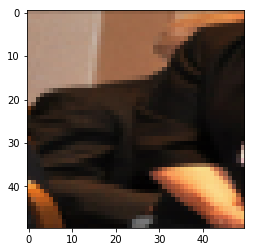

In [63]:
fig,ax = plt.subplots(1)
ax.imshow((images_train[1]))
print(bounded_annotations_train[1])

In [64]:
x_train = images_train/255
x_test = images_val/255
print("divided by 255")
corrected_ids = [-1,0,1,2,3,4,5,6,7,8,9,10,-1,11,12,13,14,15,16,17,18,19,20,21,22,23,-1,24,25,-1,-1,26,27,28,29,30,31,32,33,34,35,36,37,38,39,-1,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,-1,60,-1,-1,61,-1,62,63,64,65,66,67,68,69,70,71,72,-1,73,74,75,76,77,78,79]
for index, item in enumerate(bounded_annotations_train):
    bounded_annotations_train[index] = corrected_ids[bounded_annotations_train[index]]
for index, item in enumerate(bounded_annotations_val):
    bounded_annotations_val[index] = corrected_ids[bounded_annotations_val[index]]
ylabels_train = to_categorical(bounded_annotations_train)
ylabels_test = to_categorical(bounded_annotations_val)
print("to_categorical")
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    #early_stopping_monitor = EarlyStopping(patience = 3)
    np.set_printoptions(threshold=np.inf)
    dense_layers = [3]
    layer_sizes = [128]
    dense_sizes = [128]
    conv_layers = [3]
    kernel_sizes = [3]
    for dense_layer in dense_layers:
        for dense_size in dense_sizes:
            for kernel_size in kernel_sizes:
                for layer_size in layer_sizes:
                    for conv_layer in conv_layers:
                        model = constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, True, len(ylabels_train[0]), x_train)
                        NAME = "{}-conv-{}-nodes-{}-dense-{}-dense_size-{}-kernel".format(conv_layer, layer_size, dense_layer, dense_size, kernel_size)
                        print(NAME)
                        tensorboard = TensorBoard(log_dir="outputs/{}".format(NAME))
                        model.fit(x_train, ylabels_train.astype(np.float32), batch_size=70, epochs=100, validation_data = (x_test, ylabels_test), callbacks = [],shuffle=True)
                        y_pred = model.predict(x_test)
                        #print(y_pred)
                        #print(y_pred_rounded)
                        #confusion = tf.confusion_matrix(labels=ylabels_test, predictions=y_pred_rounded)
                        #print(confusion)
                        predictions = tf.argmax(y_pred,1)
                        true_class = tf.argmax(ylabels_test, 1)
                        con_mat = tf.confusion_matrix(true_class, predictions)
                        print('Confusion Matrix: \n\n', tf.Tensor.eval(con_mat,feed_dict=None, session=None))
                        #cm = confusion_matrix(ylabels_test, list(predictions))
                        #print(cm)
                        '''
                        model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=32,shuffle=True), 
                        epochs=10, callbacks = [tensorboard], validation_data = datagen_test.flow(x_test, ylabels_test, shuffle=True))
                        confusion = tf.confusion_matrix(labels=y_, predictions=y, num_classes=num_classes)
                        '''
                        #model = run.register_model(model_name='sklearn_mnist', model_path='outputs/sklearn_mnist_model.pkl')
                        model.save('outputs/' + NAME +'0.99_stratIter_100epochs.h5')

divided by 255
to_categorical
3-conv-128-nodes-3-dense-128-dense_size-3-kernel
Train on 8000 samples, validate on 7952 samples
Epoch 1/100
8000/8000 [==============================] - 185s 23ms/sample - loss: 4.3831 - acc: 0.0101 - val_loss: 4.3821 - val_acc: 0.0126
Epoch 2/100
8000/8000 [==============================] - 191s 24ms/sample - loss: 4.3827 - acc: 0.0119 - val_loss: 4.3820 - val_acc: 0.0126
Epoch 3/100
8000/8000 [==============================] - 190s 24ms/sample - loss: 4.3825 - acc: 0.0103 - val_loss: 4.3821 - val_acc: 0.0126
Epoch 4/100
8000/8000 [==============================] - 185s 23ms/sample - loss: 4.3826 - acc: 0.0095 - val_loss: 4.3821 - val_acc: 0.0126
Epoch 5/100
8000/8000 [==============================] - 183s 23ms/sample - loss: 4.3825 - acc: 0.0096 - val_loss: 4.3820 - val_acc: 0.0126
Epoch 6/100
8000/8000 [==============================] - 194s 24ms/sample - loss: 4.3825 - acc: 0.0090 - val_loss: 4.3820 - val_acc: 0.0126
Epoch 7/100
8000/8000 [==========

KeyboardInterrupt: 

In [ ]:
strategies = ['stratified','most_frequent','prior','uniform']
for strat in strategies:
    clf = DummyClassifier(strategy=strat, random_state=42)
    clf.fit(images_train_stack, bounded_annotations_train)
    DummyClassifier(constant=None, random_state=42, strategy=strat)
    print(clf.score(images_val_stack, bounded_annotations_val))
    y_pred = clf.predict(images_val_stack)
    print("Accuracy:", accuracy_score(bounded_annotations_val, y_pred))
    print("Precision_weighted:", precision_score(bounded_annotations_val, y_pred, average = 'weighted'))
    print("Precision_macro:", precision_score(bounded_annotations_val, y_pred, average = 'macro'))
    print("Recall_weighted:", recall_score(bounded_annotations_val, y_pred, average = 'weighted'))
    print("Recall_macro:", recall_score(bounded_annotations_val, y_pred, average = 'macro'))
    print("F1 score_weighted:", f1_score(bounded_annotations_val, y_pred, average = 'weighted'))
    print("F1 score_macro:", f1_score(bounded_annotations_val, y_pred, average = 'macro'))
    print("Hamming loss:", hamming_loss(bounded_annotations_val, y_pred))

In [ ]:
path = "train2014/COCO_train2014_"
train_categories = np.zeros(100, dtype=object)
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
train_categories = train_categories[train_categories != 0]
del train_categories
labels = np.asarray(list(itemsets.values()))

keys = np.asarray(list(itemsets.keys()))
del itemsets
multilabel_binarizer = MultiLabelBinarizer()
binarized = multilabel_binarizer.fit_transform(labels)
labels_train = np.array(binarized)
instances_train = np.array([[key] for key in keys])

iterative_x_train, iterative_y_train, iterative_x_test, iterative_y_test = iterative_train_test_split(instances_train, labels_train, test_size = 0.993)
del multilabel_binarizer
del instances_train
del binarized
del labels_train

images_bboxes = []
for [image] in iterative_x_train:
    try:
        bbox = getBoundingBoxesPicture(image,path)
        images_bboxes.append(bbox)
    except Exception as ex:
        print(image)
        print(ex)
del iterative_x_train
del iterative_y_train
del iterative_x_test
del iterative_y_test

image_id_train, images_train, bounded_annotations_train  = zip(*images_bboxes)
del images_bboxes
del image_id_train
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
images_train_stack = np.vstack(images_train)
del images_train

In [ ]:
path = "train2014/COCO_train2014_"
train_categories = np.zeros(100, dtype=object)
itemsets = defaultdict(list)
for annotation in train_annotations:
    train_categories[annotation['category_id']] += 1
    itemsets[annotation['image_id']].append(annotation['category_id'])
train_categories = train_categories[train_categories != 0]
del train_categories
labels = np.asarray(list(itemsets.values()))

keys = np.asarray(list(itemsets.keys()))
del itemsets

rand_sets,rand_images = random_sets(labels,keys,100)
del labels
del keys

random_images_bboxes = []
for imageset in rand_images[0:1]:
    for image in imageset:
        try:
            bbox = getBoundingBoxesPicture(image,path)
            random_images_bboxes.append(bbox)
        except Exception as ex:
            print(image)
            print(ex)
print("bboxes finished")
del rand_images
image_id_train, images_train, bounded_annotations_train  = zip(*random_images_bboxes)
del image_id_train
del random_images_bboxes
bounded_annotations_train = list(itertools.chain.from_iterable(bounded_annotations_train))
images_train_stack = np.vstack(images_train)
del images_train

In [169]:
path = "data/train2014/COCO_train2014_"
images_bboxes_equal = equalClassSizes(train_annotations,250, path)

{'segmentation': [[369.87, 311.73, 406.96, 310.4, 409.62, 309.29, 408.73, 298.41, 406.73, 295.52, 385.86, 294.19, 374.98, 298.63, 369.2, 300.85, 370.31, 310.62]], 'area': 588.6190500000002, 'iscrowd': 0, 'image_id': 250417, 'bbox': [369.2, 294.19, 40.42, 17.54], 'category_id': 3, 'id': 362274}
{'segmentation': [[275.33, 564.26, 223.81, 561.64, 196.75, 546.8, 152.22, 531.08, 144.36, 565.13, 112.05, 573.87, 87.6, 575.61, 21.25, 555.53, 48.31, 490.92, 102.45, 374.79, 102.45, 374.79, 99.83, 373.05, 130.39, 371.3, 149.6, 334.63, 165.31, 343.36, 154.84, 374.79, 174.04, 414.08, 177.54, 445.52, 208.1, 440.28, 254.37, 426.31, 294.54, 442.9, 320.73, 484.81, 316.36, 518.86, 305.01, 545.05, 275.33, 566.88]], 'area': 38416.467000000004, 'iscrowd': 0, 'image_id': 180964, 'bbox': [21.25, 334.63, 299.48, 240.98], 'category_id': 70, 'id': 1623440}


c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


zero-size array to reduction operation minimum which has no identity
zero-size array to reduction operation minimum which has no identity
Buffer and memoryview are not contiguous in the same dimension.


In [217]:
print(images_train.shape)
print(images_train.shape[0])
dataset_size = images_train.shape[0]
TwoDim_dataset = images_train.reshape(dataset_size,-1)

(30244, 50, 50, 3)
30244


In [218]:
tl = TomekLinks()
X_res_tm, y_res_tm = tl.fit_resample(TwoDim_dataset, bounded_annotations_train)

In [68]:
sm = SMOTE(random_state=42)
X_res_sm, y_res_sm = sm.fit_sample(TwoDim_dataset, bounded_annotations_train)
#X_res, y_res = sm.fit_sample(images_train_stack.reshape(images_bboxes_equal[1].shape[0], -1), bounded_annotations_train)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 6

In [172]:
ada = ADASYN(random_state=42)
X_res_ada, y_res_ada = ada.fit_sample(TwoDim_dataset, images_bboxes_equal[2])

In [173]:
print('Resampled dataset shape %s' % Counter(y_res_ada))
for (i,instance) in enumerate(y_res_ada):
    if instance == 89:
        print(i)

Resampled dataset shape Counter({80: 293, 89: 270, 70: 250, 1: 250, 7: 250, 47: 250, 3: 250, 67: 250, 16: 250, 19: 250, 62: 250, 4: 250, 52: 250, 51: 250, 27: 250, 20: 250, 28: 250, 24: 250, 50: 250, 10: 250, 8: 250, 84: 250, 44: 250, 73: 250, 38: 250, 31: 250, 46: 250, 60: 250, 18: 250, 88: 250, 37: 250, 81: 250, 86: 250, 40: 250, 64: 250, 2: 250, 57: 250, 63: 250, 77: 250, 87: 250, 42: 250, 65: 250, 36: 250, 17: 250, 75: 250, 79: 250, 33: 250, 9: 250, 74: 250, 15: 250, 54: 250, 21: 250, 61: 250, 82: 250, 59: 250, 25: 250, 43: 250, 35: 250, 22: 250, 72: 250, 85: 250, 55: 250, 6: 250, 13: 250, 76: 250, 56: 250, 32: 250, 34: 250, 53: 250, 41: 250, 14: 250, 11: 250, 49: 250, 39: 250, 90: 250, 5: 250, 58: 250, 23: 250, 78: 250, 48: 250})
4152
6557
8263
10160
12560
15823
16944
17319
17510
17547
17707
18157
18202
18283
18379
18551
18600
18683
18728
18883
19012
19030
19061
19147
19228
19255
19337
19341
19357
19397
19402
19403
19460
19467
19472
19475
19506
19538
19540
19555
19579
19580
19582


In [219]:
#x_res_3d = X_res.reshape(X_res.shape[0], 104, 107)
#x_res_3d = X_res_ada.reshape(X_res_ada.shape[0], 50, 50, 1)
x_res_3d = X_res_tm.reshape(X_res_tm.shape[0], 50, 50, 3)


In [220]:
print(x_res_3d.shape)
print(y_res_tm.shape)
print(y_res_tm)

(29624, 50, 50, 3)
(29624,)
[ 1 44 21 44  1 47 84 10  1 42 79  1  1  1  1 55 15  6 47  1 19  2 88  1
 85 18  1 67 76  1 85  1  1  1 76  1 10  1 51  1 18 33 85  1 18  1  1 32
 16 28  1  4  1  1 32 50 59 37  1 77  1 19 56 38  1 81  1  1  1 17  1  2
 72 59 50  2  1 22 84  1  1  1  8 16  1 53 44  1  1 56  1  3  1  1 78  1
  1 59  1  1 38  1  1  1  1  1 86 43  1 16  1  1  1 67 50 62 81  1  3 44
 79  1  1 62 44  1 52 62  1 20 16  1  3 65 64 60 38  9  3 62 47 17  1  9
  1 59 20 51  1 62  1  9  1  1 62  1  1  1 28  3 62 18 28 85 38 67  1 33
 62 86 44  1 40  1  9  1 42  1 47  1  1  1  1  1  1  3 47 19 24 77 55  1
 42 20 79  1 46 31 84 58 44  1  1 52  1 18  1 51 64 72  1  1  3 28 25 75
  1  2 86  1  1 75  1 16  1  1 81 51  3  1 82 47  3  8 42 70 44 28 15 38
 25  1  8  1  1 44  7 51 13  1 32 42  1 61  1  1 63 59 81 28  1 33 77 51
  1  3 10 52  1  1 27 28  1  1 49  1 15  1 85  1  1 10 74 62 38 20  1  4
 22 49 57 55 62 10 55  3 27 39  8 86 88 77 88 47  1 31 70  1  1 22 22 48
  8 51  1 10  1 15 20 4

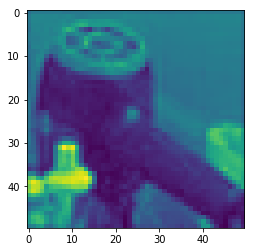

In [183]:
fig,ax = plt.subplots(1)
ax.imshow((x_res_3d[20057]))


In [43]:
path = "data/train2014/COCO_train2014_"
valpath = "val2014/val2014/COCO_val2014_"
category = "category_id"

with open(os.path.join(data_folder, "annotations/instances_train2014.json")) as read_file:
    train = json.load(read_file)
train_annotations = train["annotations"]
del train

bbox_category_ids = []
bboxes = []
for annotation in train_annotations:
    bbox_category_ids.append(annotation['category_id'])
    bboxes.append((annotation['image_id'],annotation['bbox'],annotation['category_id']))
train_split_strat_x, test_split_strat_x, bounded_annotations_train, bounded_annotations_val= train_test_split(bboxes,bbox_category_ids,test_size=0.03,train_size=0.03, random_state=42)
images_train, bounded_annotations_train = getBoundingBoxPreselected(train_split_strat_x, path)
images_val, bounded_annotations_val = getBoundingBoxPreselected(test_split_strat_x, path)
joblib.dump(value=images_train, filename='outputs/images_trainrand0,03.npy')
joblib.dump(value=images_val, filename='outputs/images_valrand0,03.npy')
joblib.dump(value=bounded_annotations_train, filename='outputs/bounded_annotations_train_rand0,03.npy')
joblib.dump(value=bounded_annotations_val, filename='outputs/bounded_annotations_val_rand0,03.npy')



249882
283867
480208
65280
184211
447437


c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


176194
542174
54354
577685
382118
429319
226597
569024
264930
431510
350013
70296
266217
538640
232862
356015
409120
17967
18584
545929
333424
5482
444627
558092
550396
255669
241025
559497
264304
570628
318468
310315
112882
271157
205620
541797
252599
343307
271136
330256
365544
492078
460030
16980
502485
508724
408854
298458
301373
334892
224445
549447
475947
244549
253834
329748
5962
426915
134562
247545
347736
163723
23275
235081
231401
435929
164657
565641
43383
521204
250677
42278
455166
188380
434859
382589
51359
304889
427852
221004
59351
523484
224781
209662
174526
372480
303788
330916
510371
173185
247475
438196
107753
114880
485180
557825
160535
330922
200280
395198
81971
136343
300232
415131
514556
177922
428117
576457
97391
311416
166489
405897
533477
141386
183445
102942
185358
294138
373697
389715
259417
55695
369207
335351
244088
457871
573954
550842
50106
160615
260817
540162
175912
569356
92280
78509
37527
444644
567665
436288
156709
577481
540082
90498
201640
430346


150037
21469
91852
345388
260138
195368
1777
162828
99165
125365
312504
43780
250737
376757
551438
88025
300014
318967
157288
152096
486309
223091
529886
562325
249764
395409
302538
231963
337146
325523
205785
219229
139595
211843
40874
471945
480532
207875
222964
511200
108606
83624
275969
290370
391351
419501
388020
250744
287953
301200
358176
64492
157105
394330
149280
166201
517652
43001
471515
512140
322064
118330
51799
425721
174470
573670
323489
390856
205023
21268
373400
230046
155995
544561
510260
322953
324567
47281
461252
508855
264388
43171
200642
335492
55410
482049
122950
289861
194551
139469
566368
413374
303213
487286
476965
432956
322321
113152
210604
427618
255604
392664
100331
440778
289514
405058
376132
224379
117366
346274
411937
392394
564063
174098
212429
28307
437778
54218
459585
326966
36639
7945
480948
311562
126432
456285
250630
38862
53900
393576
12488
497819
454406
63818
71
498022
193148
304391
242193
48319
139068
137250
487286
231705
9768
305247
415589
336

152844
340610
129871
429644
242163
474446
332203
72233
145502
276811
444997
139151
2209
68685
222703
357989
324232
255226
248066
454940
527720
35322
29327
407065
268192
250737
177954
195124
406855
285170
220518
411061
75334
368661
394436
116155
455419
333461
416165
48670
100958
390423
26133
167996
45785
128709
401059
21343
82220
296876
302349
76988
543716
462110
38933
87334
431400
409628
543378
164487
213095
508245
511200
87598
20104
73549
479332
111933
55575
23134
297811
459659
89340
506750
209304
160142
560135
102473
445249
73434
116100
41398
268067
448099
470539
426246
399162
296894
257946
64111
549199
6352
461847
485187
222506
505343
70297
174188
79170
323558
262307
261381
434328
150276
73513
299786
543272
441461
518555
172665
433305
533633
92686
277401
98290
458756
144018
567665
203926
166650
421534
370466
348907
218775
10281
366417
488792
240813
348609
381828
173749
412806
394964
36748
72505
176925
518769
261710
185587
471113
258073
517326
102540
178742
506927
314750
347189
44635

77745
67331
540495
167229
245697
75925
159929
80406
551922
457274
370130
57375
150671
99539
397987
64588
194273
319649
317557
492851
562253
373373
1488
494240
383805
446
161367
30395
142276
150053
123180
90679
463546
126433
115372
156512
580414
206700
109277
563280
75361
106835
178971
22612
304095
111635
63230
406062
50945
118682
298350
509620
319731
457660
337047
186525
326377
368818
97861
332867
22806
11576
43270
413676
411851
490940
112053
308758
224778
377598
257669
72111
415944
477622
346492
466432
563435
202226
308100
69768
237081
55130
336357
298008
579909
509023
204962
180765
232467
523306
439991
408829
193495
467145
323646
306219
23695
571541
67565
97878
475804
571366
365123
39570
100142
291797
497030
279373
468313
554698
461208
537258
517115
51199
359825
113513
543275
431808
354932
327202
329737
290719
177516
580579
95081
542643
563645
174375
209005
157215
113893
409678
49248
581637
569242
430086
489983
76636
67974
150185
184684
264197
330220
482989
458143
450894
373120
57035

408266
537878
536145
212025
197705
277613
406807
392664
190942
570968
296648
455117
6247
532711
550028
549114
4843
111972
538007
425912
519369
456709
467300
347263
138915
275037
462709
509321
286016
271701
209176
279733
333796
321448
53643
408506
554104
530216
315165
284338
126126
577520
190353
85998
43719
91952
115156
494749
75726
459310
141947
5345
54083
551316
233642
34624
572745
507889
302055
39987
572500
493245
95559
427180
273035
500991
187432
18529
446307
309368
278989
498241
312506
393036
10877
396010
326335
505962
223718
308548
29942
183395
401707
240952
449781
338833
384563
63866
552167
140308
458413
311706
493504
470147
509608
105589
112226
170962
505160
392083
437676
275556
226976
47735
73434
382342
480712
485526
266032
114617
361051
343748
346876
356396
72453
424907
207455
476893
76912
6428
560309
160573
428440
278055
370136
434156
242982
121857
79883
295461
145994
511751
389382
336078
11159
516624
393576
538308
74232
518510
498786
498588
339793
435326
576089
519685
354842

559484
270536
185051
196460
219454
237031
265796
526295
249983
212856
336313
197593
64170
415663
522244
248839
493131
536041
488634
179823
103528
327262
506927
394214
307940
360535
313927
209246
423643
579045
524375
301605
50563
520654
538809
409184
508855
216091
250991
94300
301431
65457
421202
339690
52992
478092
173801
22226
438375
250067
469851
52299
126126
22484
552502
546940
39548
202010
416622
536663
386796
410972
37478
482161
501358
358576
254129
526362
5620
292116
362140
106003
200619
433221
512634
418586
483305
221478
519939
530002
296477
8114
110000
458202
392924
316238
74183
45617
223203
525223
174399
412222
52250
399097
554750
230227
355248
546695
116074
356868
164842
276332
138189
408029
413382
495043
12283
54130
308422
415370
404565
151581
401400
523735
447615
73187
252998
494785
60982
562335
47333
361755
93535
361059
10229
444893
117349
459706
59174
536935
386603
137212
86221
140067
451160
355194
295642
116026
389498
61354
68430
210728
576550
349827
170390
121363
545274

133281
423330
378848
9025
60812
68947
146469
368087
236611
242378
103554
45148
61463
311208
236897
59388
545334
530289
96713
168818
62292
305853
94925
80520
262001
28318
345145
354771
516034
370802
274509
75339
220736
105444
97458
202762
449847
125541
495059
54594
494548
541580
197636
478683
494785
7145
507136
515019
444018
559949
6233
287299
357967
27534
563319
572814
549347
266071
103699
38122
52270
158515
65343
276491
276894
120088
286166
197322
4289
437435
419632
579716
5688
265701
530729
341621
369355
308963
335212
75587
556823
73022
439057
226046
43773
137778
122913
409897
184751
100311
153923
16060
526887
492580
325932
14791
562819
369610
491888
284846
442732
447849
255203
342589
406792
208008
528712
50518
222351
352389
369609
458772
387392
513210
203975
43895
457686
386724
419904
371758
532181
258391
351159
249817
338242
27888
87616
310649
424596
150942
547767
54013
396260
30888
441734
250941
201939
245780
462925
369504
132019
16359
482234
538701
435322
486250
252105
561424
267

268681
17799
302289
125452
165350
347051
246071
516189
526362
137250
259188
36166
395740
251121
155040
578683
394197
351013
429052
366665
373664
536760
369784
357272
132607
113521
262454
329035
13800
571842
164772
429038
363656
330909
444644
460730
133791
483757
391361
48665
322002
527267
516289
159175
40248
347167
543830
256190
24169
268583
239144
565286
53720
129129
207463
499237
540567
286181
185991
444487
474760
51643
256869
147710
326757
30133
65407
461657
370124
387299
176721
255714
329179
362284
349905
59454
370661
451032
146907
45999
72902
220896
557191
212321
475674
527344
35571
356916
84314
541496
191805
105933
169576
548742
550000
445388
15110
529887
376457
556067
481841
217448
426903
191042
405515
14337
267555
439185
573973
542060
498786
460038
398331
140180
360313
420396
448317
486513
307240
421145
559262
286348
280913
351818
420236
16665
84238
311324
65163
20251
102655
78314
535358
57828
269260
354699
105472
955
34061
29189
164081
57088
422063
532866
491833
64800
470618
2

436092
534000
159398
497393
120644
562176
150185
567037
18418
272176
392758
172040
457660
476575
428485
348595
548742
181595
40351
558387
286930
467723
269738
146623
512662
442785
323267
56293
579053
482515
192671
374878
144018
204021
456602
35367
472506
242203
222358
492183
443479
564681
564072
274019
80391
560691
317216
324871
3999
41826
363548
206349
489735
295887
233104
119621
455366
482505
314558
447150
89093
107072
361746
183244
207862
405991
399148
253777
298459
314558
390883
70566
191277
286751
549928
294957
451196
56845
104891
324513
54194
179914
118848
265253
523154
294688
163474
244983
423909
357424
25994
481178
147772
122137
6936
48267
425114
301431
43150
224414
560655
416648
57866
360283
492495
566785
204683
299974
109896
469024
477451
390474
103510
329762
196797
124765
101749
83079
559875
370802
122093
20168
459110
436802
580414
364380
572024
492711
141348
258727
551303
113617
36289
141304
83986
511345
85657
271862
549127
363750
379766
231601
64093
435554
63556
486899
104

484758
424991
554541
23096
238200
203454
492292
131107
568378
502485
465333
111525
52983
143870
163358
526987
79869
276089
272100
441460
543684
292533
393384
330785
65979
338134
269504
560495
258397
476160
341768
221615
124532
270440
79191
468588
178901
476151
512449
412687
127932
570477
92753
53670
31913
507665
543378
541027
225477
560571
35547
296648
520553
488940
114240
389692
472027
433334
190796
293647
229969
399009
475902
530869
128116
384499
117770
61535
45314
325821
209092
451594
549810
302289
11075
532398
455505
545806
380351
521775
554464
195992
132946
157105
204889
57515
249362
304221
9542
181155
5260
465813
80044
138290
134770
243558
249688
531253
480107
71828
109858
546499
377044
192642
530551
521998
105100
276009
567423
386979
145856
387561
505884
187803
287094
504554
263896
142393
451597
510552
12650
335144
465776
228611
346930
460339
378720
549172
124840
32629
406420
406753
17877
143348
223366
121622
145006
185177
503875
171339
129712
400919
221012
34038
263744
347217
7

716
532219
44341
437073
496256
157105
218985
90582
533917
460780
578843
527082
328847
225604
213530
448698
103504
71232
409126
215493
451727
345145
110087
490712
1906
547308
347403
129888
131172
40844
143348
14862
282843
548889
6981
123975
722
457383
46580
53095
49123
280473
567858
115365
229559
211918
133937
553388
233437
271171
86620
533957
331222
96339
347463
179650
231019
52219
308758
262673
424278
446899
569989
283257
427435
50462
395340
322268
431024
397605
455311
553267
532577
379508
276610
472392
478410
186145
552810
361256
292543
516990
417700
123127
123753
413164
94293
239520
263418
393985
7251
248150
424821
181176
444664
140585
181711
429606
98864
150385
398571
288649
489520
304694
530670
382631
282131
283129
225088
191754
502884
506183
221909
42427
120127
196851
239532
354003
499636
31788
138387
470333
211810
188440
329476
475664
268306
569550
117366
256877
419276
115359
141160
103726
314844
210450
280187
270284
420747
446628
17839
286248
234978
158195
132500
139887
117275


53587
492715
405579
54738
35004
262670
97861
562777
506342
566839
468801
47954
152529
82796
450136
92096
155177
536286
516106
501635
432428
490057
419232
536900
40205
318959
110536
401703
224522
312476
520176
444986
420396
427586
502862
268711
223499
275630
161234
509691
371965
452750
367285
8086
243504
133166
375947
369199
323475
285260
565002
134924
314837
450281
66566
321702
369326
490723
517882
400845
249145
573732
404322
339130
331998
265586
378533
125720
484742
156534
120335
300950
206387
581744
118895
37015
382400
11505
463342
77095
206583
425127
296417
310085
238729
14938
380252
141586
147779
258397
157186
148583
336901
215380
142570
241421
210642
97492
79453
396412
555808
139789
109088
11948
523689
132841
18529
255017
353316
162557
515106
494985
275613
124593
441461
102202
474556
91696
177289
130287
212532
417487
73195
123336
57744
461917
342203
571342
338971
73824
32134
552199
95659
176435
33687
553682
532137
103380
261887
580026
470147
495789
162753
144000
158028
193953
4574

463739
534094
550944
256322
361291
178389
355950
122802
538821
444644
138536
354770
210079
516265
520094
291973
314048
488689
154354
171158
262172
123749
252212
479501
36841
524377
117796
499611
44729
543378
580082
497847
209851
438061
396143
11630
21528
252998
42418
515229
158353
424979
315322
431933
424459
398609
185229
54375
380591
289058
72809
112801
386341
40056
460143
444794
546105
502916
21254
553975
133166
574812
178000
508429
479168
493880
129133
27701
229583
145503
274039
393037
462798
20971
368876
23996
450975
365206
84096
131812
56928
319863
347509
158451
174188
424459
491400
442811
572354
542231
532543
241294
524520
458397
255971
471658
382386
170483
246009
61819
116737
506971
381928
141952
495124
253675
474601
882
407413
108505
338012
438844
193327
175669
174930
58403
291018
206155
255335
239596
360283
344040
70307
33471
429745
548153
74273
93649
270999
385972
421325
224396
384422
14477
376983
440381
137892
108164
300806
479387
294912
303484
365858
4489
129781
140346
8877

449808
530966
20434
451024
511963
520036
579446
576518
496440
36221
43892
141101
500273
139285
577125
341212
265833
71845
347754
365943
504566
154704
271633
498022
153604
15269
206363
444571
197264
277613
132954
173284
411603
473575
543182
99135
478198
537608
145502
64339
338087
221665
8781
132954
294416
217046
339978
358200
70804
370162
457659
336397
237210
471504
545987
171564
28231
115087
61498
191249
576187
531998
567847
254476
488683
268826
560748
468493
119571
111673
278335
561624
311616
131450
287881
545525
525898
266334
379517
563645
282444
184820
469770
52037
38532
360071
471515
349319
56323
540890
511285
297765
172930
60043
140992
422939
148385
400218
158378
377518
82745
473500
370738
354248
264456
522110
465779
542365
437970
250574
172937
477442
220250
23413
95185
354305
404450
576155
418885
244461
173812
261485
541832
89005
523358
267022
271499
564443
532188
425380
372514
98760
246287
17096
22287
213389
401509
16578
306249
74917
186018
370235
304134
537367
574961
365284
386

400409
523876
281557
331588
122667
505343
571311
145856
143965
432286
103966
549166
273029
431820
441619
528566
357989
271447
488990
254800
558851
506576
142996
434118
478997
38923
408576
536641
452782
418085
224759
335477
242163
329134
296581
225088
31621
476060
50810
461494
244675
56676
498022
347048
538686
146582
273379
369156
81283
235281
227178
425917
183910
530211
287289
481807
272155
127006
42619
225230
258735
301238
387796
502089
273929
461098
27777
421648
178178
131211
520879
572505
57500
165945
138536
53900
509132
409063
536932
155942
60190
380453
475142
296009
279632
527337
448812
521632
86552
37514
338894
762
273548
460441
40940
456705
66246
295154
52250
360412
86435
299426
18370
547135
238589
108042
403135
289248
471113
159965
147442
473102
15379
26068
508299
355119
22863
239593
536855
369491
213535
309386
514650
521872
372748
160967
440074
302982
224733
9990
302250
360695
266043
552553
336195
354716
81555
158201
361359
336167
189810
383731
199432
111673
396412
267216
5021

271574
217531
397186
27237
30387
298468
537878
152269
270407
534716
73434
419679
2083
150942
41997
563592
192627
210932
317091
406250
432307
243787
28728
86825
523433
303703
563058
150969
155118
311251
11029
105998
302051
200879
191994
552330
355737
503170
499598
335359
523729
88155
188955
203818
219030
115619
567976
472108
203304
279775
468519
453523
256451
61732
170139
28560
385522
56510
139887
39272
170432
273716
311174
563297
551275
571351
67680
363764
220942
454003
495875
221289
61729
563584
76005
184805
213207
398071
260702
555921
237592
359535
480773
52208
580741
357015
189153
408099
377251
532062
59556
100128
69661
456155
177829
185258
81365
54086
78909
522129
537790
448839
109386
221948
254362
26359
500467
153380
432349
394880
77542
450716
82202
47879
227066
388353
246725
102357
205707
528642
328951
436662
307316
146751
262991
197525
268737
175855
349
347505
216899
56161
11426
445952
280508
340611
47372
159495
51630
294509
447639
302989
210395
69826
134818
272480
311899
168332

140693
380039
277096
552502
509210
292183
90218
556458
502179
576752
577358
478859
318637
376839
311522
265330
568369
208731
308653
37183
218715
319045
542431
15073
279693
416644
370963
311478
68445
320454
121792
455505
56677
485113
33068
53474
363525
256720
296706
544005
135499
265277
534959
14125
211788
51639
157202
577787
375815
344040
237685
339766
135242
130081
543171
306288
513795
331313
382731
396661
398615
245566
217487
202080
141366
209433
423966
537152
370851
397736
487903
181493
294199
483690
496613
176596
347505
405543
240944
224905
521709
142349
96897
134128
14938
364862
331203
328314
496747
379607
355571
340425
35741
311416
475130
19131
2907
427046
160573
130647
399042
525300
38380
103759
17877
352623
388149
21718
390969
127743
401369
310085
115018
309840
274559
410754
222755
531153
64377
440675
260991
14477
23737
221684
454514
317274
451278
468085
133403
55728
312182
204423
74127
425542
496039
573922
162735
371587
508722
551427
226232
396030
123282
432037
327841
248417
7

359691
370059
399750
327330
549002
333775
564580
278665
257013
349663
544690
557045
36221
111922
448503
375099
191338
572923
95486
6233
511650
50602
382517
34285
156812
403305
292898
417105
546218
71441
188587
66157
263651
172091
300488
167574
332821
499135
91948
202326
380148
177404
501995
74179
359168
476198
191321
248012
465169
559995
38487
416258
130914
208646
450800
211843
131589
73022
437292
231593
487340
275961
155097
451529
446688
324450
460353
390243
31375
25858
250372
225848
285810
201929
150480
80553
518555
461099
231993
235446
345644
297159
210728
495247
307869
536252
141166
362151
94459
270723
14472
303650
437073
276639
294549
564185
337104
2782
3514
226559
115117
254845
438091
186121
157783
284551
403135
83804
26027
323963
39100
561761
62558
48727
65836
80386
162645
187855
151353
249807
1139
258400
374102
239515
404214
22166
92098
211217
144193
293393
434161
481702
360179
292510
182181
468796
134902
471927
223500
124364
342766
381377
400822
14938
438157
16773
228514
56924

474930
130142
563791
390806
261381
52924
484353
104817
436168
356480
28307
491287
16334
353270
14230
80215
231071
552112
378950
543026
348616
413556
246009
295999
355458
527858
315555
132750
58694
529136
36197
547100
427301
182096
138891
363956
90523
254714
401085
283650
497642
544386
192090
154817
174228
239784
254787
570874
374102
403910
512322
274422
218201
111831
67988
102739
103969
572173
43968
123286
577148
60812
403221
92988
58268
175609
538133
246181
233224
198383
124804
270290
166813
388303
205559
260634
190601
148862
164955
436564
579907
286619
142689
444033
566783
418315
219474
233926
348316
128278
308653
164461
358265
108451
17420
337985
333775
90258
340995
511587
147337
183585
246056
282982
115126
529433
500982
22658
234083
269045
246719
116892
472907
51152
369036
278347
35514
343104
108446
20611
254562
485267
447075
414828
324709
333818
251442
124577
350724
218307
128463
136302
253584
81842
205234
313637
441546
390806
197662
248337
399971
365755
519218
116123
359686
36763

464079
536054
469661
415604
196406
106878
79268
187518
169937
538523
394889
183131
100777
242744
428446
519157
344814
222964
362091
303668
249291
94863
142466
379965
197605
318783
320275
341341
368702
439373
465302
504896
72715
265160
442531
495073
276584
58580
336079
200798
563793
577613
216003
428816
202554
557483
471351
383446
516487
122586
478872
197561
544687
482665
107428
150151
357769
233744
574562
286101
246026
126045
509358
573963
248745
326148
258249
41887
7049
398850
256877
492351
95749
102910
433007
115902
18466
411814
22429
241421
505038
129565
200830
396143
204384
501006
467911
29456
169499
562335
282803
25273
121322
62344
24026
399650
88155
83386
103549
361670
380429
129246
230931
577613
192579
368060
10403
502748
227734
199021
540486
201969
64800
496918
137778
468258
520808
549644
152431
143665
205547
166678
497815
310685
204021
260088
81593
466580
320081
561917
295315
398172
537879
187119
527571
30888
327702
145898
373077
538637
506898
553586
435716
199533
381139
13775

71222
558786
339938
372980
190550
107119
571719
82904
36262
445621
486506
277439
424482
445216
75866
494531
73264
569174
578215
491426
172425
350009
371745
237743
48474
516771
146645
568143
116123
30888
171536
441062
448648
475380
483714
361930
408292
544866
202490
199363
65407
5689
438196
377211
469330
253528
553455
220156
323862
358730
376740
34340
114820
27710
251671
116794
402083
319197
553396
507196
28006
164972
427895
327561
533041
380797
443527
127
305451
358616
93655
447839
20456
306240
215910
516175
331919
537774
363885
535768
340129
313260
515899
194553
10856
355786
62472
579312
14844
451279
60482
394518
521796
454452
422170
285149
119882
166474
150082
264033
169686
508208
418155
274633
268681
338880
69468
505642
581233
260677
429741
61439
521201
146560
174787
334631
566897
323129
253528
522834
532704
192954
230210
73568
36028
178838
364303
455287
322407
552031
437810
228974
129060
577405
504616
73648
350621
449573
333181
506026
191551
515019
140340
531979
549599
439271
14798

247706
305885
236222
451119
453787
101772
260634
44583
230670
451206
499959
4809
248168
287760
86031
272228
318241
220843
567224
260400
222587
155588
402281
390658
134819
431194
18317
251671
90712
298721
507952
101559
323489
478968
242153
460862
492040
575294
200597
340459
393553
345576
22166
164142
335133
476447
89788
335552
491857
54374
144242
40844
417264
227843
578702
71011
455523
267604
430481
233863
371718
203248
405246
494711
487870
426500
85114
193540
296913
344629
48267
374046
305327
359567
396481
412855
447479
119419
200476
407617
301558
360306
80391
346026
385658
306535
357289
417303
368087
88315
579447
42682
240691
269434
436321
490645
123878
513138
273808
368547
41482
560047
574697
203891
334587
149615
270440
296648
416157
267661
37931
241457
462517
442790
451800
408206
142426
316583
345997
21599
555294
532625
41756
261541
496458
117637
263462
179906
22796
559194
226545
518416
386527
145502
104953
262001
478145
124408
236484
195027
295903
303311
283673
554464
90103
137382


561308
397973
372121
564271
331409
54173
129712
339159
410509
408249
180504
99623
565641
102724
479680
116650
297995
262748
364032
146881
54124
106513
24002
447025
111996
89227
549605
257807
196619
304530
226632
458682
477440
506062
2842
462803
464440
489497
220889
462901
338197
29041
491830
262359
304115
249666
126433
103380
197853
581662
61674
205391
381163
135193
251842
446864
260991
22650
316595
357362
565546
563791
166310
422050
448471
232875
535229
156035
433023
572840
76130
355737
193471
364698
498354
289255
364680
90744
84314
497930
296777
277788
305282
462398
455350
469147
57166
560526
65643
253522
347455
169172
363716
111799
6057
128750
535948
80030
514749
527786
92006
76835
347865
538580
137690
349658
350174
475960
215081
116229
122948
359951
374302
508244
385307
27888
132552
510729
298318
68801
454749
132773
563793
269431
466828
95999
373480
37682
394583
263418
116663
353072
417602
201490
85948
434028
522803
97660
158055
449669
425289
341335
11774
26052
510813
211484
560576

225477
266976
121040
250827
207734
41404
537304
237514
246688
109423
10083
179672
510414
419232
53184
524766
104556
59237
460370
305278
10540
497393
416655
37198
483806
302470
146096
27929
90582
477440
479815
127450
27937
467447
397826
160629
302712
260010
366470
482810
226632
290047
478448
129865
505579
500457
314929
12240
156885
418385
288753
277764
74386
513881
28276
256950
86825
514635
477440
183266
382472
125550
188658
189993
382
286511
63163
569718
99135
308878
57560
311991
32611
117721
113
368547
88759
452371
56028
115126
500612
103042
498372
529524
429446
71754
577343
425055
26052
530717
578533
370873
180641
208868
2697
67490
356144
95099
322427
481940
144467
343542
494089
557781
137984
320682
236176
20489
190547
290403
95308
135010
390002
416619
42472
344187
538557
537996
251754
120499
213742
484668
295394
176318
130065
129712
377594
469024
181028
426300
206363
497694
313803
102220
551175
572879
132972
330238
123749
260604
567721
236267
528915
558615
402142
59319
369212
450864

139944
355594
419445
292294
230169
159038
223165
511269
12726
84591
287232
408978
399939
56359
60350
110187
341421
176737
483714
443479
334432
336981
460673
437102
370836
196018
230945
195797
144881
177860
464875
190382
418115
561190
125652
256950
10244
313787
443373
191332
540626
463176
460045
214726
149185
378440
73610
532988
365517
344138
15588
449154
78689
571644
485317
394501
123201
411111
123614
559249
288880
523701
151483
454177
498492
492040
353484
36262
483677
379433
119297
346926
321363
387812
221448
366695
222251
141376
361670
127581
554689
257232
429065
548184
425055
312841
549188
92230
175801
385157
428810
51894
250809
185906
454722
310457
231682
130245
126770
157199
178957
39470
27974
352241
455532
467674
90238
106671
80085
508990
301671
61877
328075
363827
248666
317474
80134
324427
90882
452470
15564
407590
403464
224677
575792
363363
374371
525721
335656
494462
236818
96436
39632
371382
352192
360589
59075
137514
24554
243986
268622
476881
510359
340314
262529
329476
3

395551
317911
562389
195978
249968
535753
565938
414684
320875
499135
303683
426585
236282
392186
471182
19797
45366
34377
359716
400869
474062
426031
202624
66767
117939
389772
52295
293353
434753
560635
49408
323958
360269
441883
26784
217574
408405
186045
422585
406646
520451
483771
309502
116204
501346
287027
362244
438485
569610
421794
102766
578453
88274
566839
576676
297564
301615
298698
576944
480457
532988
255770
22924
430530
103578
9069
321070
471935
349204
39371
256549
525179
271987
24939
163136
451061
229228
125407
101090
491287
371718
30431
246777
434773
30665
399276
329766
175523
278457
415755
284902
256539
334136
288274
535049
152976
79394
265974
271395
185287
420862
454722
340898
339307
445073
168884
173966
9599
324877
31084
51704
442197
318892
477442
348924
538057
32060
220037
511506
535282
452642
448842
181438
402470
396030
418811
288194
109156
82246
425207
516895
402287
406073
163594
473712
156682
296933
23363
123862
428208
35995
33329
337661
209126
392030
416948
185

190466
189666
371874
331444
49135
510859
218603
40181
395225
486839
334019
476848
54065
218142
281085
163743
449904
378522
495633
139372
100668
498918
309135
197270
122263
102599
249538
83368
117839
17468
517656
128127
365218
220372
445080
162682
571648
422405
223270
26221
342255
387669
72889
551082
436221
99599
366724
230572
422479
120490
166489
143499
358334
82894
41311
24552
523564
241305
71936
30960
20644
392035
16032
287201
59024
327549
181515
351157
139456
161836
56313
21571
268023
384930
57820
195975
424337
336552
281721
323536
160746
249272
309412
8422
93191
169826
296188
50031
563746
154613
447228
150151
308
538922
461521
34039
490665
547284
331326
497819
248753
392827
434354
319712
130872
229107
58684
200494
332276
365231
254292
79269
301558
463792
305348
508398
22411
28576
120676
70854
579938
48925
578856
441338
249073
253417
317431
72016
423796
335289
248640
506920
303743
338189
433296
84422
270024
503875
11774
158378
147277
130337
122511
132954
149204
320816
151351
104631


128581
51396
41103
157198
418675
548167
65793
556203
78909
134362
105401
362244
289662
27763
120067
473052
565018
534655
226329
29473
300197
310501
426261
303236
3602
295575
382056
57676
296851
544329
9990
315654
365218
314247
352192
102754
403999
175745
549133
201192
334588
83566
276694
177148
255610
160443
86514
387368
453351
385589
305550
451550
486839
211850
515075
83174
498179
977
33820
299972
337068
361448
343707
174766
417376
159993
219225
520063
203229
530950
465575
472455
456113
230863
19338
549715
343853
424059
40844
333555
57901
558656
91639
292920
382423
342381
36157
170666
93106
92781
121659
85549
471008
168022
423643
510768
511789
400940
366702
575267
254356
415464
315310
333337
387685
67786
529586
479687
18418
51443
370843
556745
91051
159324
108375
389074
534941
574153
261945
9075
503554
574645
490541
59573
472617
462040
372309
462040
559484
416978
62995
80708
343676
159924
33042
424404
3671
464856
378558
261514
342618
239984
468519
108876
74273
155090
137778
89571
8404

167870
360309
324537
305106
530950
408946
181851
216072
170902
321852
489967
279882
264197
41890
266441
154289
444953
173870
257013
491319
248034
423734
146584
507444
444010
170366
350681
572902
548010
571573
61524
459787
501576
52756
327110
408846
569062
391999
371489
255003
73661
531201
262529
61606
354843
415670
452905
38317
114153
157476
520361
432019
464956
134705
124859
294049
495266
404990
444418
502015
508881
477807
339579
440811
392177
262956
578261
470254
173570
575331
80386
435347
490870
367259
38196
280971
320333
377572
68242
107862
308145
468826
528344
98233
211771
385837
97722
197120
419718
227248
147278
560422
32739
195968
441058
549849
505092
561464
267324
486567
290584
330649
292767
400380
62770
398087
411108
555574
101559
182201
354205
318185
57284
261863
576996
545670
229530
80231
456389
346309
150650
90566
49460
459319
571514
142674
364174
342583
557314
292522
338169
421825
270715
96030
246875
107607
274537
202762
91154
215304
245530
365927
436780
479332
331919
3257

581582
174896
125746
528006
76015
165833
58624
73843
282558
543642
576098
423454
302680
536663
122099
153727
109213
325040
525823
529787
129445
39201
119195
53595
579329
317532
105688
303495
392949
59736
448368
66696
513766
402298
358486
368409
261342
280508
339501
356060
248694
432297
132170
501289
336484
449508
425359
345518
567916
355801
443243
480812
536265
461868
69783
341431
101594
156527
468125
455427
259687
180987
185844
393686
480572
377342
406755
493504
462292
250827
508592
413541
564099
278230
530717
191900
29377
92553
444350
134383
415283
506371
139230
240046
168948
569769
367615
326947
27888
254210
390345
124580
477104
438368
139970
491664
388961
11271
149924
166751
570951
251219
3870
90324
230864
407477
368521
454225
314778
506988
402938
101687
282252
475664
265594
558551
230864
115392
419053
568492
550056
399672
508191
463839
109509
501874
466373
361088
430166
419053
522481
143764
512797
428391
112619
154895
551100
424907
250232
424340
489218
445590
570205
204529
349943


338169
537924
319669
253335
337232
439248
570203
86654
578513
579446
80386
458598
192531
154503
523495
417766
544046
415787
406121
192048
363298
547115
11402
258000
145140
133532
546708
40723
493173
402759
105079
129648
174794
381633
558523
381875
100930
333868
78412
38862
410580
138453
312446
241100
559194
424278
107535
308195
462071
418697
275930
462082
89725
304173
187483
331541
339211
534859
192322
393290
93424
466132
315719
350009
334803
574140
396741
509740
405401
213009
461226
267435
266114
117764
336221
214028
190387
500057
400818
411745
450833
502231
177339
353519
530991
22440
486650
271580
265938
314398
252144
448355
57445
361858
17967
161749
442612
297680
544856
13302
325015
484033
526337
404428
493293
452229
568432
525675
50263
463969
56868
divided by 255
to_categorical


In [221]:
images_train = x_res_3d
bounded_annotations_train = y_res_tm
print(bounded_annotations_train)

[ 1 44 21 44  1 47 84 10  1 42 79  1  1  1  1 55 15  6 47  1 19  2 88  1
 85 18  1 67 76  1 85  1  1  1 76  1 10  1 51  1 18 33 85  1 18  1  1 32
 16 28  1  4  1  1 32 50 59 37  1 77  1 19 56 38  1 81  1  1  1 17  1  2
 72 59 50  2  1 22 84  1  1  1  8 16  1 53 44  1  1 56  1  3  1  1 78  1
  1 59  1  1 38  1  1  1  1  1 86 43  1 16  1  1  1 67 50 62 81  1  3 44
 79  1  1 62 44  1 52 62  1 20 16  1  3 65 64 60 38  9  3 62 47 17  1  9
  1 59 20 51  1 62  1  9  1  1 62  1  1  1 28  3 62 18 28 85 38 67  1 33
 62 86 44  1 40  1  9  1 42  1 47  1  1  1  1  1  1  3 47 19 24 77 55  1
 42 20 79  1 46 31 84 58 44  1  1 52  1 18  1 51 64 72  1  1  3 28 25 75
  1  2 86  1  1 75  1 16  1  1 81 51  3  1 82 47  3  8 42 70 44 28 15 38
 25  1  8  1  1 44  7 51 13  1 32 42  1 61  1  1 63 59 81 28  1 33 77 51
  1  3 10 52  1  1 27 28  1  1 49  1 15  1 85  1  1 10 74 62 38 20  1  4
 22 49 57 55 62 10 55  3 27 39  8 86 88 77 88 47  1 31 70  1  1 22 22 48
  8 51  1 10  1 15 20 40 53 38 64  1  3  1 46  1 77

In [222]:
x_train = images_train/255
x_test = images_val/255
print("divided by 255")
corrected_ids = [-1,0,1,2,3,4,5,6,7,8,9,10,-1,11,12,13,14,15,16,17,18,19,20,21,22,23,-1,24,25,-1,-1,26,27,28,29,30,31,32,33,34,35,36,37,38,39,-1,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,-1,60,-1,-1,61,-1,62,63,64,65,66,67,68,69,70,71,72,-1,73,74,75,76,77,78,79]
for index, item in enumerate(bounded_annotations_train):
    bounded_annotations_train[index] = corrected_ids[bounded_annotations_train[index]]
for index, item in enumerate(bounded_annotations_val):
    bounded_annotations_val[index] = corrected_ids[bounded_annotations_val[index]]
ylabels_train = to_categorical(bounded_annotations_train)
ylabels_test = to_categorical(bounded_annotations_val)
print("to_categorical")


divided by 255
to_categorical


In [224]:
images_train_gray = []
images_val_gray = []
for img in images_train:
    images_train_gray.append(rgb2gray(img))
for img in images_val:
    images_val_gray.append(rgb2gray(img))
full_picture_features = calculateFeatures(images_train_gray)
full_picture_features_val = calculateFeatures(images_val_gray)

np.set_printoptions(threshold=np.inf)
#joblib.dump(value=full_picture_features, filename='outputs/stackedfeatures_all_HOG_DAISY_mlbp0.1.npy')
#joblib.dump(value=full_picture_features_val, filename='outputs/stackedfeatures_val_all_HOG_DAISY_mlbp0.1.npy')
picture_features_svm = [np.concatenate((x,y)) for x,y in zip(full_picture_features[0], full_picture_features[1])]
picture_features_svm_val = [np.concatenate((x,y)) for x,y in zip(full_picture_features_val[0], full_picture_features_val[1])]

picture_features_rf = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features[0], full_picture_features[1],full_picture_features[2])]
picture_features_rf_val = [np.concatenate((x,y,[z])) for x,y,z in zip(full_picture_features_val[0], full_picture_features_val[1], full_picture_features_val[2])]

del full_picture_features
del full_picture_features_val


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067


3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714


5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359


6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999


8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644


10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
1024

11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
1161

12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
1299

14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
1436

15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
1573

16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
1709

18300
18301
18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
1846

19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
1984

21043
21044
21045
21046
21047
21048
21049
21050
21051
21052
21053
21054
21055
21056
21057
21058
21059
21060
21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
2120

22410
22411
22412
22413
22414
22415
22416
22417
22418
22419
22420
22421
22422
22423
22424
22425
22426
22427
22428
22429
22430
22431
22432
22433
22434
22435
22436
22437
22438
22439
22440
22441
22442
22443
22444
22445
22446
22447
22448
22449
22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
2257

23781
23782
23783
23784
23785
23786
23787
23788
23789
23790
23791
23792
23793
23794
23795
23796
23797
23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
2394

25155
25156
25157
25158
25159
25160
25161
25162
25163
25164
25165
25166
25167
25168
25169
25170
25171
25172
25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
25205
25206
25207
25208
25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
2532

26528
26529
26530
26531
26532
26533
26534
26535
26536
26537
26538
26539
26540
26541
26542
26543
26544
26545
26546
26547
26548
26549
26550
26551
26552
26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
2669

27905
27906
27907
27908
27909
27910
27911
27912
27913
27914
27915
27916
27917
27918
27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
28059
28060
28061
28062
28063
28064
28065
28066
28067
28068
28069
28070
2807

29277
29278
29279
29280
29281
29282
29283
29284
29285
29286
29287
29288
29289
29290
29291
29292
29293
29294
29295
29296
29297
29298
29299
29300
29301
29302
29303
29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
29337
29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
29357
29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
2944

1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651


3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298
3299
3300


4751
4752
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4767
4768
4769
4770
4771
4772
4773
4774
4775
4776
4777
4778
4779
4780
4781
4782
4783
4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795
4796
4797
4798
4799
4800
4801
4802
4803
4804
4805
4806
4807
4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821
4822
4823
4824
4825
4826
4827
4828
4829
4830
4831
4832
4833
4834
4835
4836
4837
4838
4839
4840
4841
4842
4843
4844
4845
4846
4847
4848
4849
4850
4851
4852
4853
4854
4855
4856
4857
4858
4859
4860
4861
4862
4863
4864
4865
4866
4867
4868
4869
4870
4871
4872
4873
4874
4875
4876
4877
4878
4879
4880
4881
4882
4883
4884
4885
4886
4887
4888
4889
4890
4891
4892
4893
4894
4895
4896
4897
4898
4899
4900
4901
4902
4903
4904
4905
4906
4907
4908
4909
4910
4911
4912
4913
4914
4915
4916
4917
4918
4919
4920
4921
4922
4923
4924
4925
4926
4927
4928
4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950


6390
6391
6392
6393
6394
6395
6396
6397
6398
6399
6400
6401
6402
6403
6404
6405
6406
6407
6408
6409
6410
6411
6412
6413
6414
6415
6416
6417
6418
6419
6420
6421
6422
6423
6424
6425
6426
6427
6428
6429
6430
6431
6432
6433
6434
6435
6436
6437
6438
6439
6440
6441
6442
6443
6444
6445
6446
6447
6448
6449
6450
6451
6452
6453
6454
6455
6456
6457
6458
6459
6460
6461
6462
6463
6464
6465
6466
6467
6468
6469
6470
6471
6472
6473
6474
6475
6476
6477
6478
6479
6480
6481
6482
6483
6484
6485
6486
6487
6488
6489
6490
6491
6492
6493
6494
6495
6496
6497
6498
6499
6500
6501
6502
6503
6504
6505
6506
6507
6508
6509
6510
6511
6512
6513
6514
6515
6516
6517
6518
6519
6520
6521
6522
6523
6524
6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537
6538
6539
6540
6541
6542
6543
6544
6545
6546
6547
6548
6549
6550
6551
6552
6553
6554
6555
6556
6557
6558
6559
6560
6561
6562
6563
6564
6565
6566
6567
6568
6569
6570
6571
6572
6573
6574
6575
6576
6577
6578
6579
6580
6581
6582
6583
6584
6585
6586
6587
6588
6589


8037
8038
8039
8040
8041
8042
8043
8044
8045
8046
8047
8048
8049
8050
8051
8052
8053
8054
8055
8056
8057
8058
8059
8060
8061
8062
8063
8064
8065
8066
8067
8068
8069
8070
8071
8072
8073
8074
8075
8076
8077
8078
8079
8080
8081
8082
8083
8084
8085
8086
8087
8088
8089
8090
8091
8092
8093
8094
8095
8096
8097
8098
8099
8100
8101
8102
8103
8104
8105
8106
8107
8108
8109
8110
8111
8112
8113
8114
8115
8116
8117
8118
8119
8120
8121
8122
8123
8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137
8138
8139
8140
8141
8142
8143
8144
8145
8146
8147
8148
8149
8150
8151
8152
8153
8154
8155
8156
8157
8158
8159
8160
8161
8162
8163
8164
8165
8166
8167
8168
8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196
8197
8198
8199
8200
8201
8202
8203
8204
8205
8206
8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217
8218
8219
8220
8221
8222
8223
8224
8225
8226
8227
8228
8229
8230
8231
8232
8233
8234
8235
8236


9686
9687
9688
9689
9690
9691
9692
9693
9694
9695
9696
9697
9698
9699
9700
9701
9702
9703
9704
9705
9706
9707
9708
9709
9710
9711
9712
9713
9714
9715
9716
9717
9718
9719
9720
9721
9722
9723
9724
9725
9726
9727
9728
9729
9730
9731
9732
9733
9734
9735
9736
9737
9738
9739
9740
9741
9742
9743
9744
9745
9746
9747
9748
9749
9750
9751
9752
9753
9754
9755
9756
9757
9758
9759
9760
9761
9762
9763
9764
9765
9766
9767
9768
9769
9770
9771
9772
9773
9774
9775
9776
9777
9778
9779
9780
9781
9782
9783
9784
9785
9786
9787
9788
9789
9790
9791
9792
9793
9794
9795
9796
9797
9798
9799
9800
9801
9802
9803
9804
9805
9806
9807
9808
9809
9810
9811
9812
9813
9814
9815
9816
9817
9818
9819
9820
9821
9822
9823
9824
9825
9826
9827
9828
9829
9830
9831
9832
9833
9834
9835
9836
9837
9838
9839
9840
9841
9842
9843
9844
9845
9846
9847
9848
9849
9850
9851
9852
9853
9854
9855
9856
9857
9858
9859
9860
9861
9862
9863
9864
9865
9866
9867
9868
9869
9870
9871
9872
9873
9874
9875
9876
9877
9878
9879
9880
9881
9882
9883
9884
9885


11104
11105
11106
11107
11108
11109
11110
11111
11112
11113
11114
11115
11116
11117
11118
11119
11120
11121
11122
11123
11124
11125
11126
11127
11128
11129
11130
11131
11132
11133
11134
11135
11136
11137
11138
11139
11140
11141
11142
11143
11144
11145
11146
11147
11148
11149
11150
11151
11152
11153
11154
11155
11156
11157
11158
11159
11160
11161
11162
11163
11164
11165
11166
11167
11168
11169
11170
11171
11172
11173
11174
11175
11176
11177
11178
11179
11180
11181
11182
11183
11184
11185
11186
11187
11188
11189
11190
11191
11192
11193
11194
11195
11196
11197
11198
11199
11200
11201
11202
11203
11204
11205
11206
11207
11208
11209
11210
11211
11212
11213
11214
11215
11216
11217
11218
11219
11220
11221
11222
11223
11224
11225
11226
11227
11228
11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11239
11240
11241
11242
11243
11244
11245
11246
11247
11248
11249
11250
11251
11252
11253
11254
11255
11256
11257
11258
11259
11260
11261
11262
11263
11264
11265
11266
11267
11268
11269
1127

12478
12479
12480
12481
12482
12483
12484
12485
12486
12487
12488
12489
12490
12491
12492
12493
12494
12495
12496
12497
12498
12499
12500
12501
12502
12503
12504
12505
12506
12507
12508
12509
12510
12511
12512
12513
12514
12515
12516
12517
12518
12519
12520
12521
12522
12523
12524
12525
12526
12527
12528
12529
12530
12531
12532
12533
12534
12535
12536
12537
12538
12539
12540
12541
12542
12543
12544
12545
12546
12547
12548
12549
12550
12551
12552
12553
12554
12555
12556
12557
12558
12559
12560
12561
12562
12563
12564
12565
12566
12567
12568
12569
12570
12571
12572
12573
12574
12575
12576
12577
12578
12579
12580
12581
12582
12583
12584
12585
12586
12587
12588
12589
12590
12591
12592
12593
12594
12595
12596
12597
12598
12599
12600
12601
12602
12603
12604
12605
12606
12607
12608
12609
12610
12611
12612
12613
12614
12615
12616
12617
12618
12619
12620
12621
12622
12623
12624
12625
12626
12627
12628
12629
12630
12631
12632
12633
12634
12635
12636
12637
12638
12639
12640
12641
12642
12643
1264

13848
13849
13850
13851
13852
13853
13854
13855
13856
13857
13858
13859
13860
13861
13862
13863
13864
13865
13866
13867
13868
13869
13870
13871
13872
13873
13874
13875
13876
13877
13878
13879
13880
13881
13882
13883
13884
13885
13886
13887
13888
13889
13890
13891
13892
13893
13894
13895
13896
13897
13898
13899
13900
13901
13902
13903
13904
13905
13906
13907
13908
13909
13910
13911
13912
13913
13914
13915
13916
13917
13918
13919
13920
13921
13922
13923
13924
13925
13926
13927
13928
13929
13930
13931
13932
13933
13934
13935
13936
13937
13938
13939
13940
13941
13942
13943
13944
13945
13946
13947
13948
13949
13950
13951
13952
13953
13954
13955
13956
13957
13958
13959
13960
13961
13962
13963
13964
13965
13966
13967
13968
13969
13970
13971
13972
13973
13974
13975
13976
13977
13978
13979
13980
13981
13982
13983
13984
13985
13986
13987
13988
13989
13990
13991
13992
13993
13994
13995
13996
13997
13998
13999
14000
14001
14002
14003
14004
14005
14006
14007
14008
14009
14010
14011
14012
14013
1401

15223
15224
15225
15226
15227
15228
15229
15230
15231
15232
15233
15234
15235
15236
15237
15238
15239
15240
15241
15242
15243
15244
15245
15246
15247
15248
15249
15250
15251
15252
15253
15254
15255
15256
15257
15258
15259
15260
15261
15262
15263
15264
15265
15266
15267
15268
15269
15270
15271
15272
15273
15274
15275
15276
15277
15278
15279
15280
15281
15282
15283
15284
15285
15286
15287
15288
15289
15290
15291
15292
15293
15294
15295
15296
15297
15298
15299
15300
15301
15302
15303
15304
15305
15306
15307
15308
15309
15310
15311
15312
15313
15314
15315
15316
15317
15318
15319
15320
15321
15322
15323
15324
15325
15326
15327
15328
15329
15330
15331
15332
15333
15334
15335
15336
15337
15338
15339
15340
15341
15342
15343
15344
15345
15346
15347
15348
15349
15350
15351
15352
15353
15354
15355
15356
15357
15358
15359
15360
15361
15362
15363
15364
15365
15366
15367
15368
15369
15370
15371
15372
15373
15374
15375
15376
15377
15378
15379
15380
15381
15382
15383
15384
15385
15386
15387
15388
1538

16589
16590
16591
16592
16593
16594
16595
16596
16597
16598
16599
16600
16601
16602
16603
16604
16605
16606
16607
16608
16609
16610
16611
16612
16613
16614
16615
16616
16617
16618
16619
16620
16621
16622
16623
16624
16625
16626
16627
16628
16629
16630
16631
16632
16633
16634
16635
16636
16637
16638
16639
16640
16641
16642
16643
16644
16645
16646
16647
16648
16649
16650
16651
16652
16653
16654
16655
16656
16657
16658
16659
16660
16661
16662
16663
16664
16665
16666
16667
16668
16669
16670
16671
16672
16673
16674
16675
16676
16677
16678
16679
16680
16681
16682
16683
16684
16685
16686
16687
16688
16689
16690
16691
16692
16693
16694
16695
16696
16697
16698
16699
16700
16701
16702
16703
16704
16705
16706
16707
16708
16709
16710
16711
16712
16713
16714
16715
16716
16717
16718
16719
16720
16721
16722
16723
16724
16725
16726
16727
16728
16729
16730
16731
16732
16733
16734
16735
16736
16737
16738
16739
16740
16741
16742
16743
16744
16745
16746
16747
16748
16749
16750
16751
16752
16753
16754
1675

17963
17964
17965
17966
17967
17968
17969
17970
17971
17972
17973
17974
17975
17976
17977
17978
17979
17980
17981
17982
17983
17984
17985
17986
17987
17988
17989
17990
17991
17992
17993
17994
17995
17996
17997
17998
17999
18000
18001
18002
18003
18004
18005
18006
18007
18008
18009
18010
18011
18012
18013
18014
18015
18016
18017
18018
18019
18020
18021
18022
18023
18024
18025
18026
18027
18028
18029
18030
18031
18032
18033
18034
18035
18036
18037
18038
18039
18040
18041
18042
18043
18044
18045
18046
18047
18048
18049
18050
18051
18052
18053
18054
18055
18056
18057
18058
18059
18060
18061
18062
18063
18064
18065
18066
18067
18068
18069
18070
18071
18072
18073
18074
18075
18076
18077
18078
18079
18080
18081
18082
18083
18084
18085
18086
18087
18088
18089
18090
18091
18092
18093
18094
18095
18096
18097
18098
18099
18100
18101
18102
18103
18104
18105
18106
18107
18108
18109
18110
18111
18112
18113
18114
18115
18116
18117
18118
18119
18120
18121
18122
18123
18124
18125
18126
18127
18128
1812

19335
19336
19337
19338
19339
19340
19341
19342
19343
19344
19345
19346
19347
19348
19349
19350
19351
19352
19353
19354
19355
19356
19357
19358
19359
19360
19361
19362
19363
19364
19365
19366
19367
19368
19369
19370
19371
19372
19373
19374
19375
19376
19377
19378
19379
19380
19381
19382
19383
19384
19385
19386
19387
19388
19389
19390
19391
19392
19393
19394
19395
19396
19397
19398
19399
19400
19401
19402
19403
19404
19405
19406
19407
19408
19409
19410
19411
19412
19413
19414
19415
19416
19417
19418
19419
19420
19421
19422
19423
19424
19425
19426
19427
19428
19429
19430
19431
19432
19433
19434
19435
19436
19437
19438
19439
19440
19441
19442
19443
19444
19445
19446
19447
19448
19449
19450
19451
19452
19453
19454
19455
19456
19457
19458
19459
19460
19461
19462
19463
19464
19465
19466
19467
19468
19469
19470
19471
19472
19473
19474
19475
19476
19477
19478
19479
19480
19481
19482
19483
19484
19485
19486
19487
19488
19489
19490
19491
19492
19493
19494
19495
19496
19497
19498
19499
19500
1950

20710
20711
20712
20713
20714
20715
20716
20717
20718
20719
20720
20721
20722
20723
20724
20725
20726
20727
20728
20729
20730
20731
20732
20733
20734
20735
20736
20737
20738
20739
20740
20741
20742
20743
20744
20745
20746
20747
20748
20749
20750
20751
20752
20753
20754
20755
20756
20757
20758
20759
20760
20761
20762
20763
20764
20765
20766
20767
20768
20769
20770
20771
20772
20773
20774
20775
20776
20777
20778
20779
20780
20781
20782
20783
20784
20785
20786
20787
20788
20789
20790
20791
20792
20793
20794
20795
20796
20797
20798
20799
20800
20801
20802
20803
20804
20805
20806
20807
20808
20809
20810
20811
20812
20813
20814
20815
20816
20817
20818
20819
20820
20821
20822
20823
20824
20825
20826
20827
20828
20829
20830
20831
20832
20833
20834
20835
20836
20837
20838
20839
20840
20841
20842
20843
20844
20845
20846
20847
20848
20849
20850
20851
20852
20853
20854
20855
20856
20857
20858
20859
20860
20861
20862
20863
20864
20865
20866
20867
20868
20869
20870
20871
20872
20873
20874
20875
2087

22084
22085
22086
22087
22088
22089
22090
22091
22092
22093
22094
22095
22096
22097
22098
22099
22100
22101
22102
22103
22104
22105
22106
22107
22108
22109
22110
22111
22112
22113
22114
22115
22116
22117
22118
22119
22120
22121
22122
22123
22124
22125
22126
22127
22128
22129
22130
22131
22132
22133
22134
22135
22136
22137
22138
22139
22140
22141
22142
22143
22144
22145
22146
22147
22148
22149
22150
22151
22152
22153
22154
22155
22156
22157
22158
22159
22160
22161
22162
22163
22164
22165
22166
22167
22168
22169
22170
22171
22172
22173
22174
22175
22176
22177
22178
22179
22180
22181
22182
22183
22184
22185
22186
22187
22188
22189
22190
22191
22192
22193
22194
22195
22196
22197
22198
22199
22200
22201
22202
22203
22204
22205
22206
22207
22208
22209
22210
22211
22212
22213
22214
22215
22216
22217
22218
22219
22220
22221
22222
22223
22224
22225
22226
22227
22228
22229
22230
22231
22232
22233
22234
22235
22236
22237
22238
22239
22240
22241
22242
22243
22244
22245
22246
22247
22248
22249
2225

23450
23451
23452
23453
23454
23455
23456
23457
23458
23459
23460
23461
23462
23463
23464
23465
23466
23467
23468
23469
23470
23471
23472
23473
23474
23475
23476
23477
23478
23479
23480
23481
23482
23483
23484
23485
23486
23487
23488
23489
23490
23491
23492
23493
23494
23495
23496
23497
23498
23499
23500
23501
23502
23503
23504
23505
23506
23507
23508
23509
23510
23511
23512
23513
23514
23515
23516
23517
23518
23519
23520
23521
23522
23523
23524
23525
23526
23527
23528
23529
23530
23531
23532
23533
23534
23535
23536
23537
23538
23539
23540
23541
23542
23543
23544
23545
23546
23547
23548
23549
23550
23551
23552
23553
23554
23555
23556
23557
23558
23559
23560
23561
23562
23563
23564
23565
23566
23567
23568
23569
23570
23571
23572
23573
23574
23575
23576
23577
23578
23579
23580
23581
23582
23583
23584
23585
23586
23587
23588
23589
23590
23591
23592
23593
23594
23595
23596
23597
23598
23599
23600
23601
23602
23603
23604
23605
23606
23607
23608
23609
23610
23611
23612
23613
23614
23615
2361

24818
24819
24820
24821
24822
24823
24824
24825
24826
24827
24828
24829
24830
24831
24832
24833
24834
24835
24836
24837
24838
24839
24840
24841
24842
24843
24844
24845
24846
24847
24848
24849
24850
24851
24852
24853
24854
24855
24856
24857
24858
24859
24860
24861
24862
24863
24864
24865
24866
24867
24868
24869
24870
24871
24872
24873
24874
24875
24876
24877
24878
24879
24880
24881
24882
24883
24884
24885
24886
24887
24888
24889
24890
24891
24892
24893
24894
24895
24896
24897
24898
24899
24900
24901
24902
24903
24904
24905
24906
24907
24908
24909
24910
24911
24912
24913
24914
24915
24916
24917
24918
24919
24920
24921
24922
24923
24924
24925
24926
24927
24928
24929
24930
24931
24932
24933
24934
24935
24936
24937
24938
24939
24940
24941
24942
24943
24944
24945
24946
24947
24948
24949
24950
24951
24952
24953
24954
24955
24956
24957
24958
24959
24960
24961
24962
24963
24964
24965
24966
24967
24968
24969
24970
24971
24972
24973
24974
24975
24976
24977
24978
24979
24980
24981
24982
24983
2498

26191
26192
26193
26194
26195
26196
26197
26198
26199
26200
26201
26202
26203
26204
26205
26206
26207
26208
26209
26210
26211
26212
26213
26214
26215
26216
26217
26218
26219
26220
26221
26222
26223
26224
26225
26226
26227
26228
26229
26230
26231
26232
26233
26234
26235
26236
26237
26238
26239
26240
26241
26242
26243
26244
26245
26246
26247
26248
26249
26250
26251
26252
26253
26254
26255
26256
26257
26258
26259
26260
26261
26262
26263
26264
26265
26266
26267
26268
26269
26270
26271
26272
26273
26274
26275
26276
26277
26278
26279
26280
26281
26282
26283
26284
26285
26286
26287
26288
26289
26290
26291
26292
26293
26294
26295
26296
26297
26298
26299
26300
26301
26302
26303
26304
26305
26306
26307
26308
26309
26310
26311
26312
26313
26314
26315
26316
26317
26318
26319
26320
26321
26322
26323
26324
26325
26326
26327
26328
26329
26330
26331
26332
26333
26334
26335
26336
26337
26338
26339
26340
26341
26342
26343
26344
26345
26346
26347
26348
26349
26350
26351
26352
26353
26354
26355
26356
2635

27562
27563
27564
27565
27566
27567
27568
27569
27570
27571
27572
27573
27574
27575
27576
27577
27578
27579
27580
27581
27582
27583
27584
27585
27586
27587
27588
27589
27590
27591
27592
27593
27594
27595
27596
27597
27598
27599
27600
27601
27602
27603
27604
27605
27606
27607
27608
27609
27610
27611
27612
27613
27614
27615
27616
27617
27618
27619
27620
27621
27622
27623
27624
27625
27626
27627
27628
27629
27630
27631
27632
27633
27634
27635
27636
27637
27638
27639
27640
27641
27642
27643
27644
27645
27646
27647
27648
27649
27650
27651
27652
27653
27654
27655
27656
27657
27658
27659
27660
27661
27662
27663
27664
27665
27666
27667
27668
27669
27670
27671
27672
27673
27674
27675
27676
27677
27678
27679
27680
27681
27682
27683
27684
27685
27686
27687
27688
27689
27690
27691
27692
27693
27694
27695
27696
27697
27698
27699
27700
27701
27702
27703
27704
27705
27706
27707
27708
27709
27710
27711
27712
27713
27714
27715
27716
27717
27718
27719
27720
27721
27722
27723
27724
27725
27726
27727
2772

28928
28929
28930
28931
28932
28933
28934
28935
28936
28937
28938
28939
28940
28941
28942
28943
28944
28945
28946
28947
28948
28949
28950
28951
28952
28953
28954
28955
28956
28957
28958
28959
28960
28961
28962
28963
28964
28965
28966
28967
28968
28969
28970
28971
28972
28973
28974
28975
28976
28977
28978
28979
28980
28981
28982
28983
28984
28985
28986
28987
28988
28989
28990
28991
28992
28993
28994
28995
28996
28997
28998
28999
29000
29001
29002
29003
29004
29005
29006
29007
29008
29009
29010
29011
29012
29013
29014
29015
29016
29017
29018
29019
29020
29021
29022
29023
29024
29025
29026
29027
29028
29029
29030
29031
29032
29033
29034
29035
29036
29037
29038
29039
29040
29041
29042
29043
29044
29045
29046
29047
29048
29049
29050
29051
29052
29053
29054
29055
29056
29057
29058
29059
29060
29061
29062
29063
29064
29065
29066
29067
29068
29069
29070
29071
29072
29073
29074
29075
29076
29077
29078
29079
29080
29081
29082
29083
29084
29085
29086
29087
29088
29089
29090
29091
29092
29093
2909

In [225]:
svm = svmFit(picture_features_svm, bounded_annotations_train)
#svm = svm_rbfFit(picture_features_svm, bounded_annotations_train)


rf = randomForestFit(picture_features_rf, bounded_annotations_train, 300)

Fitting the classifier to train
Fitting the classifier to train


In [226]:
svmResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svm)
rf_conf = rfPredict(picture_features_rf_val, bounded_annotations_val, rf)
joblib.dump(value=svm, filename='outputs/svm_tomek0,95.npy')
joblib.dump(value=svmResults, filename='outputs/svm_tomek0,95_confusion_matrix.npy')


joblib.dump(value=rf, filename='outputs/rf_tomek_0,95_300trees.npy')
joblib.dump(value=rf_conf, filename='outputs/conf_mat_rf_tomek_0,95_300trees.npy')

Predicting the test set
Accuracy: 0.3263565122507688
Precision_micro: 0.3263565122507688
Precision_macro: 0.08671835220092336
Recall_micro: 0.3263565122507688
Recall_macro: 0.05095838605241075
F1 score_micro: 0.3263565122507688
F1 score_macro: 0.04828163485168229
Hamming loss: 0.6736434877492312
              precision    recall  f1-score   support

           0       0.36      0.95      0.52      9266
           1       0.00      0.00      0.00       248
           2       0.17      0.14      0.16      1539
           3       0.00      0.00      0.00       301
           4       0.33      0.08      0.13       192
           5       0.11      0.00      0.01       216
           6       0.00      0.00      0.00       158
           7       0.00      0.00      0.00       352
           8       0.09      0.00      0.01       380
           9       0.23      0.04      0.06       457
          10       0.00      0.00      0.00        66
          11       0.43      0.46      0.44        69


c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[8837    0   72    0    9    0    0    0    2   10    0    1    0    0
     1    0    0    0    0    1    1    0    2    1    0    4    0    1
     0    1   23    0   32   13    1    0    0    1    0    7    0   27
     3    1    0   17    1    0    0    0    0    0    0    1    3    0
    95    0    0    0   30    0   14    1    0    0    0    0    1    0
     0    2    0   42    5    0    0    0    3    0]
 [ 241    0    1    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    1    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     2    0    0    0    2    0    0    0    0    0    0    0    0    0
     0    0    0    0    1    0    0    0    0    0]
 [1189    0  215    0    2    1    0    1    0    2    0    1    0    1
     0    0    0    0    0    1    0    0    2    0    0    0    0    0
     0    0    7    0   15    

Errors: [66 45 23 67 41 30  0  0  0  0 28 25  0 17 54 56 13  7 50 48  0  2  0 69
 49  2 50  0 56  0  0 67 41  9 55  0  0 75  0  0  0  0  0 28 43  0 25  0
  0 49  0 43 28  0  2 54  0  0 23  5  0  0 73  0  2 14 16  1 76  0 26 17
  0 27 68 26  0 40 50  2 56  0  0  0 58 15  0 40  0 51 42 73 33 67 26 38
 56 25 32 40 17 74 26 38  0 26 49 19 40  0 56  0 44  0  8  0  4 39  6  0
 40 77  0 41 26  0 17  9 60 41 27 30  0 56 36  7  0 35  2 25  0  0 61  9
  0 33  0 55 52 56  0 13  0 56  1  0 53 14 28  0  0 35  0  7 33  2 71 30
 28  0  0 56  8 65 73 24 74 62 73 18  0 24 17  6  0 25 41 56  0 60 39 46
 39 41 18 73  0  2 17 56 68  0 19 60  0 20 45 49 13  2 65 38  0  9 17 28
 46 44  0  4 32 47 16 73  0  0 39 46 45 66 17  2  0  1 30 43 23 56  0  2
 46 19  0 14 29  0 62 48  0 57  0  0 31  0  2  1 60  6 38 73  0  0 51  0
 69 73  0 65 73 28 26  0  2 15 48 37  0  5  0 42  0 10  0 40  0 52  0 39
 56  0  0 20 68  0 22  0 33 60  0 77  0 39  0 39  0 44  0 13 60 25  8  0
 30  7 51 14 71 45 55 17  0  0 48 17  2  0 

c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.33      0.99      0.49      9266
           1       0.00      0.00      0.00       248
           2       0.29      0.04      0.07      1539
           3       0.00      0.00      0.00       301
           4       0.86      0.09      0.17       192
           5       0.00      0.00      0.00       216
           6       0.00      0.00      0.00       158
           7       0.00      0.00      0.00       352
           8       0.00      0.00      0.00       380
           9       0.50      0.01      0.03       457
          10       0.00      0.00      0.00        66
          11       1.00      0.26      0.41        69
          12       0.00      0.00      0.00        42
          13       0.00      0.00      0.00       338
          14       0.11      0.00      0.01       364
          15       0.00      0.00      0.00       165
          16       0.00      0.00      0.00       189
          17       0.00    

['outputs/conf_mat_rf_tomek_0,95_300trees.npy']

In [112]:
print(len(images_train))
print(len(x_train))
print(len(bounded_annotations_train))

5883
5883
5883


In [37]:
svmrbf = svm_rbfFit(picture_features_svm, bounded_annotations_train)
svmrbfResults = svmPredict(picture_features_svm_val, bounded_annotations_val, svmrbf)
joblib.dump(value=svmrbf, filename='outputs/svmrbf_rand0,99.npy')
joblib.dump(value=svmrbfResults, filename='outputs/svmrbf_rand0.99_confusion_matrix.npy')

Fitting the classifier to train


c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


KeyboardInterrupt: 

In [386]:
datagen = ImageDataGenerator(
    featurewise_center=True, 
    zca_whitening=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
datagen.fit(x_train)
print("datagen train")
datagen_test = ImageDataGenerator(featurewise_center=True, 
    zca_whitening=True,)
datagen_test.fit(x_test)

datagen train


In [223]:
print("5% tomek NN")
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    early_stopping_monitor = EarlyStopping(monitor='val_loss', patience = 5)
    np.set_printoptions(threshold=np.inf)
    dense_layers = [3]
    layer_sizes = [128]
    dense_sizes = [128]
    conv_layers = [3]
    kernel_sizes = [3]
    for dense_layer in dense_layers:
        for dense_size in dense_sizes:
            for kernel_size in kernel_sizes:
                for layer_size in layer_sizes:
                    for conv_layer in conv_layers:
                        model = constructCNN(conv_layer, layer_size, kernel_size, dense_size, dense_layer, True, len(ylabels_train[0]), x_train)
                        NAME = "{}-conv-{}-nodes-{}-dense-{}-dense_size-{}-kernel".format(conv_layer, layer_size, dense_layer, dense_size, kernel_size)
                        print(NAME)
                        tensorboard = TensorBoard(log_dir="outputs/{}".format(NAME))
                        model.fit(x_train, ylabels_train.astype(np.float32), batch_size=70, epochs=100, validation_data = (x_test, ylabels_test), callbacks = [tensorboard,early_stopping_monitor],shuffle=True)
                        #model.fit_generator(datagen.flow(x_train, ylabels_train, batch_size=32,shuffle=True), 
                        #epochs=10, callbacks = [tensorboard], validation_data = (x_test, ylabels_test))
                        y_pred = model.predict(x_test)
                        #print(y_pred)
                        #print(y_pred_rounded)
                        #confusion = tf.confusion_matrix(labels=ylabels_test, predictions=y_pred_rounded)
                        #print(confusion)
                        predictions = tf.argmax(y_pred,1)
                        true_class = tf.argmax(ylabels_test, 1)
                        true_class_list = true_class.eval()
                        predictions_list = predictions.eval()
                        print(classification_report(true_class_list, predictions_list, digits=3))
                        print("Accuracy:", accuracy_score(true_class_list, predictions_list))
                        print("Precision_micro:", precision_score(true_class_list, predictions_list, average = 'micro'))
                        print("Precision_macro:", precision_score(true_class_list, predictions_list, average = 'macro'))
                        print("Recall_micro:", recall_score(true_class_list, predictions_list, average = 'micro'))
                        print("Recall_macro:", recall_score(true_class_list, predictions_list, average = 'macro'))
                        print("F1 score_weighted:", f1_score(true_class_list, predictions_list, average = 'micro'))
                        print("F1 score_macro:", f1_score(true_class_list, predictions_list, average = 'macro'))
                        print("Hamming loss:", hamming_loss(true_class_list, predictions_list))
                        con_mat = tf.confusion_matrix(true_class, predictions)
                        print('Confusion Matrix: \n\n', tf.Tensor.eval(con_mat,feed_dict=None, session=None))
                        #cm = confusion_matrix(ylabels_test, list(predictions))
                        #print(cm)
                        '''
                        '''
                        #model = run.register_model(model_name='sklearn_mnist', model_path='outputs/sklearn_mnist_model.pkl')
                        model.save('outputs/' + NAME +'5%_tomek_100epochs.h5')

5% tomek NN
3-conv-128-nodes-3-dense-128-dense_size-3-kernel
Train on 29624 samples, validate on 30243 samples
Epoch 1/100
29624/29624 [==============================] - 653s 22ms/sample - loss: 3.4842 - acc: 0.3089 - val_loss: 3.4104 - val_acc: 0.3064
Epoch 2/100
29624/29624 [==============================] - 668s 23ms/sample - loss: 3.4195 - acc: 0.3097 - val_loss: 3.3451 - val_acc: 0.3088
Epoch 3/100
29624/29624 [==============================] - 643s 22ms/sample - loss: 3.3164 - acc: 0.3111 - val_loss: 3.2516 - val_acc: 0.3117
Epoch 4/100
29624/29624 [==============================] - 644s 22ms/sample - loss: 3.2762 - acc: 0.3137 - val_loss: 3.2412 - val_acc: 0.3115
Epoch 5/100
29624/29624 [==============================] - 649s 22ms/sample - loss: 3.2307 - acc: 0.3138 - val_loss: 3.2126 - val_acc: 0.3130
Epoch 6/100
29624/29624 [==============================] - 644s 22ms/sample - loss: 3.1680 - acc: 0.3169 - val_loss: 3.1129 - val_acc: 0.3184
Epoch 7/100
29624/29624 [============

c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\olivier.claessen\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0      0.440     0.913     0.594      9266
           1      0.150     0.012     0.022       248
           2      0.387     0.452     0.417      1539
           3      0.176     0.150     0.162       301
           4      0.254     0.302     0.276       192
           5      0.293     0.167     0.212       216
           6      0.238     0.063     0.100       158
           7      0.182     0.011     0.021       352
           8      0.158     0.008     0.015       380
           9      0.380     0.269     0.315       457
          10      0.000     0.000     0.000        66
          11      0.744     0.464     0.571        69
          12      0.000     0.000     0.000        42
          13      0.100     0.003     0.006       338
          14      0.156     0.019     0.034       364
          15      0.000     0.000     0.000       165
          16      0.000     0.000     0.000       189
          17      0.295    

In [199]:
print("Accuracy:", accuracy_score(true_class_list, predictions_list))
print("Precision_micro:", precision_score(true_class_list, predictions_list, average = 'micro'))
print("Precision_macro:", precision_score(true_class_list, predictions_list, average = 'macro'))
print("Recall_micro:", recall_score(true_class_list, predictions_list, average = 'micro'))
print("Recall_macro:", recall_score(true_class_list, predictions_list, average = 'macro'))
print("F1 score_weighted:", f1_score(true_class_list, predictions_list, average = 'weighted'))
print("F1 score_macro:", f1_score(true_class_list, predictions_list, average = 'macro'))
print("Hamming loss:", hamming_loss(true_class_list, predictions_list))
print(classification_report(true_class_list, predictions_list))
print(confusion_matrix(true_class_list, predictions_list))

Accuracy: 0.34898330302529346
Precision_micro: 0.34898330302529346
Precision_macro: 0.1300799393051655
Recall_micro: 0.34898330302529346
Recall_macro: 0.09374213151425231
F1 score_weighted: 0.26485993713251876
F1 score_macro: 0.09590403461314762
Hamming loss: 0.6510166969747065
              precision    recall  f1-score   support

           0       0.44      0.87      0.59      5560
           1       0.15      0.06      0.09       149
           2       0.34      0.37      0.35       924
           3       0.17      0.08      0.11       181
           4       0.24      0.22      0.23       115
           5       0.13      0.08      0.10       130
           6       0.00      0.00      0.00        95
           7       0.13      0.02      0.04       211
           8       0.12      0.01      0.02       228
           9       0.55      0.18      0.27       275
          10       0.00      0.00      0.00        39
          11       0.53      0.24      0.33        41
          12      